# Проект 3. Решить задачу DaNetQA / BoolQ

Можно решить как задачу для русского, так и для английского.

Либо провести эксперименты с многоязычной моделью

https://russiansuperglue.com/ru/tasks/task_info/DaNetQA

## Описание
Причинно-следственная связь, логический вывод, Natural Language Inference

DaNetQA - это набор да/нет вопросов с ответами и фрагментом текста, содержащим ответ. Все вопросы были написаны авторами без каких-либо искусственных ограничений.

Каждый пример представляет собой триплет (вопрос, фрагмент текста, ответ) с заголовком страницы в качестве необязательного дополнительного контекста.

Настройка классификации текстовых пар аналогична существующим задачам логического вывода (NLI)

### Тип задачи
Логика, Commonsense, Знания о мире. Бинарная классификация: true/false

## Notebook prepeares

In [ ]:
%pip install nltk
%pip install jinja2
%pip install gensim
%pip install sklearn
%pip install fasttext
%pip install seaborn
%pip install --upgrade tensorflow_hub

In [1]:
import matplotlib.pyplot as plt
#from sklearn.metrics import accuracy_score
import os

base_path = os.path.abspath('')

try:
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = os.path.join(base_path, 'drive/MyDrive/DSnML_Innopolis2022')
except:
    pass

print(f"Root path: '{base_path}'")

trainPartNameRaw = 'train_L0'
testPartNameRaw =  'test_L0'
validatePartNameRaw = 'val_L0'

trainPartNameL1 = 'train_L1'
testPartNameL1 = 'test_L1' 
validatePartNameL1 = 'val_L1'
data_path = os.path.join(base_path, 'DaNetQA')
print(f"Dataset path: {data_path}")

def fileNameData(s):
    return f"{os.path.join(data_path, s)}.jsonl"

Root path: '/home/leysh/git_repos/DSnML_Innopolis2022/00_Final_Attestation'
Dataset path: /home/leysh/git_repos/DSnML_Innopolis2022/00_Final_Attestation/DaNetQA


# Исследование данных

In [2]:
import unicodedata
import torch
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 0)

import nltk
from nltk.stem.snowball import SnowballStemmer 
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 

nltk.download('stopwords')

import seaborn as sns
sns.set(rc={'figure.figsize':(11,2)})

/home/leysh/miniconda3/envs/catalyst1/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /home/leysh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Utils/Class

In [42]:
def loadJSONL(path, name = ""):
    b_print_info = len(name) > 0
    stat = None
    
    df = pd.read_json(path, lines=True)
    if b_print_info:
        print(name)
        display(df.head())
        pd_data = []
        for col in df.columns.values[0:2]:
            lenSymb = [len(x) for x in df[col]]
            pd_data.append([f"{col}(symbols)", np.min(lenSymb), np.max(lenSymb), int(np.mean(lenSymb)), lenSymb])
            lenTok = [len(word_tokenize(x)) for x in df[col]]
            pd_data.append([f"{col}(words)", np.min(lenTok), np.max(lenTok), int(np.mean(lenTok)), lenTok])
        stat = pd.DataFrame(pd_data, columns=['label', 'MIN', 'MAX', 'MEAN', 'LenArray'])
        print("Stats:")
        display(stat)


    # Y    
    if (df.columns.values == 'label').any():
        s = np.unique(df['label'].to_numpy(), return_counts=True)[1]
        if b_print_info:
            print(f"True answer: {s[1]}")
            print(f"False answer: {s[0]}")
            print("")

            
    return df, stat

## Поэтапно обрабатываем данные


In [8]:
class DataCleaner:
    def __init__(self) -> None:
        self.flag_verbose = True

        self.stop_words = stopwords.words('russian')
        self.stemmer = SnowballStemmer('russian')

        self.count_removed_symbols = dict()
        self.count_removed_words = dict()

        self.count_replaced_symbols = dict()
        self.dict_replaced_symbols = dict()

        self.count_replaced_words = dict()
        self.dict_replaced_words = dict()

        self.char_to_remove = ['«', '»', '—', ',', '.', '-', '/', ':', '!', "?", "(", ")", "{", "}", "[", "]", "@", "#", "$", "%", "^", "&", "*", "=", "|", "\\", ">", "<"]
        self.char_to_replace = [['ё', 'е']]

    # функция подсчета количества измененных слов
    def addReplacedWord(self, s_from, s_to = ' '):
        if not self.count_replaced_words.keys().__contains__(s_from):
            self.count_replaced_words[s_from] = 0
        self.count_replaced_words[s_from] += 1
        self.dict_replaced_words[s_from] = s_to

    # функция подсчета количества удаленных слов
    def addRemovedWord(self, w):
        if w == ' ':
            if not self.count_removed_symbols.keys().__contains__(w):
                self.count_removed_symbols[w] = 0
            self.count_removed_symbols[w] += 1

    # функция подсчета количества удаленных символов
    def addReplacedSymbol(self, s_from, s_to = ' '):
        if s_to == ' ':
            if not self.count_removed_symbols.keys().__contains__(s_from):
                self.count_removed_symbols[s_from] = 0
            self.count_removed_symbols[s_from] += 1
        else:
            if not self.count_replaced_symbols.keys().__contains__(s_from):
                self.count_replaced_symbols[s_from] = 0
            self.count_replaced_symbols[s_from] += 1
            self.dict_replaced_symbols[s_from] = s_to

    # удаление знаков ударения и прочих символов unicode
    def unicodeToAscii(self, s):
        tmp = []
        for c in unicodedata.normalize('NFD', s):
            if unicodedata.category(c) != 'Mn':
                tmp.append(c)
            else:
                self.addReplacedSymbol(c)
        return ''.join(tmp)

    # если нужно удалить, то заменяем на пробел чтоб не потерят разделения слов
    def replaceChar(self, s):
        tmp = []
        for i, c in enumerate(s):
            if self.char_to_remove.__contains__(c):
                self.addReplacedSymbol(c, s[i])
                tmp.append(' ')
            else:
                tmp.append(c)
        s = "".join(tmp)

        for s_from, s_to in self.char_to_replace:
            if c == s_from:
                s[i] = s_to
                self.addReplacedSymbol(s_from, s_to)
        return s

    # удаляем лишние пробелы
    def trimSpaces(self, s):
        while s.__contains__('  '):
            s = s.replace('  ', ' ')
        s = s.strip()
        return s

    # удаляем слва из stopwords
    def removeStopWords(self, s):
        tmp = []
        for word in word_tokenize(s):
            if word not in self.stop_words:
                tmp.append(word)
            else:
                self.addRemovedWord(word)
        return " ".join(tmp)

    # удаляем слва из stopwords
    def StemmWords(self, s):
        tmp = []
        for word in word_tokenize(s):
            wordStemmed = self.stemmer.stem(word)
            tmp.append(wordStemmed)
            if word != wordStemmed:
                self.addReplacedWord(word, wordStemmed)
        return " ".join(tmp)

    # основная функция для процессинга
    def clean(self, df, column, level):
        for i in range(len(df)):
            # L1 удаляем только юникод
            if level > 0:
                df[column][i] = self.unicodeToAscii(df[column][i])
            # L2 переводим в нижний регистр
            if level > 1:
                df[column][i] = df[column][i].lower()
            # L3 удаляем символы пунктуации и тд
            if level > 2:
                df[column][i] = self.replaceChar(df[column][i])
            # L4 удаляем стоп слова
            #if level > 3:
            #    df[column][i] = self.removeStopWords(df[column][i])
            # L5 леммитизация
            if level > 4:
                df[column][i] = self.StemmWords(df[column][i])
            
            # удаляем пробелы
            df[column][i] = self.trimSpaces(df[column][i])
        return df

    # прокси для выключения вывода на экран summary
    def print(self, vals):
        if self.flag_verbose == True:
            print(vals)

    # прокси для выключения вывода на экран summary
    def display(self, vals):
            if self.flag_verbose == True:
                display(vals)

    # сбор лога в dataframe, опциональный вывод на экран 
    def summary(self, verbose = True):
        self.flag_verbose = verbose
        dfs = dict()

        if len(self.count_removed_symbols) > 0:
            cols = ["symbol", "count_removed"]
            dfRemoved = pd.DataFrame(columns=cols)
            self.print("===================================")
            self.print("===        Removed Chars        ===")
            self.print("===================================")
            for c in self.count_removed_symbols:
                current_df = pd.DataFrame([[c, self.count_removed_symbols[c]]], columns=cols) 
                dfRemoved = pd.concat([dfRemoved, current_df], ignore_index=True)
            self.display(dfRemoved)
            dfs['Removed Chars'] = dfRemoved

                
        if len(self.count_removed_words) > 0:
            cols = ["word", "count_removed"]
            dfRemoved = pd.DataFrame(columns=cols)
            self.print("===================================")
            self.print("===        Removed Words        ===")
            self.print("===================================")
            for c in self.count_removed_words:
                current_df = pd.DataFrame([[c, self.count_removed_words[c]]], columns=cols) 
                dfRemoved = pd.concat([dfRemoved, current_df], ignore_index=True)
            self.display(dfRemoved)
            dfs['Removed Words'] = dfRemoved

                
        if len(self.dict_replaced_symbols) > 0:
            cols = ["symbol_from", "symbol_to", "count_replaced"]
            dfRemoved = pd.DataFrame(columns=cols)
            self.print("===================================")
            self.print("===        Replaced Chars       ===")
            self.print("===================================")
            for c in self.dict_replaced_symbols:
                current_df = pd.DataFrame([[ c, self.dict_replaced_symbols[c], self.count_replaced_symbols[c]]], columns=cols) 
                dfRemoved = pd.concat([dfRemoved, current_df], ignore_index=True)
            self.display(dfRemoved)
            dfs['Replaced Chars'] = dfRemoved

                
        if len(self.dict_replaced_words) > 0:
            cols = ["word_from", "word_to", "count_replaced"]
            dfRemoved = pd.DataFrame(columns=cols)
            self.print("===================================")
            self.print("===        Stemmed Words        ===")
            self.print("===================================")
            for c in self.dict_replaced_words:
                current_df = pd.DataFrame([[ c, self.dict_replaced_words[c], self.count_replaced_words[c]]], columns=cols) 
                dfRemoved = pd.concat([dfRemoved, current_df], ignore_index=True)
            self.display(dfRemoved)
            dfs['Stemmed Words'] = dfRemoved

        return dfs

In [11]:
df_train, _ = loadJSONL(fileNameData(trainPartNameRaw))
df_validation, _ = loadJSONL(fileNameData(validatePartNameRaw))
df_test, _ = loadJSONL(fileNameData(testPartNameRaw))

cleanLog = dict()
for iL in [3, 5]: #range(1, 6):
    cleaner = DataCleaner()

    df_train = cleaner.clean(df_train, 'passage', iL)
    df_test = cleaner.clean(df_test, 'passage', iL)
    df_validation = cleaner.clean(df_validation, 'passage', iL)
    df_train = cleaner.clean(df_train, 'question', iL)
    df_test = cleaner.clean(df_test, 'question', iL)
    df_validation = cleaner.clean(df_validation, 'question', iL)

    cleanLog[iL] = cleaner.summary(False)
    df_train.to_json(fileNameData(f"train_L{iL}"), lines=True, orient='records')
    df_test.to_json(fileNameData(f"test_L{iL}"), lines=True, orient='records')
    df_validation.to_json(fileNameData(f"val_L{iL}"), lines=True, orient='records')

/tmp/ipykernel_368/4292193179.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][i] = self.unicodeToAscii(df[column][i])
/tmp/ipykernel_368/4292193179.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][i] = df[column][i].lower()
/tmp/ipykernel_368/4292193179.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][i] = self.replaceChar(df[column][i])
/tmp/ipykernel_368/4292193179.py:120: SettingWithC

In [74]:
# сохраняем таблицы с изменениями в файл для последующей визуализации
torch.save(cleanLog,"cleanLog.pt")

## Примеры данных

In [55]:
def plotBox(df_train, df_validation):
    for shift in [0, 1]:
        t0 = np.concatenate([df_train['LenArray'][0 + shift], df_validation['LenArray'][0 + shift]])
        t2 = np.concatenate([df_train['LenArray'][2 + shift], df_validation['LenArray'][2 + shift]])

        plt.figure(figsize = (9, 1))
        sns.boxplot(t0, orient='h')
        print(f'{"SYMBOL" if shift == 0 else "WORD"} QUESTION MIN: {t0.min()} MAX: {t0.max()} MEAN: {t0.mean()}')

        plt.figure(figsize = (9, 1))
        sns.boxplot(t2, orient='h')
        print(f'{"SYMBOL" if shift == 0 else "WORD"} CONTEXT MIN: {t2.min()} MAX: {t2.max()} MEAN: {t2.mean()}')

### L0: исходные данные

In [43]:
df_trainL0, df_trainL0_stat = loadJSONL(fileNameData("train_L0"), "Train set")
df_validationL0, df_validationL0_stat = loadJSONL(fileNameData("val_L0"), "Validation set")
df_testL0, df_testL0_stat = loadJSONL(fileNameData("test_L0"), "Test set:")

Train set


question  \
0  Вднх - это выставочный центр?       
1  Вднх - это выставочный центр?       
2  Был ли джиган в black star?         
3  Xiaomi конкурент apple?             
4  Был ли автомат калашникова в вов?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     passage  \
0  «Вы́ставочный центр» — станция Московского монорельса. Расположена между станциями «Улица Академика Королёва» и «Улица Сергея Эйзенштейна». Находится на территории Останкинского района Северо-Восточного административного округа города Москвы. Переход на станцию  ВДНХ Калужско-Рижской линии. Названа в честь Всероссийского выставочного центра — названия ВДНХ с 1992 по 2014 год. 20 ноября 2004 года линия монорельса начала работать в «экскурсионном режиме» и перевезла первых пассажиров .                                                                                                                                                                                                                                                                                                                                                                                                                                    
1  Вы́ставка достиже́ний наро́дного хозя́йства  , в 1959—1991 годах — Вы́ставка достиже́ний наро́дного хозя́йства СССР , в 1992—2014 годах — Всеросси́йский вы́ставочный центр ) — выставочный комплекс в Останкинском районе Северо-Восточного административного округа города Москвы, второй по величине выставочный комплекс в городе. Входит в 50 крупнейших выставочных центров мира. Ежегодно ВДНХ посещают 30 млн гостей. 1 августа 2019 года выставка отпраздновала 80-летний юбилей. Территориально ВДНХ объединена с парком «Останкино» и Главным ботаническим садом , их общая площадь составляет почти 700 га: 240,2 га — площадь ВДНХ, 75,6 га — площадь парка «Останкино», 361 га — площадь ГБС, 9,5 га музейно-выставочный центр «Рабочий и колхозница» и площадь перед аркой Главного входа. На территории Выставки расположено множество шедевров архитектуры — 49 объектов ВДНХ признаны памятниками культурного наследия.   
2  Вместе с этим треком они выступили на церемонии вручения наград MTV RMA — это был первый выход Джигана на большую сцену. В 2007 году Джиган стал официальным артистом лейбла Black Star Inc., выпустил первый песню и клип «Одноклассница» — совместная работа с Тимати. В марте 2011 года появилась совместная с Юлей Савичевой композиция «Отпусти». Песня поднялась в радиочарте «Tophit» до 8 места и заняла первое место чарта Weekly Audience Choice Top Hit . Количество просмотров клипа на YouTube превысило 17 миллионов.                                                                                                                                                                                                                                                                                                                                                                                                         
3  Xiaomi — китайская компания, основанная в 2010 году и занимающаяся выпуском электроники и бытовой техники, а также разработкой программн

Stats:


label  MIN   MAX  MEAN  \
0  question(symbols)  14   182   41     
1  question(words)    3    30    7      
2  passage(symbols)   294  3200  723    
3  passage(words)     48   587   115    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        LenArray  
0  [29, 29, 27, 23, 33, 35, 35, 40, 33, 33, 50, 31, 31, 42, 42, 27, 33, 36, 24, 27, 27, 29, 25, 17, 29, 32, 38, 38, 36, 36, 40, 32, 30, 30, 26, 26, 32, 30, 30, 30, 30, 30, 30, 45, 25, 25, 25, 24, 24, 21, 26, 28, 23, 25, 25, 36, 22, 27, 27, 27, 27, 26, 26, 38, 22, 22, 39, 21, 25, 25, 25, 32, 23, 60, 60, 35, 23, 23, 23, 23, 30, 20, 20, 20, 70, 23, 23, 28, 30, 25, 28, 42, 42, 42, 29, 29, 29, 27, 24, 24, ...]                                                                                                          
1  [6, 6, 7, 4, 7, 7, 7, 8, 7, 7, 8, 6, 6, 7, 7, 6, 7, 8, 6, 6, 6, 6, 6, 5, 8, 7, 7, 7, 7, 7, 9, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 7, 7, 7, 6, 6, 7, 6, 6, 6, 6, 7, 6, 10, 10, 9, 6, 6, 6, 6, 5, 6, 6, 6, 10, 6, 6, 6, 6, 6, 7, 8, 8, 8, 6, 6, 6, 6, 6, 6, ...]                                                                                                                                                                                                           
2  [488, 905, 515, 759, 676, 1086, 1085, 826, 567, 415, 852, 853, 589, 506, 733, 502, 568, 940, 394, 550, 617, 938, 480, 673, 468, 671, 416, 468, 774, 699, 686, 506, 759, 755, 524, 557, 952, 498, 620, 600, 577, 798, 816, 613, 787, 486, 842, 722, 551, 532, 899, 521, 570, 526, 430, 504, 829, 471, 678, 547, 553, 409, 767, 999, 312, 633, 563, 508, 956, 670, 915, 703, 487, 744, 994, 502, 834, 729, 530, 551, 922, 706, 419, 345, 730, 766, 1040, 474, 697, 690, 750, 894, 479, 630, 513, 1077, 625, 694, 509, 787, ...]  
3  [75, 141, 92, 124, 99, 157, 141, 142, 96, 68, 128, 115, 81, 74, 105, 86, 91, 140, 77, 95, 108, 162, 86, 106, 62, 115, 69, 77, 126, 128, 109, 75, 114, 124, 89, 102, 142, 81, 91, 94, 94, 124, 121, 98, 123, 75, 125, 120, 93, 89, 134, 77, 97, 85, 71, 91, 127, 69, 135, 94, 93, 81, 127, 161, 54, 94, 102, 87, 156, 110, 144, 106, 84, 117, 175, 84, 133, 118, 89, 94, 128, 114, 84, 69, 117, 140, 157, 81, 90, 125, 120, 131, 69, 92, 78, 166, 100, 102, 73, 115, ...]

True answer: 1061
False answer: 688

Validation set


question  \
0  Есть ли вода на марсе?                       
1  Состоит ли англия в евросоюзе?               
2  Действительно ли в ссср не было адвокатов?   
3  Была ли чума в оране?                        
4  Был ли кетчуп в читосе?                      

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               passage  \
0  Гидросфера Марса — это совокупность водных запасов планеты Марс, представленная водным льдом в полярных шапках Марса, льдом над поверхностью, сезонными ручьями из жидкой воды и возможными резервуарами жидкой воды и водных растворов солей в верхних слоях литосферы Марса. Гидросфера Марса, вследствие господствующих низких температур на Марсе и нахождения запасов воды в твердом состоянии, также называется криолитосферой. Основная статья: История поисков воды на Марсе Марс весьма схож с Землей по многим показателям, что заставляло учёных XIX — начала XX века допускать, что на нём есть жизнь и есть жидкая вода. По мере роста объёма данных о планете, собранных различными методами, например, с помощью спектроскопических измерений, стало понятно, что воды в атмосфере Марса ничтожно малое количество, однако она всё же присутствует. Прежде всего внимание исследователей привлекли полярные шапки Марса, так как предполагалось, что они могут состоять из водного льда по аналогии с Антарктидой или Гренландией на Земле, однако высказывалась и гипотеза, что это твёрдый диоксид углерода.                                                         
1  В полночь с 31 января на 1 февраля 2020 года по центральноевропейскому времени после 47 лет членства Великобритания официально покинула Евросоюз. В Европейский союз входят 27 государств: Количество стран, участвующих в союзе, выросло с начальных шести — Бельгии, Западной Германии, Италии, Люксембурга, Нидерландов и Франции — до сегодняшних 27 путём последовательных расширений: присоединяясь к договорам, страны ограничивали свой суверенитет в обмен на представительство в институтах союза, действующих в общих интересах. Для вступления в Европейский союз страна-кандидат должна соответствовать Копенгагенским критериям, принятым в июне 1993 года на заседании Европейского совета в Копенгагене и утверждённым в декабре 1995 года на заседании Европейского совета в Мадриде. Критерии требуют, чтобы в государстве соблюдались демократические принципы, принципы свободы и уважения прав человека, а также принцип правового государства. Также в стране должна присутствовать конкурентоспособная рыночная экономика, и должны признаваться общие правила и стандарты ЕС, включая приверженность целям политического, экономического и валютного союза.   
2  Семён Львович Ария  — советский и российский юрист, один из крупнейших советских адвокатов, Заслуженный юрист РСФСР. Родился в еврейской семье , детство провёл на Украине в г. Харькове. После окончания средней школы в течение года учился на мостовом факультете Новосибирского института военных инженер

Stats:


label  MIN   MAX  MEAN  \
0  question(symbols)  13   96    33     
1  question(words)    3    16    6      
2  passage(symbols)   254  1418  674    
3  passage(words)     46   243   106    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             LenArray  
0  [22, 30, 42, 21, 23, 27, 22, 27, 20, 33, 73, 37, 41, 44, 20, 68, 54, 52, 35, 34, 24, 23, 42, 17, 30, 39, 41, 24, 24, 35, 34, 29, 60, 39, 29, 27, 24, 40, 20, 39, 31, 39, 25, 18, 19, 23, 17, 33, 45, 23, 52, 29, 28, 22, 40, 27, 58, 40, 26, 36, 34, 44, 96, 18, 26, 23, 29, 20, 48, 29, 34, 46, 21, 27, 18, 36, 44, 19, 18, 43, 27, 40, 21, 29, 44, 42, 23, 34, 24, 40, 25, 58, 38, 26, 31, 30, 32, 49, 34, 40, ...]                                                                                                               
1  [6, 6, 8, 6, 6, 6, 6, 6, 5, 7, 9, 7, 8, 9, 5, 10, 9, 10, 8, 7, 6, 6, 9, 4, 6, 7, 9, 5, 6, 8, 6, 6, 11, 6, 7, 5, 4, 8, 5, 6, 6, 9, 4, 5, 5, 6, 6, 6, 9, 5, 11, 6, 7, 6, 9, 6, 10, 7, 6, 9, 5, 9, 16, 4, 6, 5, 6, 6, 9, 6, 8, 8, 5, 6, 5, 7, 9, 5, 5, 8, 6, 9, 6, 5, 9, 7, 6, 7, 6, 8, 6, 12, 8, 5, 7, 5, 7, 7, 5, 10, ...]                                                                                                                                                                                                           
2  [1085, 1139, 655, 714, 936, 600, 913, 574, 1303, 494, 579, 512, 577, 783, 620, 1030, 585, 609, 735, 618, 713, 484, 556, 490, 588, 419, 582, 537, 855, 518, 755, 585, 316, 771, 518, 750, 1035, 662, 622, 471, 630, 1110, 720, 654, 718, 827, 464, 728, 606, 685, 777, 790, 742, 718, 338, 474, 744, 688, 757, 644, 780, 1207, 562, 593, 945, 712, 504, 794, 393, 585, 583, 825, 751, 711, 418, 702, 394, 503, 663, 567, 990, 421, 468, 467, 624, 679, 503, 1046, 480, 835, 531, 911, 828, 838, 611, 599, 1008, 507, 459, 801, ...]  
3  [177, 168, 105, 118, 142, 103, 132, 91, 201, 89, 87, 77, 90, 123, 94, 149, 88, 91, 125, 92, 112, 78, 93, 84, 88, 67, 96, 94, 136, 86, 112, 88, 53, 109, 90, 113, 155, 113, 113, 64, 100, 162, 112, 106, 113, 151, 72, 113, 98, 113, 108, 126, 118, 113, 62, 77, 102, 100, 112, 102, 124, 173, 85, 98, 166, 101, 91, 119, 64, 88, 100, 140, 112, 109, 78, 123, 78, 101, 117, 108, 169, 73, 90, 74, 99, 118, 87, 158, 77, 128, 90, 141, 132, 128, 96, 112, 146, 81, 80, 128, ...]

True answer: 412
False answer: 409

Test set:


question  \
0  Полезна ли ртуть с градусника?     
1  Являются ли сапрофаги хищниками?   
2  Водятся ли в индии крокодилы?      
3  Есть ли в батате крахмал?          
4  Был ли человек в железной маске?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               passage  \
0  Отравления ртутью  — расстройства здоровья, связанные с избыточным поступлением паров или соединений ртути в организм. Токсические свойства ртути известны с глубокой древности. Соединения ртути — киноварь, каломель и сулема — применялись для разных целей, в том числе и в качестве ядов. С древних времён известна также и металлическая ртуть, хотя её токсичность поначалу сильно недооценивалась. Ртуть и её соединения стали особенно широко применяться в средние века, в частности при производстве золота и серебряных зеркал, а также при изготовлении фетра для шляп, что вызвало поток новых, уже профессиональных отравлений.                                                                                                                                        
1  Фауна лесных почв — совокупность видов животных, для которых лесная почва является средой обитания, часть лесной фауны. Животных, обитающих в почве, в зависимости от размеров особей относят к следующим группам: макрофауна — в основном мелкие млекопитающие, в том числе  землеройки, кроты. мезофауна  — её представляют дождевые черви, многоножки, мокрицы, насекомые, их личинки. микрофауна — нематоды, энхитреиды, клещи, в основном панцирные клещи, ногохвостки и другие. Нанофауна - это одноклеточные простейшие. В любых лесах среди беспозвоночных почв преобладают сапрофаги, которые питаются лесным опадом, грибницей, гниющей древесиной.                                                                                                                         
2  Болотный крокодил, или магер  — пресмыкающееся из семейства настоящих крокодилов, обитающее на территории Индостана и прилегающих стран, таких как Пакистан. Это один из трёх обитающих в Индии крокодилов, наряду с гавиалом и гребнистым крокодилом. Ближайший современный родственник болотного крокодила — сиамский крокодил, вместе с гребнистым крокодилом они образуют обособленную азиатскую кладу. У болотного крокодила грубая голова без гребней или выростов чешуйчатых костей, тяжёлые и широкие челюсти, длина которых превышает ширину у основания в 1,3—2,5 раза. Четыре большие пластины на шее образуют квадрат, с меньшими по размерам пластинами на каждой стороне.                                                                                               
3  Клубневидно вздутые корни  весят до 15 кг, содержат 20—40 % крахмала. Растение широко культивируется в тропических регионах, например, в Африке. В пищу идёт похожий на картофелину корнеплод, который может достигать 8 см в диаметре и 1 м в длину, масса — от 3 до 10 кг. В корнеплодах много крахмала. В сыром виде корнеплоды очень ядовиты и употребляются только варёными или печёными.                                                                                                                                                                                                                                                                                                                                                                       

Stats:


label  MIN   MAX  MEAN  \
0  question(symbols)  13   97    34     
1  question(words)    4    14    6      
2  passage(symbols)   251  1240  651    
3  passage(words)     45   194   101    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      LenArray  
0  [30, 32, 29, 25, 32, 33, 41, 31, 31, 25, 35, 51, 24, 37, 82, 60, 49, 31, 23, 60, 50, 20, 28, 38, 34, 23, 56, 31, 25, 42, 60, 25, 26, 49, 29, 35, 37, 31, 28, 32, 31, 24, 46, 25, 37, 28, 23, 25, 36, 24, 50, 37, 28, 30, 35, 39, 32, 25, 32, 21, 30, 20, 30, 46, 23, 44, 54, 33, 34, 32, 25, 45, 66, 31, 19, 52, 27, 27, 58, 29, 26, 37, 21, 54, 60, 36, 30, 26, 35, 54, 72, 33, 54, 46, 30, 30, 42, 23, 25, 21, ...]                                                                                                        
1  [6, 5, 6, 6, 7, 7, 7, 7, 7, 6, 7, 10, 5, 6, 13, 9, 8, 8, 6, 9, 8, 6, 7, 7, 7, 6, 8, 7, 6, 10, 9, 6, 6, 7, 6, 6, 8, 6, 6, 7, 7, 5, 8, 6, 6, 5, 6, 6, 8, 6, 10, 7, 6, 7, 6, 6, 6, 6, 7, 6, 5, 5, 6, 9, 6, 8, 10, 7, 8, 5, 6, 7, 8, 7, 6, 10, 6, 6, 11, 6, 5, 7, 5, 8, 11, 9, 6, 6, 6, 8, 12, 7, 9, 9, 7, 7, 11, 6, 6, 6, ...]                                                                                                                                                                                                  
2  [622, 637, 663, 382, 755, 844, 540, 426, 440, 305, 649, 437, 456, 546, 691, 474, 649, 638, 684, 730, 855, 637, 536, 741, 638, 656, 781, 766, 662, 412, 318, 745, 702, 523, 661, 388, 372, 809, 782, 652, 717, 486, 798, 1044, 604, 475, 446, 803, 602, 790, 577, 953, 986, 585, 690, 897, 882, 711, 401, 778, 553, 1038, 817, 824, 325, 732, 572, 790, 813, 737, 405, 686, 515, 634, 343, 422, 630, 451, 607, 456, 490, 574, 914, 786, 402, 545, 508, 962, 752, 547, 539, 456, 468, 812, 908, 708, 395, 407, 477, 469, ...]  
3  [101, 108, 103, 72, 116, 141, 88, 60, 82, 51, 111, 73, 67, 88, 108, 73, 102, 103, 89, 116, 107, 95, 100, 126, 107, 107, 110, 120, 106, 71, 52, 111, 94, 76, 91, 62, 69, 115, 123, 95, 112, 72, 121, 152, 107, 78, 60, 118, 100, 129, 87, 158, 151, 99, 100, 151, 143, 124, 63, 117, 78, 161, 121, 117, 60, 128, 93, 115, 111, 101, 68, 103, 77, 102, 67, 69, 102, 87, 80, 73, 65, 89, 144, 123, 67, 93, 75, 153, 127, 80, 94, 74, 77, 111, 137, 111, 87, 75, 99, 69, ...]

SYMBOL QUESTION MIN: 13 MAX: 182 MEAN: 38.88015564202335
SYMBOL CONTEXT MIN: 254 MAX: 3200 MEAN: 707.7198443579766
WORD QUESTION MIN: 3 MAX: 30 MEAN: 7.335019455252918
WORD CONTEXT MIN: 46 MAX: 587 MEAN: 112.73813229571985


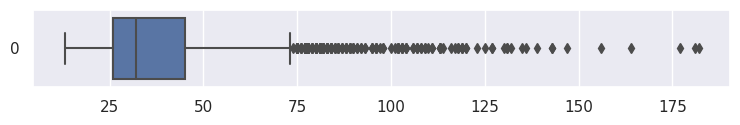

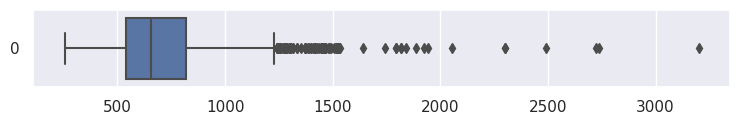

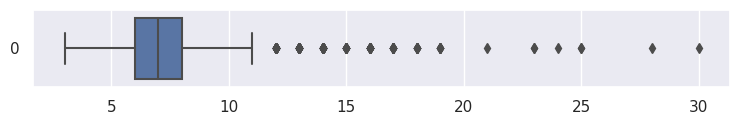

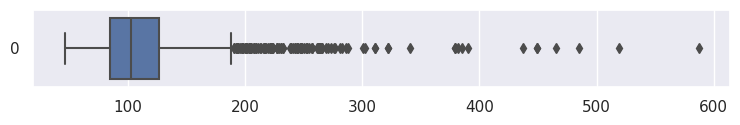

In [56]:
plotBox(df_trainL0_stat, df_validationL0_stat)

### L1: удаляем только юникод

In [35]:
df_trainL1, df_trainL1_stat = loadJSONL(fileNameData("train_L1"), "Train set")
df_validationL1, df_validationL1_stat  = loadJSONL(fileNameData("val_L1"), "Validation set")
df_testL1, df_testL1_stat = loadJSONL(fileNameData("test_L1"), "Test set:")

Train set


question  \
0  Вднх - это выставочныи центр?       
1  Вднх - это выставочныи центр?       
2  Был ли джиган в black star?         
3  Xiaomi конкурент apple?             
4  Был ли автомат калашникова в вов?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          passage  \
0  «Выставочныи центр» — станция Московского монорельса. Расположена между станциями «Улица Академика Королева» и «Улица Сергея Эизенштеина». Находится на территории Останкинского раиона Северо-Восточного административного округа города Москвы. Переход на станцию ВДНХ Калужско-Рижскои линии. Названа в честь Всероссииского выставочного центра — названия ВДНХ с 1992 по 2014 год. 20 ноября 2004 года линия монорельса начала работать в «экскурсионном режиме» и перевезла первых пассажиров .                                                                                                                                                                                                                                                                                                                                                                                                                           
1  Выставка достижении народного хозяиства , в 1959—1991 годах — Выставка достижении народного хозяиства СССР , в 1992—2014 годах — Всероссиискии выставочныи центр ) — выставочныи комплекс в Останкинском раионе Северо-Восточного административного округа города Москвы, второи по величине выставочныи комплекс в городе. Входит в 50 крупнеиших выставочных центров мира. Ежегодно ВДНХ посещают 30 млн гостеи. 1 августа 2019 года выставка отпраздновала 80-летнии юбилеи. Территориально ВДНХ объединена с парком «Останкино» и Главным ботаническим садом , их общая площадь составляет почти 700 га: 240,2 га — площадь ВДНХ, 75,6 га — площадь парка «Останкино», 361 га — площадь ГБС, 9,5 га музеино-выставочныи центр «Рабочии и колхозница» и площадь перед аркои Главного входа. На территории Выставки расположено множество шедевров архитектуры — 49 объектов ВДНХ признаны памятниками культурного наследия.   
2  Вместе с этим треком они выступили на церемонии вручения наград MTV RMA — это был первыи выход Джигана на большую сцену. В 2007 году Джиган стал официальным артистом леибла Black Star Inc., выпустил первыи песню и клип «Одноклассница» — совместная работа с Тимати. В марте 2011 года появилась совместная с Юлеи Савичевои композиция «Отпусти». Песня поднялась в радиочарте «Tophit» до 8 места и заняла первое место чарта Weekly Audience Choice Top Hit . Количество просмотров клипа на YouTube превысило 17 миллионов.                                                                                                                                                                                                                                                                                                                                                                                              
3  Xiaomi — китаиская компания, основанная в 2010 году и занимающаяся выпуском электроники и бытовои техники, а также разработкои программного обеспечения. Основнои продукциеи компани

Stats:


label  MIN   MAX  MEAN  \
0  question(symbols)  14   182   41     
1  question(words)    3    30    7      
2  passage(symbols)   293  3200  722    
3  passage(words)     48   587   115    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        LenArray  
0  [29, 29, 27, 23, 33, 35, 35, 40, 33, 33, 50, 31, 31, 42, 42, 27, 33, 36, 24, 27, 27, 29, 25, 17, 29, 32, 38, 38, 36, 36, 40, 32, 30, 30, 26, 26, 32, 30, 30, 30, 30, 30, 30, 45, 25, 25, 25, 24, 24, 21, 26, 28, 23, 25, 25, 36, 22, 27, 27, 27, 27, 26, 26, 38, 22, 22, 39, 21, 25, 25, 25, 32, 23, 60, 60, 35, 23, 23, 23, 23, 30, 20, 20, 20, 70, 23, 23, 28, 30, 25, 28, 42, 42, 42, 29, 29, 29, 27, 24, 24, ...]                                                                                                          
1  [6, 6, 7, 4, 7, 7, 7, 8, 7, 7, 8, 6, 6, 7, 7, 6, 7, 8, 6, 6, 6, 6, 6, 5, 8, 7, 7, 7, 7, 7, 9, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 7, 7, 7, 6, 6, 7, 6, 6, 6, 6, 7, 6, 10, 10, 9, 6, 6, 6, 6, 5, 6, 6, 6, 10, 6, 6, 6, 6, 6, 7, 8, 8, 8, 6, 6, 6, 6, 6, 6, ...]                                                                                                                                                                                                           
2  [486, 894, 515, 759, 676, 1085, 1079, 826, 566, 412, 851, 851, 588, 498, 732, 501, 568, 940, 393, 550, 613, 938, 479, 673, 467, 669, 415, 464, 772, 697, 683, 502, 759, 752, 523, 557, 951, 498, 619, 600, 577, 798, 816, 611, 786, 486, 842, 721, 551, 532, 899, 515, 569, 526, 430, 504, 827, 470, 677, 546, 552, 409, 767, 999, 312, 633, 561, 508, 956, 666, 912, 701, 486, 740, 994, 498, 834, 724, 530, 551, 920, 706, 419, 345, 728, 765, 1038, 471, 695, 690, 747, 893, 477, 629, 513, 1077, 625, 694, 508, 787, ...]  
3  [75, 141, 92, 124, 99, 157, 141, 142, 96, 68, 128, 115, 81, 74, 105, 86, 91, 140, 77, 95, 108, 162, 86, 106, 62, 115, 69, 77, 126, 128, 109, 75, 114, 124, 89, 102, 142, 81, 91, 94, 94, 124, 121, 98, 123, 75, 125, 120, 93, 89, 134, 77, 97, 85, 71, 91, 127, 69, 135, 94, 93, 81, 127, 161, 54, 94, 102, 87, 156, 110, 144, 106, 84, 117, 175, 84, 133, 118, 89, 94, 128, 114, 84, 69, 117, 140, 157, 81, 90, 125, 120, 131, 69, 92, 78, 166, 100, 102, 73, 115, ...]

True answer: 1061
False answer: 688

Validation set


question  \
0  Есть ли вода на марсе?                       
1  Состоит ли англия в евросоюзе?               
2  Деиствительно ли в ссср не было адвокатов?   
3  Была ли чума в оране?                        
4  Был ли кетчуп в читосе?                      

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               passage  \
0  Гидросфера Марса — это совокупность водных запасов планеты Марс, представленная водным льдом в полярных шапках Марса, льдом над поверхностью, сезонными ручьями из жидкои воды и возможными резервуарами жидкои воды и водных растворов солеи в верхних слоях литосферы Марса. Гидросфера Марса, вследствие господствующих низких температур на Марсе и нахождения запасов воды в твердом состоянии, также называется криолитосферои. Основная статья: История поисков воды на Марсе Марс весьма схож с Землеи по многим показателям, что заставляло ученых XIX — начала XX века допускать, что на нем есть жизнь и есть жидкая вода. По мере роста объема данных о планете, собранных различными методами, например, с помощью спектроскопических измерении, стало понятно, что воды в атмосфере Марса ничтожно малое количество, однако она все же присутствует. Прежде всего внимание исследователеи привлекли полярные шапки Марса, так как предполагалось, что они могут состоять из водного льда по аналогии с Антарктидои или Гренландиеи на Земле, однако высказывалась и гипотеза, что это твердыи диоксид углерода.                                                         
1  В полночь с 31 января на 1 февраля 2020 года по центральноевропеискому времени после 47 лет членства Великобритания официально покинула Евросоюз. В Европеискии союз входят 27 государств: Количество стран, участвующих в союзе, выросло с начальных шести — Бельгии, Западнои Германии, Италии, Люксембурга, Нидерландов и Франции — до сегодняшних 27 путем последовательных расширении: присоединяясь к договорам, страны ограничивали свои суверенитет в обмен на представительство в институтах союза, деиствующих в общих интересах. Для вступления в Европеискии союз страна-кандидат должна соответствовать Копенгагенским критериям, принятым в июне 1993 года на заседании Европеиского совета в Копенгагене и утвержденным в декабре 1995 года на заседании Европеиского совета в Мадриде. Критерии требуют, чтобы в государстве соблюдались демократические принципы, принципы свободы и уважения прав человека, а также принцип правового государства. Также в стране должна присутствовать конкурентоспособная рыночная экономика, и должны признаваться общие правила и стандарты ЕС, включая приверженность целям политического, экономического и валютного союза.   
2  Семен Львович Ария — советскии и россиискии юрист, один из крупнеиших советских адвокатов, Заслуженныи юрист РСФСР. Родился в евреискои семье , детство провел на Украине в г. Харькове. После окончания среднеи школы в течение года учился на мостовом факультете Новосибирского института военных инженеро

Stats:


label  MIN   MAX  MEAN  \
0  question(symbols)  13   96    33     
1  question(words)    3    16    6      
2  passage(symbols)   254  1417  673    
3  passage(words)     46   243   106    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             LenArray  
0  [22, 30, 42, 21, 23, 27, 22, 27, 20, 33, 73, 37, 41, 44, 20, 68, 54, 52, 35, 34, 24, 23, 42, 17, 30, 39, 41, 24, 24, 35, 34, 29, 60, 39, 29, 27, 24, 40, 20, 39, 31, 38, 25, 18, 19, 23, 17, 33, 45, 23, 52, 29, 28, 22, 40, 27, 58, 40, 26, 36, 34, 44, 96, 18, 26, 23, 29, 20, 48, 29, 34, 46, 21, 27, 18, 36, 44, 19, 18, 43, 27, 40, 21, 29, 43, 42, 23, 34, 24, 40, 25, 58, 38, 26, 31, 30, 32, 49, 34, 40, ...]                                                                                                               
1  [6, 6, 8, 6, 6, 6, 6, 6, 5, 7, 9, 7, 8, 9, 5, 10, 9, 10, 8, 7, 6, 6, 9, 4, 6, 7, 9, 5, 6, 8, 6, 6, 11, 6, 7, 5, 4, 8, 5, 6, 6, 9, 4, 5, 5, 6, 6, 6, 9, 5, 11, 6, 7, 6, 9, 6, 10, 7, 6, 9, 5, 9, 16, 4, 6, 5, 6, 6, 9, 6, 8, 8, 5, 6, 5, 7, 9, 5, 5, 8, 6, 9, 6, 5, 9, 7, 6, 7, 6, 8, 6, 12, 8, 5, 7, 5, 7, 7, 5, 10, ...]                                                                                                                                                                                                           
2  [1085, 1139, 654, 714, 892, 600, 912, 568, 1301, 494, 579, 505, 577, 778, 616, 1029, 584, 609, 735, 618, 712, 484, 555, 488, 586, 419, 578, 537, 851, 517, 751, 585, 313, 769, 517, 749, 1032, 662, 620, 471, 630, 1110, 715, 652, 716, 827, 463, 725, 606, 683, 777, 790, 738, 714, 337, 467, 744, 686, 757, 644, 780, 1207, 560, 593, 942, 712, 504, 793, 391, 584, 582, 821, 747, 710, 418, 702, 394, 498, 662, 567, 989, 421, 468, 467, 624, 679, 502, 1045, 480, 835, 529, 910, 819, 837, 611, 598, 1008, 504, 459, 801, ...]  
3  [177, 168, 105, 118, 142, 103, 132, 91, 201, 89, 87, 77, 90, 123, 94, 149, 88, 91, 125, 92, 112, 78, 93, 84, 88, 67, 96, 94, 136, 86, 112, 88, 53, 109, 90, 113, 155, 113, 113, 64, 100, 162, 112, 106, 113, 151, 72, 113, 98, 113, 108, 126, 118, 113, 62, 77, 102, 100, 112, 102, 124, 173, 85, 98, 166, 101, 91, 119, 64, 88, 100, 140, 112, 109, 78, 123, 78, 101, 117, 108, 169, 73, 90, 74, 99, 118, 87, 158, 77, 128, 90, 141, 132, 128, 96, 112, 146, 81, 80, 128, ...]

True answer: 412
False answer: 409

Test set:


question  \
0  Полезна ли ртуть с градусника?     
1  Являются ли сапрофаги хищниками?   
2  Водятся ли в индии крокодилы?      
3  Есть ли в батате крахмал?          
4  Был ли человек в железнои маске?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              passage  \
0  Отравления ртутью — расстроиства здоровья, связанные с избыточным поступлением паров или соединении ртути в организм. Токсические своиства ртути известны с глубокои древности. Соединения ртути — киноварь, каломель и сулема — применялись для разных целеи, в том числе и в качестве ядов. С древних времен известна также и металлическая ртуть, хотя ее токсичность поначалу сильно недооценивалась. Ртуть и ее соединения стали особенно широко применяться в средние века, в частности при производстве золота и серебряных зеркал, а также при изготовлении фетра для шляп, что вызвало поток новых, уже профессиональных отравлении.                                                                                                                                        
1  Фауна лесных почв — совокупность видов животных, для которых лесная почва является средои обитания, часть леснои фауны. Животных, обитающих в почве, в зависимости от размеров особеи относят к следующим группам: макрофауна — в основном мелкие млекопитающие, в том числе землероики, кроты. мезофауна — ее представляют дождевые черви, многоножки, мокрицы, насекомые, их личинки. микрофауна — нематоды, энхитреиды, клещи, в основном панцирные клещи, ногохвостки и другие. Нанофауна - это одноклеточные простеишие. В любых лесах среди беспозвоночных почв преобладают сапрофаги, которые питаются лесным опадом, грибницеи, гниющеи древесинои.                                                                                                                          
2  Болотныи крокодил, или магер — пресмыкающееся из семеиства настоящих крокодилов, обитающее на территории Индостана и прилегающих стран, таких как Пакистан. Это один из трех обитающих в Индии крокодилов, наряду с гавиалом и гребнистым крокодилом. Ближаишии современныи родственник болотного крокодила — сиамскии крокодил, вместе с гребнистым крокодилом они образуют обособленную азиатскую кладу. У болотного крокодила грубая голова без гребнеи или выростов чешуичатых костеи, тяжелые и широкие челюсти, длина которых превышает ширину у основания в 1,3—2,5 раза. Четыре большие пластины на шее образуют квадрат, с меньшими по размерам пластинами на каждои стороне.                                                                                               
3  Клубневидно вздутые корни весят до 15 кг, содержат 20—40 % крахмала. Растение широко культивируется в тропических регионах, например, в Африке. В пищу идет похожии на картофелину корнеплод, которыи может достигать 8 см в диаметре и 1 м в длину, масса — от 3 до 10 кг. В корнеплодах много крахмала. В сыром виде корнеплоды очень ядовиты и употребляются только вареными или печеными.                                                                                                                                                                                                                                                                                                                                                                            

Stats:


label  MIN   MAX  MEAN  \
0  question(symbols)  13   97    34     
1  question(words)    4    14    6      
2  passage(symbols)   251  1238  649    
3  passage(words)     45   194   101    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      LenArray  
0  [30, 32, 29, 25, 32, 33, 41, 31, 31, 25, 35, 51, 24, 37, 82, 60, 49, 31, 23, 60, 50, 20, 28, 38, 34, 23, 56, 31, 25, 42, 60, 25, 26, 49, 29, 35, 37, 31, 28, 32, 31, 24, 46, 25, 37, 28, 23, 25, 36, 24, 50, 37, 28, 30, 35, 39, 32, 25, 32, 21, 30, 20, 30, 46, 23, 44, 54, 33, 34, 32, 25, 45, 66, 31, 19, 52, 27, 27, 58, 29, 26, 37, 21, 54, 60, 36, 30, 26, 35, 54, 72, 33, 54, 46, 30, 30, 42, 23, 25, 21, ...]                                                                                                        
1  [6, 5, 6, 6, 7, 7, 7, 7, 7, 6, 7, 10, 5, 6, 13, 9, 8, 8, 6, 9, 8, 6, 7, 7, 7, 6, 8, 7, 6, 10, 9, 6, 6, 7, 6, 6, 8, 6, 6, 7, 7, 5, 8, 6, 6, 5, 6, 6, 8, 6, 10, 7, 6, 7, 6, 6, 6, 6, 7, 6, 5, 5, 6, 9, 6, 8, 10, 7, 8, 5, 6, 7, 8, 7, 6, 10, 6, 6, 11, 6, 5, 7, 5, 8, 11, 9, 6, 6, 6, 8, 12, 7, 9, 9, 7, 7, 11, 6, 6, 6, ...]                                                                                                                                                                                                  
2  [621, 635, 662, 381, 754, 842, 540, 425, 439, 303, 648, 437, 455, 545, 685, 472, 648, 636, 679, 726, 855, 635, 535, 738, 637, 656, 776, 761, 661, 410, 318, 744, 697, 522, 661, 388, 370, 808, 777, 652, 714, 486, 794, 1043, 603, 473, 446, 803, 601, 789, 577, 952, 984, 585, 690, 894, 882, 711, 401, 775, 553, 1038, 817, 820, 324, 732, 572, 789, 811, 736, 405, 685, 515, 632, 341, 422, 629, 450, 606, 455, 488, 573, 911, 785, 402, 544, 507, 962, 751, 545, 537, 454, 464, 810, 908, 707, 395, 406, 477, 468, ...]  
3  [101, 108, 103, 72, 116, 141, 88, 60, 82, 51, 111, 73, 67, 88, 108, 73, 102, 103, 89, 116, 107, 95, 100, 126, 107, 107, 110, 120, 106, 71, 52, 111, 94, 76, 91, 62, 69, 115, 123, 95, 112, 72, 121, 152, 107, 78, 60, 118, 100, 129, 87, 158, 151, 99, 100, 151, 143, 124, 63, 117, 78, 161, 121, 117, 60, 128, 93, 115, 111, 101, 68, 103, 77, 102, 67, 69, 102, 87, 80, 73, 65, 89, 144, 123, 67, 93, 75, 153, 127, 80, 94, 74, 77, 111, 137, 111, 87, 75, 99, 69, ...]

SYMBOL QUESTION MIN: 13 MAX: 182 MEAN: 38.876264591439686
SYMBOL CONTEXT MIN: 254 MAX: 3200 MEAN: 706.5941634241245
WORD QUESTION MIN: 3 MAX: 30 MEAN: 7.335019455252918
WORD CONTEXT MIN: 46 MAX: 587 MEAN: 112.73813229571985


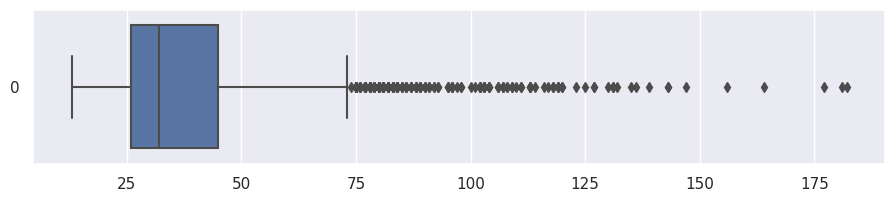

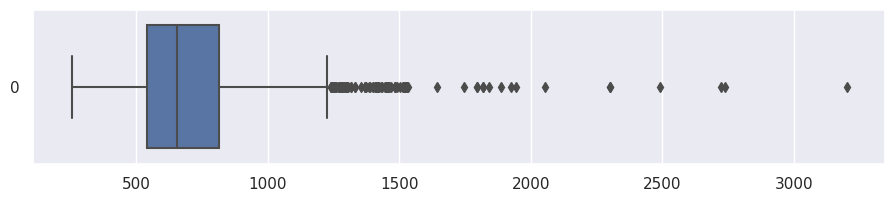

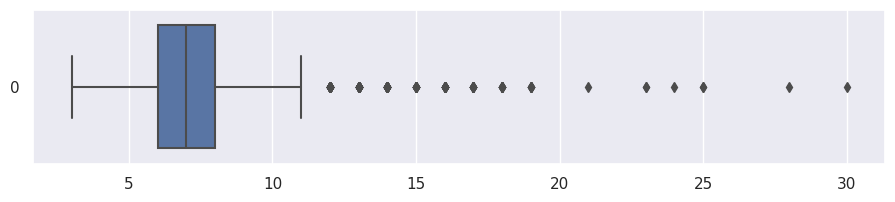

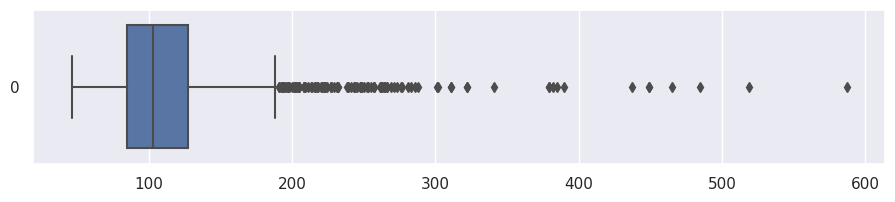

In [72]:
plotBox(df_trainL1_stat, df_validationL1_stat)

### L2: переводим в нижний регистр

In [34]:
df_trainL2, df_trainL2_stat = loadJSONL(fileNameData("train_L2"), "Train set")
df_validationL2, df_validationL2_stat = loadJSONL(fileNameData("val_L2"), "Validation set")
df_testL2, df_testL2_stat = loadJSONL(fileNameData("test_L2"), "Test set:")

Train set


question  \
0  вднх - это выставочныи центр?       
1  вднх - это выставочныи центр?       
2  был ли джиган в black star?         
3  xiaomi конкурент apple?             
4  был ли автомат калашникова в вов?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          passage  \
0  «выставочныи центр» — станция московского монорельса. расположена между станциями «улица академика королева» и «улица сергея эизенштеина». находится на территории останкинского раиона северо-восточного административного округа города москвы. переход на станцию вднх калужско-рижскои линии. названа в честь всероссииского выставочного центра — названия вднх с 1992 по 2014 год. 20 ноября 2004 года линия монорельса начала работать в «экскурсионном режиме» и перевезла первых пассажиров .                                                                                                                                                                                                                                                                                                                                                                                                                           
1  выставка достижении народного хозяиства , в 1959—1991 годах — выставка достижении народного хозяиства ссср , в 1992—2014 годах — всероссиискии выставочныи центр ) — выставочныи комплекс в останкинском раионе северо-восточного административного округа города москвы, второи по величине выставочныи комплекс в городе. входит в 50 крупнеиших выставочных центров мира. ежегодно вднх посещают 30 млн гостеи. 1 августа 2019 года выставка отпраздновала 80-летнии юбилеи. территориально вднх объединена с парком «останкино» и главным ботаническим садом , их общая площадь составляет почти 700 га: 240,2 га — площадь вднх, 75,6 га — площадь парка «останкино», 361 га — площадь гбс, 9,5 га музеино-выставочныи центр «рабочии и колхозница» и площадь перед аркои главного входа. на территории выставки расположено множество шедевров архитектуры — 49 объектов вднх признаны памятниками культурного наследия.   
2  вместе с этим треком они выступили на церемонии вручения наград mtv rma — это был первыи выход джигана на большую сцену. в 2007 году джиган стал официальным артистом леибла black star inc., выпустил первыи песню и клип «одноклассница» — совместная работа с тимати. в марте 2011 года появилась совместная с юлеи савичевои композиция «отпусти». песня поднялась в радиочарте «tophit» до 8 места и заняла первое место чарта weekly audience choice top hit . количество просмотров клипа на youtube превысило 17 миллионов.                                                                                                                                                                                                                                                                                                                                                                                              
3  xiaomi — китаиская компания, основанная в 2010 году и занимающаяся выпуском электроники и бытовои техники, а также разработкои программного обеспечения. основнои продукциеи компани

Stats:


label  MIN   MAX  MEAN  \
0  question(symbols)  14   182   41     
1  question(words)    3    30    7      
2  passage(symbols)   293  3200  722    
3  passage(words)     48   587   115    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        LenArray  
0  [29, 29, 27, 23, 33, 35, 35, 40, 33, 33, 50, 31, 31, 42, 42, 27, 33, 36, 24, 27, 27, 29, 25, 17, 29, 32, 38, 38, 36, 36, 40, 32, 30, 30, 26, 26, 32, 30, 30, 30, 30, 30, 30, 45, 25, 25, 25, 24, 24, 21, 26, 28, 23, 25, 25, 36, 22, 27, 27, 27, 27, 26, 26, 38, 22, 22, 39, 21, 25, 25, 25, 32, 23, 60, 60, 35, 23, 23, 23, 23, 30, 20, 20, 20, 70, 23, 23, 28, 30, 25, 28, 42, 42, 42, 29, 29, 29, 27, 24, 24, ...]                                                                                                          
1  [6, 6, 7, 4, 7, 7, 7, 8, 7, 7, 8, 6, 6, 7, 7, 6, 7, 8, 6, 6, 6, 6, 6, 5, 8, 7, 7, 7, 7, 7, 9, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 6, 6, 6, 6, 6, 7, 7, 7, 6, 6, 7, 6, 6, 6, 6, 7, 6, 10, 10, 9, 6, 6, 6, 6, 5, 6, 6, 6, 10, 6, 6, 6, 6, 6, 7, 8, 8, 8, 6, 6, 6, 6, 6, 6, ...]                                                                                                                                                                                                           
2  [486, 894, 515, 759, 676, 1085, 1079, 826, 566, 412, 851, 851, 588, 498, 732, 501, 568, 940, 393, 550, 613, 938, 479, 673, 467, 669, 415, 464, 772, 697, 683, 502, 759, 752, 523, 557, 951, 498, 619, 600, 577, 798, 816, 611, 786, 486, 842, 721, 551, 532, 899, 515, 569, 526, 430, 504, 827, 470, 677, 546, 552, 409, 767, 999, 312, 633, 561, 508, 956, 666, 912, 701, 486, 740, 994, 498, 834, 724, 530, 551, 920, 706, 419, 345, 728, 765, 1038, 471, 695, 690, 747, 893, 477, 629, 513, 1077, 625, 694, 508, 787, ...]  
3  [75, 141, 92, 124, 99, 157, 141, 142, 96, 68, 128, 115, 81, 74, 105, 86, 91, 140, 77, 95, 108, 162, 86, 106, 62, 115, 69, 77, 126, 128, 109, 75, 114, 124, 89, 102, 142, 81, 91, 94, 94, 124, 121, 98, 123, 75, 125, 120, 93, 89, 134, 77, 97, 85, 71, 91, 127, 69, 135, 94, 93, 81, 127, 161, 54, 94, 102, 87, 156, 110, 144, 106, 84, 117, 175, 84, 133, 118, 89, 94, 128, 114, 84, 69, 117, 140, 157, 81, 90, 125, 120, 131, 69, 92, 78, 166, 100, 102, 73, 115, ...]

True answer: 1061
False answer: 688

Validation set


question  \
0  есть ли вода на марсе?                       
1  состоит ли англия в евросоюзе?               
2  деиствительно ли в ссср не было адвокатов?   
3  была ли чума в оране?                        
4  был ли кетчуп в читосе?                      

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               passage  \
0  гидросфера марса — это совокупность водных запасов планеты марс, представленная водным льдом в полярных шапках марса, льдом над поверхностью, сезонными ручьями из жидкои воды и возможными резервуарами жидкои воды и водных растворов солеи в верхних слоях литосферы марса. гидросфера марса, вследствие господствующих низких температур на марсе и нахождения запасов воды в твердом состоянии, также называется криолитосферои. основная статья: история поисков воды на марсе марс весьма схож с землеи по многим показателям, что заставляло ученых xix — начала xx века допускать, что на нем есть жизнь и есть жидкая вода. по мере роста объема данных о планете, собранных различными методами, например, с помощью спектроскопических измерении, стало понятно, что воды в атмосфере марса ничтожно малое количество, однако она все же присутствует. прежде всего внимание исследователеи привлекли полярные шапки марса, так как предполагалось, что они могут состоять из водного льда по аналогии с антарктидои или гренландиеи на земле, однако высказывалась и гипотеза, что это твердыи диоксид углерода.                                                         
1  в полночь с 31 января на 1 февраля 2020 года по центральноевропеискому времени после 47 лет членства великобритания официально покинула евросоюз. в европеискии союз входят 27 государств: количество стран, участвующих в союзе, выросло с начальных шести — бельгии, западнои германии, италии, люксембурга, нидерландов и франции — до сегодняшних 27 путем последовательных расширении: присоединяясь к договорам, страны ограничивали свои суверенитет в обмен на представительство в институтах союза, деиствующих в общих интересах. для вступления в европеискии союз страна-кандидат должна соответствовать копенгагенским критериям, принятым в июне 1993 года на заседании европеиского совета в копенгагене и утвержденным в декабре 1995 года на заседании европеиского совета в мадриде. критерии требуют, чтобы в государстве соблюдались демократические принципы, принципы свободы и уважения прав человека, а также принцип правового государства. также в стране должна присутствовать конкурентоспособная рыночная экономика, и должны признаваться общие правила и стандарты ес, включая приверженность целям политического, экономического и валютного союза.   
2  семен львович ария — советскии и россиискии юрист, один из крупнеиших советских адвокатов, заслуженныи юрист рсфср. родился в евреискои семье , детство провел на украине в г. харькове. после окончания среднеи школы в течение года учился на мостовом факультете новосибирского института военных инженеро

Stats:


label  MIN   MAX  MEAN  \
0  question(symbols)  13   96    33     
1  question(words)    3    16    6      
2  passage(symbols)   254  1417  673    
3  passage(words)     46   243   106    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             LenArray  
0  [22, 30, 42, 21, 23, 27, 22, 27, 20, 33, 73, 37, 41, 44, 20, 68, 54, 52, 35, 34, 24, 23, 42, 17, 30, 39, 41, 24, 24, 35, 34, 29, 60, 39, 29, 27, 24, 40, 20, 39, 31, 38, 25, 18, 19, 23, 17, 33, 45, 23, 52, 29, 28, 22, 40, 27, 58, 40, 26, 36, 34, 44, 96, 18, 26, 23, 29, 20, 48, 29, 34, 46, 21, 27, 18, 36, 44, 19, 18, 43, 27, 40, 21, 29, 43, 42, 23, 34, 24, 40, 25, 58, 38, 26, 31, 30, 32, 49, 34, 40, ...]                                                                                                               
1  [6, 6, 8, 6, 6, 6, 6, 6, 5, 7, 9, 7, 8, 9, 5, 10, 9, 10, 8, 7, 6, 6, 9, 4, 6, 7, 9, 5, 6, 8, 6, 6, 11, 6, 7, 5, 4, 8, 5, 6, 6, 9, 4, 5, 5, 6, 6, 6, 9, 5, 11, 6, 7, 6, 9, 6, 10, 7, 6, 9, 5, 9, 16, 4, 6, 5, 6, 6, 9, 6, 8, 8, 5, 6, 5, 7, 9, 5, 5, 8, 6, 9, 6, 5, 9, 7, 6, 7, 6, 8, 6, 12, 8, 5, 7, 5, 7, 7, 5, 10, ...]                                                                                                                                                                                                           
2  [1085, 1139, 654, 714, 892, 600, 912, 568, 1301, 494, 579, 505, 577, 778, 616, 1029, 584, 609, 735, 618, 712, 484, 555, 488, 586, 419, 578, 537, 851, 517, 751, 585, 313, 769, 517, 749, 1032, 662, 620, 471, 630, 1110, 715, 652, 716, 827, 463, 725, 606, 683, 777, 790, 738, 714, 337, 467, 744, 686, 757, 644, 780, 1207, 560, 593, 942, 712, 504, 793, 391, 584, 582, 821, 747, 710, 418, 702, 394, 498, 662, 567, 989, 421, 468, 467, 624, 679, 502, 1045, 480, 835, 529, 910, 819, 837, 611, 598, 1008, 504, 459, 801, ...]  
3  [177, 168, 105, 118, 142, 103, 132, 91, 201, 89, 87, 77, 90, 123, 94, 149, 88, 91, 125, 92, 112, 78, 93, 84, 88, 67, 96, 94, 136, 86, 112, 88, 53, 109, 89, 113, 155, 113, 113, 64, 100, 162, 112, 106, 113, 151, 72, 113, 98, 113, 108, 126, 118, 113, 62, 77, 102, 100, 112, 102, 124, 173, 85, 98, 166, 101, 91, 119, 64, 88, 99, 140, 112, 109, 78, 123, 78, 101, 117, 108, 169, 73, 90, 74, 99, 118, 87, 158, 77, 128, 90, 141, 132, 128, 96, 112, 146, 81, 80, 128, ...]

True answer: 412
False answer: 409

Test set:


question  \
0  полезна ли ртуть с градусника?     
1  являются ли сапрофаги хищниками?   
2  водятся ли в индии крокодилы?      
3  есть ли в батате крахмал?          
4  был ли человек в железнои маске?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              passage  \
0  отравления ртутью — расстроиства здоровья, связанные с избыточным поступлением паров или соединении ртути в организм. токсические своиства ртути известны с глубокои древности. соединения ртути — киноварь, каломель и сулема — применялись для разных целеи, в том числе и в качестве ядов. с древних времен известна также и металлическая ртуть, хотя ее токсичность поначалу сильно недооценивалась. ртуть и ее соединения стали особенно широко применяться в средние века, в частности при производстве золота и серебряных зеркал, а также при изготовлении фетра для шляп, что вызвало поток новых, уже профессиональных отравлении.                                                                                                                                        
1  фауна лесных почв — совокупность видов животных, для которых лесная почва является средои обитания, часть леснои фауны. животных, обитающих в почве, в зависимости от размеров особеи относят к следующим группам: макрофауна — в основном мелкие млекопитающие, в том числе землероики, кроты. мезофауна — ее представляют дождевые черви, многоножки, мокрицы, насекомые, их личинки. микрофауна — нематоды, энхитреиды, клещи, в основном панцирные клещи, ногохвостки и другие. нанофауна - это одноклеточные простеишие. в любых лесах среди беспозвоночных почв преобладают сапрофаги, которые питаются лесным опадом, грибницеи, гниющеи древесинои.                                                                                                                          
2  болотныи крокодил, или магер — пресмыкающееся из семеиства настоящих крокодилов, обитающее на территории индостана и прилегающих стран, таких как пакистан. это один из трех обитающих в индии крокодилов, наряду с гавиалом и гребнистым крокодилом. ближаишии современныи родственник болотного крокодила — сиамскии крокодил, вместе с гребнистым крокодилом они образуют обособленную азиатскую кладу. у болотного крокодила грубая голова без гребнеи или выростов чешуичатых костеи, тяжелые и широкие челюсти, длина которых превышает ширину у основания в 1,3—2,5 раза. четыре большие пластины на шее образуют квадрат, с меньшими по размерам пластинами на каждои стороне.                                                                                               
3  клубневидно вздутые корни весят до 15 кг, содержат 20—40 % крахмала. растение широко культивируется в тропических регионах, например, в африке. в пищу идет похожии на картофелину корнеплод, которыи может достигать 8 см в диаметре и 1 м в длину, масса — от 3 до 10 кг. в корнеплодах много крахмала. в сыром виде корнеплоды очень ядовиты и употребляются только вареными или печеными.                                                                                                                                                                                                                                                                                                                                                                            

Stats:


label  MIN   MAX  MEAN  \
0  question(symbols)  13   97    34     
1  question(words)    4    14    6      
2  passage(symbols)   251  1238  649    
3  passage(words)     45   194   101    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      LenArray  
0  [30, 32, 29, 25, 32, 33, 41, 31, 31, 25, 35, 51, 24, 37, 82, 60, 49, 31, 23, 60, 50, 20, 28, 38, 34, 23, 56, 31, 25, 42, 60, 25, 26, 49, 29, 35, 37, 31, 28, 32, 31, 24, 46, 25, 37, 28, 23, 25, 36, 24, 50, 37, 28, 30, 35, 39, 32, 25, 32, 21, 30, 20, 30, 46, 23, 44, 54, 33, 34, 32, 25, 45, 66, 31, 19, 52, 27, 27, 58, 29, 26, 37, 21, 54, 60, 36, 30, 26, 35, 54, 72, 33, 54, 46, 30, 30, 42, 23, 25, 21, ...]                                                                                                        
1  [6, 5, 6, 6, 7, 7, 7, 7, 7, 6, 7, 10, 5, 6, 13, 9, 8, 8, 6, 9, 8, 6, 7, 7, 7, 6, 8, 7, 6, 10, 9, 6, 6, 7, 6, 6, 8, 6, 6, 7, 7, 5, 8, 6, 6, 5, 6, 6, 8, 6, 10, 7, 6, 7, 6, 6, 6, 6, 7, 6, 5, 5, 6, 9, 6, 8, 10, 7, 8, 5, 6, 7, 8, 7, 6, 10, 6, 6, 11, 6, 5, 7, 5, 8, 11, 9, 6, 6, 6, 8, 12, 7, 9, 9, 7, 7, 11, 6, 6, 6, ...]                                                                                                                                                                                                  
2  [621, 635, 662, 381, 754, 842, 540, 425, 439, 303, 648, 437, 455, 545, 685, 472, 648, 636, 679, 726, 855, 635, 535, 738, 637, 656, 776, 761, 661, 410, 318, 744, 697, 522, 661, 388, 370, 808, 777, 652, 714, 486, 794, 1043, 603, 473, 446, 803, 601, 789, 577, 952, 984, 585, 690, 894, 882, 711, 401, 775, 553, 1038, 817, 820, 324, 732, 572, 789, 811, 736, 405, 685, 515, 632, 341, 422, 629, 450, 606, 455, 488, 573, 911, 785, 402, 544, 507, 962, 751, 545, 537, 454, 464, 810, 908, 707, 395, 406, 477, 468, ...]  
3  [101, 108, 103, 72, 116, 141, 88, 60, 82, 51, 111, 73, 67, 88, 108, 73, 102, 103, 89, 115, 107, 95, 100, 125, 107, 107, 110, 120, 106, 71, 52, 111, 94, 76, 91, 62, 69, 115, 123, 95, 112, 72, 121, 152, 107, 78, 60, 118, 100, 129, 87, 157, 151, 99, 100, 151, 143, 124, 63, 117, 78, 161, 121, 117, 60, 128, 93, 115, 111, 101, 68, 103, 77, 102, 67, 69, 102, 87, 80, 73, 65, 89, 144, 123, 67, 93, 75, 153, 127, 80, 94, 74, 77, 111, 137, 111, 87, 75, 99, 69, ...]

SYMBOL QUESTION MIN: 13 MAX: 182 MEAN: 38.876264591439686
SYMBOL CONTEXT MIN: 254 MAX: 3200 MEAN: 706.5941634241245
WORD QUESTION MIN: 3 MAX: 30 MEAN: 7.335019455252918
WORD CONTEXT MIN: 46 MAX: 587 MEAN: 112.71712062256809


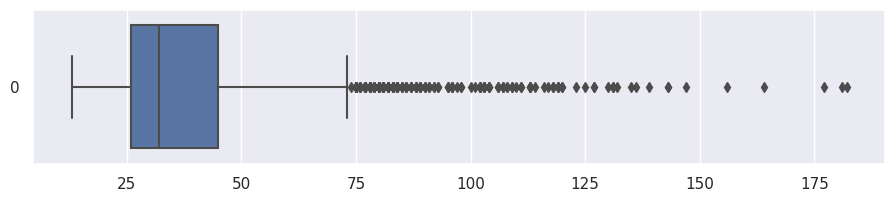

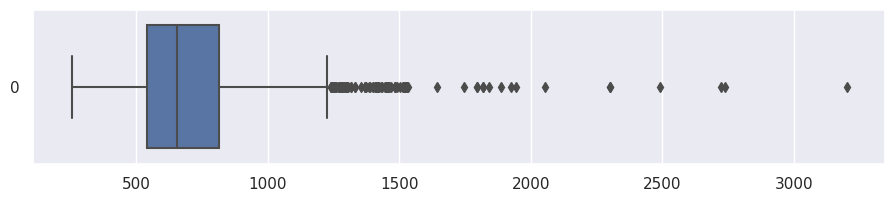

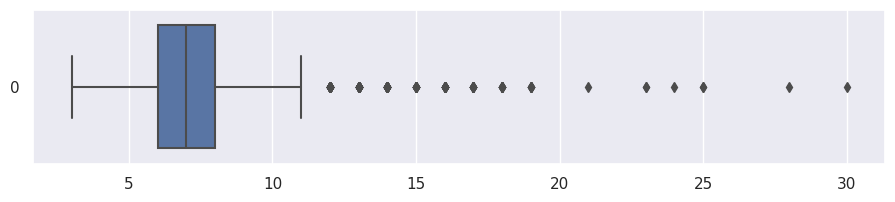

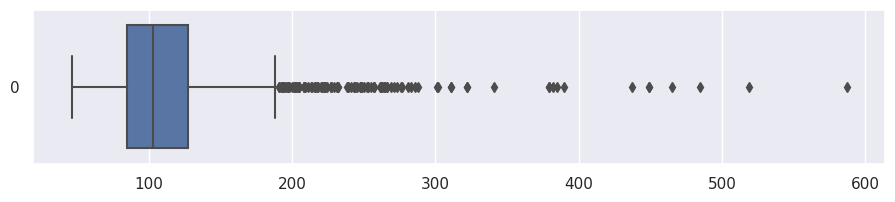

In [75]:
plotBox(df_trainL2_stat, df_validationL2_stat)

### L3: удаляем символы пунктуации и тд

In [33]:
df_trainL3, df_trainL3_stat = loadJSONL(fileNameData("train_L3"), "Train set")
df_validationL3, df_validationL3_stat = loadJSONL(fileNameData("val_L3"), "Validation set")
df_testL3, df_testL3_stat = loadJSONL(fileNameData("test_L3"), "Test set:")

Train set


question  \
0  вднх это выставочныи центр         
1  вднх это выставочныи центр         
2  был ли джиган в black star         
3  xiaomi конкурент apple             
4  был ли автомат калашникова в вов   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   passage  \
0  выставочныи центр станция московского монорельса расположена между станциями улица академика королева и улица сергея эизенштеина находится на территории останкинского раиона северо восточного административного округа города москвы переход на станцию вднх калужско рижскои линии названа в честь всероссииского выставочного центра названия вднх с 1992 по 2014 год 20 ноября 2004 года линия монорельса начала работать в экскурсионном режиме и перевезла первых пассажиров                                                                                                                                                                                                                                                                                                                                                                                                       
1  выставка достижении народного хозяиства в 1959 1991 годах выставка достижении народного хозяиства ссср в 1992 2014 годах всероссиискии выставочныи центр выставочныи комплекс в останкинском раионе северо восточного административного округа города москвы второи по величине выставочныи комплекс в городе входит в 50 крупнеиших выставочных центров мира ежегодно вднх посещают 30 млн гостеи 1 августа 2019 года выставка отпраздновала 80 летнии юбилеи территориально вднх объединена с парком останкино и главным ботаническим садом их общая площадь составляет почти 700 га 240 2 га площадь вднх 75 6 га площадь парка останкино 361 га площадь гбс 9 5 га музеино выставочныи центр рабочии и колхозница и площадь перед аркои главного входа на территории выставки расположено множество шедевров архитектуры 49 объектов вднх признаны памятниками культурного наследия   
2  вместе с этим треком они выступили на церемонии вручения наград mtv rma это был первыи выход джигана на большую сцену в 2007 году джиган стал официальным артистом леибла black star inc выпустил первыи песню и клип одноклассница совместная работа с тимати в марте 2011 года появилась совместная с юлеи савичевои композиция отпусти песня поднялась в радиочарте tophit до 8 места и заняла первое место чарта weekly audience choice top hit количество просмотров клипа на youtube превысило 17 миллионов                                                                                                                                                                                                                                                                                                                                                                         
3  xiaomi китаиская компания основанная в 2010 году и занимающаяся выпуском электроники и бытовои техники а также разработкои программного обеспечения основнои продукциеи компании являются смартфоны первыи из которых был выпущен в 2011 году в настоящее время xiaomi производит широкии ассортимент смартфонов в разных ценовых сегментах и являетс

Stats:


label  MIN   MAX  MEAN  \
0  question(symbols)  13   179   40     
1  question(words)    2    28    6      
2  passage(symbols)   271  3095  701    
3  passage(words)     40   479   98     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        LenArray  
0  [26, 26, 26, 22, 32, 34, 34, 39, 32, 32, 49, 30, 30, 41, 41, 26, 32, 35, 23, 26, 26, 28, 24, 16, 28, 31, 37, 37, 35, 35, 39, 31, 29, 29, 25, 25, 31, 29, 29, 29, 29, 29, 29, 44, 24, 24, 24, 23, 23, 20, 25, 27, 22, 24, 24, 35, 21, 26, 26, 26, 26, 25, 25, 37, 21, 21, 38, 20, 24, 24, 24, 31, 22, 59, 59, 34, 22, 22, 22, 22, 29, 19, 19, 19, 69, 22, 22, 27, 29, 24, 27, 41, 41, 41, 28, 28, 28, 26, 23, 23, ...]                                                                                                          
1  [4, 4, 6, 3, 6, 6, 6, 7, 6, 6, 7, 5, 5, 6, 6, 5, 6, 7, 5, 5, 5, 5, 5, 4, 7, 6, 6, 6, 6, 6, 8, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 6, 6, 6, 5, 5, 6, 5, 5, 5, 5, 6, 5, 10, 10, 8, 5, 5, 5, 5, 4, 5, 5, 5, 9, 5, 5, 5, 5, 5, 6, 7, 7, 7, 5, 5, 5, 5, 5, 5, ...]                                                                                                                                                                                                            
2  [467, 855, 497, 742, 666, 1049, 1050, 797, 546, 399, 829, 830, 571, 482, 722, 492, 554, 919, 380, 538, 596, 909, 460, 659, 458, 645, 402, 442, 750, 673, 663, 481, 747, 734, 504, 540, 924, 476, 596, 586, 565, 778, 796, 595, 765, 473, 827, 698, 541, 515, 883, 498, 551, 508, 421, 489, 808, 457, 633, 527, 532, 390, 747, 975, 304, 619, 542, 496, 920, 629, 887, 683, 472, 714, 954, 481, 814, 704, 514, 540, 901, 687, 398, 334, 708, 730, 1020, 461, 680, 674, 728, 868, 464, 615, 494, 1051, 603, 679, 496, 773, ...]  
3  [61, 121, 78, 112, 91, 141, 122, 122, 84, 58, 112, 99, 66, 59, 97, 79, 79, 120, 65, 83, 94, 140, 70, 94, 55, 95, 59, 67, 107, 114, 92, 59, 106, 112, 76, 86, 122, 63, 76, 82, 83, 106, 104, 87, 112, 64, 111, 102, 84, 75, 120, 66, 81, 71, 63, 76, 117, 57, 99, 78, 77, 64, 109, 143, 47, 89, 86, 78, 133, 101, 133, 92, 76, 94, 138, 74, 116, 101, 80, 88, 112, 98, 66, 58, 101, 110, 144, 73, 80, 111, 103, 113, 59, 81, 69, 153, 89, 89, 64, 104, ...]

True answer: 1061
False answer: 688

Validation set


question  \
0  есть ли вода на марсе                       
1  состоит ли англия в евросоюзе               
2  деиствительно ли в ссср не было адвокатов   
3  была ли чума в оране                        
4  был ли кетчуп в читосе                      

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     passage  \
0  гидросфера марса это совокупность водных запасов планеты марс представленная водным льдом в полярных шапках марса льдом над поверхностью сезонными ручьями из жидкои воды и возможными резервуарами жидкои воды и водных растворов солеи в верхних слоях литосферы марса гидросфера марса вследствие господствующих низких температур на марсе и нахождения запасов воды в твердом состоянии также называется криолитосферои основная статья история поисков воды на марсе марс весьма схож с землеи по многим показателям что заставляло ученых xix начала xx века допускать что на нем есть жизнь и есть жидкая вода по мере роста объема данных о планете собранных различными методами например с помощью спектроскопических измерении стало понятно что воды в атмосфере марса ничтожно малое количество однако она все же присутствует прежде всего внимание исследователеи привлекли полярные шапки марса так как предполагалось что они могут состоять из водного льда по аналогии с антарктидои или гренландиеи на земле однако высказывалась и гипотеза что это твердыи диоксид углерода                                                          
1  в полночь с 31 января на 1 февраля 2020 года по центральноевропеискому времени после 47 лет членства великобритания официально покинула евросоюз в европеискии союз входят 27 государств количество стран участвующих в союзе выросло с начальных шести бельгии западнои германии италии люксембурга нидерландов и франции до сегодняшних 27 путем последовательных расширении присоединяясь к договорам страны ограничивали свои суверенитет в обмен на представительство в институтах союза деиствующих в общих интересах для вступления в европеискии союз страна кандидат должна соответствовать копенгагенским критериям принятым в июне 1993 года на заседании европеиского совета в копенгагене и утвержденным в декабре 1995 года на заседании европеиского совета в мадриде критерии требуют чтобы в государстве соблюдались демократические принципы принципы свободы и уважения прав человека а также принцип правового государства также в стране должна присутствовать конкурентоспособная рыночная экономика и должны признаваться общие правила и стандарты ес включая приверженность целям политического экономического и валютного союза   
2  семен львович ария советскии и россиискии юрист один из крупнеиших советских адвокатов заслуженныи юрист рсфср родился в евреискои семье детство провел на украине в г харькове после окончания среднеи школы в течение года учился на мостовом факультете новосибирского института военных инженеров транспорта в начале великои отечественнои воины был призван в красную армию в харькове око

Stats:


label  MIN   MAX  MEAN  \
0  question(symbols)  12   95    32     
1  question(words)    2    15    5      
2  passage(symbols)   246  1387  654    
3  passage(words)     35   182   91     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           LenArray  
0  [21, 29, 41, 20, 22, 26, 21, 26, 19, 32, 72, 36, 40, 43, 19, 67, 53, 51, 34, 33, 23, 22, 41, 16, 29, 38, 40, 23, 23, 34, 33, 28, 58, 38, 28, 26, 23, 39, 19, 38, 30, 37, 24, 17, 18, 22, 16, 32, 44, 22, 51, 28, 27, 21, 39, 26, 57, 39, 25, 35, 33, 43, 95, 17, 25, 22, 28, 19, 47, 28, 33, 43, 20, 26, 17, 35, 43, 18, 17, 42, 26, 39, 20, 28, 42, 41, 22, 33, 23, 39, 24, 57, 37, 25, 30, 29, 31, 48, 33, 39, ...]                                                                                                             
1  [5, 5, 7, 5, 5, 5, 5, 5, 4, 6, 8, 6, 7, 8, 4, 9, 8, 9, 7, 6, 5, 5, 8, 3, 5, 6, 8, 4, 5, 7, 5, 5, 9, 5, 6, 4, 3, 7, 4, 5, 5, 8, 3, 4, 4, 5, 5, 5, 8, 4, 10, 5, 6, 5, 8, 5, 9, 6, 5, 8, 4, 9, 15, 3, 5, 4, 5, 5, 8, 5, 7, 7, 4, 5, 4, 6, 8, 4, 4, 7, 5, 8, 5, 4, 8, 6, 5, 6, 5, 7, 5, 11, 7, 4, 6, 4, 6, 6, 4, 9, ...]                                                                                                                                                                                                              
2  [1058, 1113, 630, 689, 891, 586, 899, 557, 1261, 479, 565, 491, 559, 746, 591, 996, 560, 599, 708, 602, 697, 472, 540, 470, 569, 409, 556, 521, 821, 500, 727, 571, 302, 755, 501, 731, 1002, 645, 598, 463, 615, 1083, 692, 635, 696, 803, 448, 703, 587, 663, 758, 769, 715, 693, 320, 453, 725, 664, 742, 629, 755, 1180, 545, 577, 910, 701, 483, 775, 376, 560, 558, 795, 726, 691, 402, 689, 377, 471, 641, 546, 959, 408, 444, 443, 606, 660, 491, 1028, 470, 820, 519, 885, 796, 818, 603, 573, 990, 486, 444, 782, ...]  
3  [152, 145, 88, 96, 144, 89, 126, 81, 182, 75, 77, 68, 77, 97, 74, 120, 75, 88, 103, 84, 100, 68, 80, 73, 74, 58, 79, 81, 114, 74, 97, 76, 47, 99, 82, 96, 128, 96, 92, 56, 87, 138, 96, 92, 99, 134, 63, 94, 80, 100, 92, 110, 103, 96, 47, 66, 89, 85, 98, 89, 113, 149, 73, 82, 138, 94, 71, 102, 53, 75, 82, 119, 94, 93, 63, 113, 63, 87, 105, 88, 145, 63, 68, 54, 85, 103, 78, 143, 67, 115, 81, 125, 112, 113, 88, 88, 129, 66, 69, 112, ...]

True answer: 412
False answer: 409

Test set:


question  \
0  полезна ли ртуть с градусника     
1  являются ли сапрофаги хищниками   
2  водятся ли в индии крокодилы      
3  есть ли в батате крахмал          
4  был ли человек в железнои маске   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         passage  \
0  отравления ртутью расстроиства здоровья связанные с избыточным поступлением паров или соединении ртути в организм токсические своиства ртути известны с глубокои древности соединения ртути киноварь каломель и сулема применялись для разных целеи в том числе и в качестве ядов с древних времен известна также и металлическая ртуть хотя ее токсичность поначалу сильно недооценивалась ртуть и ее соединения стали особенно широко применяться в средние века в частности при производстве золота и серебряных зеркал а также при изготовлении фетра для шляп что вызвало поток новых уже профессиональных отравлении                                                                                                                                      
1  фауна лесных почв совокупность видов животных для которых лесная почва является средои обитания часть леснои фауны животных обитающих в почве в зависимости от размеров особеи относят к следующим группам макрофауна в основном мелкие млекопитающие в том числе землероики кроты мезофауна ее представляют дождевые черви многоножки мокрицы насекомые их личинки микрофауна нематоды энхитреиды клещи в основном панцирные клещи ногохвостки и другие нанофауна это одноклеточные простеишие в любых лесах среди беспозвоночных почв преобладают сапрофаги которые питаются лесным опадом грибницеи гниющеи древесинои                                                                                                                                       
2  болотныи крокодил или магер пресмыкающееся из семеиства настоящих крокодилов обитающее на территории индостана и прилегающих стран таких как пакистан это один из трех обитающих в индии крокодилов наряду с гавиалом и гребнистым крокодилом ближаишии современныи родственник болотного крокодила сиамскии крокодил вместе с гребнистым крокодилом они образуют обособленную азиатскую кладу у болотного крокодила грубая голова без гребнеи или выростов чешуичатых костеи тяжелые и широкие челюсти длина которых превышает ширину у основания в 1 3 2 5 раза четыре большие пластины на шее образуют квадрат с меньшими по размерам пластинами на каждои стороне                                                                                           
3  клубневидно вздутые корни весят до 15 кг содержат 20 40 крахмала растение широко культивируется в тропических регионах например в африке в пищу идет похожии на картофелину корнеплод которыи может достигать 8 см в диаметре и 1 м в длину масса от 3 до 10 кг в корнеплодах много крахмала в сыром виде корнеплоды очень ядовиты и употребляются только вареными или печеными                                                                                                                                                                                                                                                                                                                                                                                 
4  остров сент маргерит крупнеишии из леринских островов расположен на расстоянии менее километра

Stats:


label  MIN   MAX  MEAN  \
0  question(symbols)  12   96    33     
1  question(words)    3    14    5      
2  passage(symbols)   234  1215  632    
3  passage(words)     34   158   88     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      LenArray  
0  [29, 31, 28, 24, 31, 32, 40, 30, 30, 24, 34, 50, 23, 36, 81, 59, 48, 30, 22, 59, 49, 19, 27, 37, 33, 22, 55, 30, 24, 41, 59, 24, 25, 48, 28, 34, 36, 30, 27, 31, 30, 23, 45, 24, 36, 27, 22, 24, 35, 23, 49, 36, 27, 29, 34, 38, 31, 24, 31, 20, 29, 19, 29, 45, 22, 43, 53, 32, 33, 31, 24, 44, 65, 30, 18, 51, 26, 26, 57, 28, 25, 36, 20, 53, 59, 35, 29, 25, 34, 53, 71, 32, 53, 45, 29, 29, 41, 22, 24, 20, ...]                                                                                                        
1  [5, 4, 5, 5, 6, 6, 6, 6, 6, 5, 6, 9, 4, 5, 12, 8, 7, 7, 5, 8, 7, 5, 6, 6, 6, 5, 7, 6, 5, 9, 8, 5, 5, 6, 5, 5, 7, 5, 5, 6, 6, 4, 7, 5, 5, 4, 5, 5, 7, 5, 9, 6, 5, 6, 5, 5, 5, 5, 6, 5, 4, 4, 5, 8, 5, 7, 9, 6, 7, 4, 5, 6, 7, 6, 5, 9, 5, 5, 10, 5, 4, 6, 4, 7, 10, 8, 5, 5, 5, 8, 11, 6, 8, 8, 6, 6, 10, 5, 5, 5, ...]                                                                                                                                                                                                       
2  [602, 601, 645, 367, 733, 814, 531, 419, 420, 288, 631, 429, 446, 526, 673, 455, 635, 621, 668, 710, 837, 624, 519, 713, 621, 638, 760, 742, 647, 391, 301, 726, 686, 513, 642, 379, 353, 796, 746, 638, 700, 478, 777, 1022, 581, 454, 435, 792, 583, 770, 564, 930, 965, 572, 667, 856, 856, 680, 390, 749, 546, 1014, 797, 802, 311, 707, 563, 778, 797, 725, 382, 668, 507, 616, 329, 412, 614, 426, 590, 435, 475, 559, 887, 766, 394, 520, 498, 938, 734, 534, 518, 439, 442, 797, 888, 688, 375, 389, 445, 463, ...]  
3  [85, 79, 91, 61, 101, 115, 80, 60, 65, 39, 96, 65, 61, 72, 99, 59, 89, 89, 80, 105, 92, 85, 85, 108, 93, 92, 99, 105, 92, 57, 39, 95, 84, 69, 74, 54, 55, 104, 97, 83, 103, 65, 110, 133, 87, 64, 52, 109, 84, 110, 74, 144, 134, 86, 81, 114, 117, 100, 54, 95, 72, 137, 103, 104, 49, 104, 84, 105, 98, 95, 56, 90, 69, 89, 56, 59, 88, 67, 66, 59, 55, 75, 133, 105, 62, 71, 69, 132, 110, 74, 76, 60, 67, 108, 119, 93, 69, 59, 68, 66, ...]

SYMBOL QUESTION MIN: 12 MAX: 179 MEAN: 37.79649805447471
SYMBOL CONTEXT MIN: 246 MAX: 3095 MEAN: 686.2964980544747
WORD QUESTION MIN: 2 MAX: 28 MEAN: 6.3116731517509725
WORD CONTEXT MIN: 35 MAX: 479 MEAN: 96.26070038910505


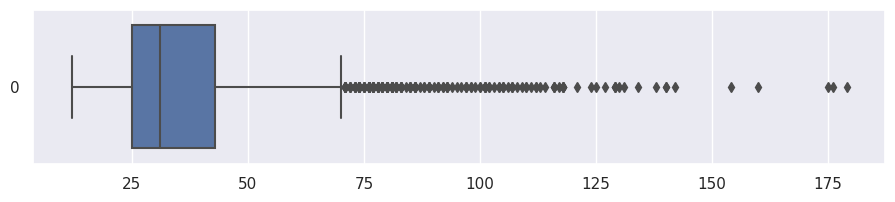

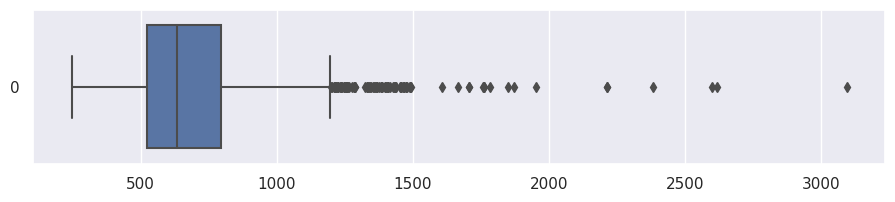

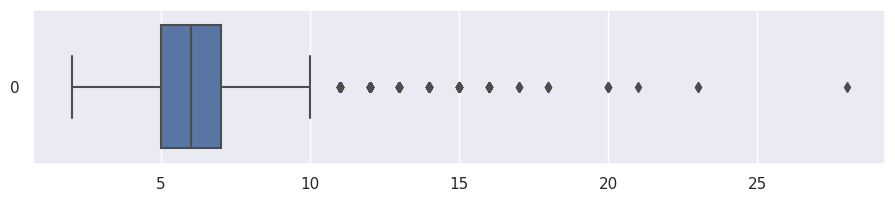

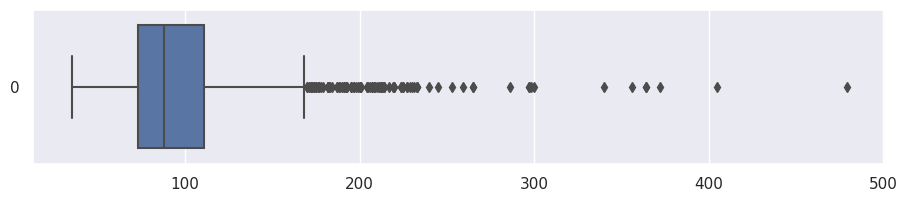

In [78]:
plotBox(df_trainL3_stat, df_validationL3_stat)

### L4: удаляем стоп слова

In [45]:
df_trainL4, df_trainL4_stat = loadJSONL(fileNameData("train_L4"), "Train set")
df_validationL4, df_validationL4_stat = loadJSONL(fileNameData("val_L4"), "Validation set")
df_testL4, df_testL4_stat  = loadJSONL(fileNameData("test_L4"), "Test set:")

Train set


question  \
0  вднх это выставочныи центр   
1  вднх это выставочныи центр   
2  джиган black star            
3  xiaomi конкурент apple       
4  автомат калашникова вов      

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            passage  \
0  выставочныи центр станция московского монорельса расположена станциями улица академика королева улица сергея эизенштеина находится территории останкинского раиона северо восточного административного округа города москвы переход станцию вднх калужско рижскои линии названа честь всероссииского выставочного центра названия вднх 1992 2014 год 20 ноября 2004 года линия монорельса начала работать экскурсионном режиме перевезла первых пассажиров                                                                                                                                                                                                                                                                                                                                                                                         
1  выставка достижении народного хозяиства 1959 1991 годах выставка достижении народного хозяиства ссср 1992 2014 годах всероссиискии выставочныи центр выставочныи комплекс останкинском раионе северо восточного административного округа города москвы второи величине выставочныи комплекс городе входит 50 крупнеиших выставочных центров мира ежегодно вднх посещают 30 млн гостеи 1 августа 2019 года выставка отпраздновала 80 летнии юбилеи территориально вднх объединена парком останкино главным ботаническим садом общая площадь составляет 700 га 240 2 га площадь вднх 75 6 га площадь парка останкино 361 га площадь гбс 9 5 га музеино выставочныи центр рабочии колхозница площадь аркои главного входа территории выставки расположено множество шедевров архитектуры 49 объектов вднх признаны памятниками культурного наследия   
2  вместе этим треком выступили церемонии вручения наград mtv rma это первыи выход джигана большую сцену 2007 году джиган стал официальным артистом леибла black star inc выпустил первыи песню клип одноклассница совместная работа тимати марте 2011 года появилась совместная юлеи савичевои композиция отпусти песня поднялась радиочарте tophit 8 места заняла первое место чарта weekly audience choice top hit количество просмотров клипа youtube превысило 17 миллионов                                                                                                                                                                                                                                                                                                                                                                      
3  xiaomi китаиская компания основанная 2010 году занимающаяся выпуском электроники бытовои техники также разработкои программного обеспечения основнои продукциеи компании являются смартфоны первыи которых выпущен 2011 году настоящее время xiaomi производит широкии ассортимент смартфонов разных ценовых сегментах является одним крупнеиших производителеи смартфонов мире третьем квартале 2014 года эта компания заняла наивысшее третье место мире поставкам смартфонов набрав 5 2 штучном выражении уступив лишь samsung apple весь 20

Stats:


label  MIN   MAX  MEAN  \
0  question(symbols)  4    162   32     
1  question(words)    1    21    4      
2  passage(symbols)   245  2656  625    
3  passage(words)     33   340   74     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    LenArray  
0  [26, 26, 17, 22, 23, 22, 22, 30, 22, 22, 43, 24, 24, 34, 34, 17, 25, 23, 13, 16, 16, 18, 15, 9, 19, 22, 27, 27, 25, 25, 26, 21, 19, 19, 15, 15, 21, 19, 19, 19, 19, 19, 19, 34, 14, 14, 14, 13, 13, 10, 15, 17, 12, 14, 14, 22, 11, 16, 16, 16, 16, 15, 15, 27, 11, 11, 28, 10, 14, 14, 14, 21, 12, 49, 49, 22, 12, 12, 12, 12, 26, 9, 9, 9, 59, 12, 12, 17, 19, 14, 17, 31, 31, 31, 18, 18, 18, 16, 13, 13, ...]                                                                                                          
1  [4, 4, 3, 3, 3, 3, 3, 4, 3, 3, 5, 3, 3, 4, 4, 2, 4, 3, 2, 2, 2, 2, 2, 2, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 7, 7, 4, 2, 2, 2, 2, 3, 2, 2, 2, 6, 2, 2, 2, 2, 2, 3, 4, 4, 4, 2, 2, 2, 2, 2, 2, ...]                                                                                                                                                                                                          
2  [442, 816, 461, 664, 607, 948, 991, 719, 460, 365, 773, 748, 524, 453, 664, 452, 505, 809, 299, 459, 523, 802, 416, 598, 433, 584, 359, 403, 643, 568, 619, 475, 678, 653, 409, 453, 824, 436, 542, 528, 508, 685, 717, 540, 676, 418, 730, 635, 488, 457, 798, 463, 472, 455, 382, 399, 749, 435, 507, 466, 468, 309, 607, 868, 276, 575, 458, 416, 846, 577, 812, 610, 425, 661, 815, 426, 728, 617, 460, 472, 840, 593, 335, 279, 624, 631, 889, 403, 644, 585, 659, 790, 434, 543, 446, 949, 527, 622, 459, 689, ...]  
3  [52, 107, 64, 83, 70, 109, 99, 95, 59, 45, 88, 76, 52, 48, 77, 64, 62, 85, 41, 60, 73, 105, 53, 73, 47, 72, 44, 52, 76, 78, 74, 56, 83, 84, 51, 59, 90, 50, 58, 63, 62, 78, 80, 71, 84, 49, 83, 81, 63, 55, 91, 53, 55, 54, 50, 49, 95, 47, 62, 58, 58, 39, 69, 107, 36, 74, 61, 54, 106, 78, 104, 69, 59, 75, 94, 56, 89, 75, 61, 66, 90, 71, 45, 41, 72, 82, 105, 56, 67, 78, 81, 87, 48, 61, 50, 117, 62, 70, 51, 77, ...]

True answer: 1061
False answer: 688

Validation set


question  \
0  вода марсе                     
1  состоит англия евросоюзе       
2  деиствительно ссср адвокатов   
3  чума оране                     
4  кетчуп читосе                  

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     passage  \
0  гидросфера марса это совокупность водных запасов планеты марс представленная водным льдом полярных шапках марса льдом поверхностью сезонными ручьями жидкои воды возможными резервуарами жидкои воды водных растворов солеи верхних слоях литосферы марса гидросфера марса вследствие господствующих низких температур марсе нахождения запасов воды твердом состоянии также называется криолитосферои основная статья история поисков воды марсе марс весьма схож землеи многим показателям заставляло ученых xix начала xx века допускать нем жизнь жидкая вода мере роста объема данных планете собранных различными методами например помощью спектроскопических измерении стало понятно воды атмосфере марса ничтожно малое количество однако присутствует прежде внимание исследователеи привлекли полярные шапки марса предполагалось могут состоять водного льда аналогии антарктидои гренландиеи земле однако высказывалась гипотеза это твердыи диоксид углерода                                                                                                  
1  полночь 31 января 1 февраля 2020 года центральноевропеискому времени 47 лет членства великобритания официально покинула евросоюз европеискии союз входят 27 государств количество стран участвующих союзе выросло начальных шести бельгии западнои германии италии люксембурга нидерландов франции сегодняшних 27 путем последовательных расширении присоединяясь договорам страны ограничивали свои суверенитет обмен представительство институтах союза деиствующих общих интересах вступления европеискии союз страна кандидат должна соответствовать копенгагенским критериям принятым июне 1993 года заседании европеиского совета копенгагене утвержденным декабре 1995 года заседании европеиского совета мадриде критерии требуют государстве соблюдались демократические принципы принципы свободы уважения прав человека также принцип правового государства также стране должна присутствовать конкурентоспособная рыночная экономика должны признаваться общие правила стандарты ес включая приверженность целям политического экономического валютного союза   
2  семен львович ария советскии россиискии юрист крупнеиших советских адвокатов заслуженныи юрист рсфср родился евреискои семье детство провел украине г харькове окончания среднеи школы течение года учился мостовом факультете новосибирского института военных инженеров транспорта начале великои отечественнои воины призван красную армию харькове окончив курсы 19 го учебного танкового полка нижнем тагиле стал механиком водителем танка затем разведчиком дивизиона гвардеиских минометов участвовал боевых деиствиях северном кавказе кубани украине болгарии венгрии австрии старшии сержант                                                                                                          

Stats:


label  MIN   MAX  MEAN  \
0  question(symbols)  4    77    23     
1  question(words)    1    9     3      
2  passage(symbols)   210  1277  591    
3  passage(words)     29   139   70     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       LenArray  
0  [10, 24, 28, 10, 13, 16, 9, 16, 12, 22, 65, 29, 31, 36, 16, 57, 43, 34, 20, 23, 13, 17, 33, 16, 20, 33, 23, 15, 13, 27, 28, 18, 40, 28, 17, 24, 23, 30, 12, 33, 25, 20, 21, 9, 11, 12, 6, 22, 32, 15, 36, 23, 18, 16, 30, 19, 45, 34, 15, 18, 30, 31, 77, 17, 16, 15, 22, 14, 37, 23, 19, 32, 13, 21, 9, 29, 27, 11, 10, 28, 16, 27, 11, 25, 28, 38, 12, 28, 18, 26, 19, 42, 30, 22, 21, 26, 21, 42, 30, 22, ...]                                                                                                             
1  [2, 3, 3, 2, 2, 2, 2, 2, 2, 3, 6, 4, 4, 5, 3, 6, 5, 4, 3, 3, 2, 3, 5, 3, 2, 4, 3, 2, 2, 5, 3, 2, 5, 2, 3, 3, 3, 4, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 5, 2, 5, 3, 3, 3, 5, 3, 5, 4, 2, 3, 3, 5, 9, 3, 2, 2, 3, 3, 5, 3, 3, 3, 2, 3, 2, 4, 4, 2, 2, 4, 2, 4, 2, 3, 4, 5, 2, 4, 3, 3, 3, 6, 5, 3, 3, 3, 3, 4, 3, 4, ...]                                                                                                                                                                                                             
2  [938, 1033, 583, 603, 842, 469, 827, 487, 1119, 408, 502, 474, 514, 695, 547, 913, 524, 525, 622, 574, 636, 418, 486, 417, 527, 366, 488, 425, 736, 447, 636, 517, 275, 693, 464, 670, 893, 559, 503, 423, 545, 980, 643, 570, 625, 715, 428, 632, 526, 560, 686, 712, 656, 652, 319, 393, 688, 615, 641, 556, 684, 1068, 498, 488, 806, 657, 433, 704, 345, 524, 524, 735, 685, 648, 354, 596, 349, 418, 578, 457, 816, 351, 372, 418, 552, 570, 444, 942, 402, 739, 466, 783, 740, 728, 527, 484, 895, 424, 387, 700, ...]  
3  [114, 113, 71, 68, 121, 55, 99, 61, 133, 52, 57, 61, 60, 81, 58, 92, 62, 65, 77, 72, 80, 50, 62, 57, 60, 43, 57, 54, 89, 58, 68, 59, 37, 78, 68, 73, 93, 68, 65, 44, 63, 103, 78, 70, 75, 100, 55, 73, 58, 71, 72, 90, 84, 79, 44, 50, 75, 68, 68, 65, 88, 116, 58, 56, 101, 78, 55, 75, 41, 62, 69, 95, 76, 77, 44, 80, 52, 66, 82, 62, 100, 41, 47, 46, 66, 73, 59, 111, 46, 87, 61, 92, 89, 84, 63, 62, 96, 49, 48, 83, ...]

True answer: 412
False answer: 409

Test set:


question  \
0  полезна ртуть градусника       
1  являются сапрофаги хищниками   
2  водятся индии крокодилы        
3  батате крахмал                 
4  человек железнои маске         

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        passage  \
0  отравления ртутью расстроиства здоровья связанные избыточным поступлением паров соединении ртути организм токсические своиства ртути известны глубокои древности соединения ртути киноварь каломель сулема применялись разных целеи числе качестве ядов древних времен известна также металлическая ртуть хотя токсичность поначалу сильно недооценивалась ртуть соединения стали особенно широко применяться средние века частности производстве золота серебряных зеркал также изготовлении фетра шляп вызвало поток новых профессиональных отравлении                                                                                                                                                       
1  фауна лесных почв совокупность видов животных которых лесная почва является средои обитания часть леснои фауны животных обитающих почве зависимости размеров особеи относят следующим группам макрофауна основном мелкие млекопитающие числе землероики кроты мезофауна представляют дождевые черви многоножки мокрицы насекомые личинки микрофауна нематоды энхитреиды клещи основном панцирные клещи ногохвостки другие нанофауна это одноклеточные простеишие любых лесах среди беспозвоночных почв преобладают сапрофаги которые питаются лесным опадом грибницеи гниющеи древесинои                                                                                                                       
2  болотныи крокодил магер пресмыкающееся семеиства настоящих крокодилов обитающее территории индостана прилегающих стран таких пакистан это трех обитающих индии крокодилов наряду гавиалом гребнистым крокодилом ближаишии современныи родственник болотного крокодила сиамскии крокодил вместе гребнистым крокодилом образуют обособленную азиатскую кладу болотного крокодила грубая голова гребнеи выростов чешуичатых костеи тяжелые широкие челюсти длина которых превышает ширину основания 1 3 2 5 раза четыре большие пластины шее образуют квадрат меньшими размерам пластинами каждои стороне                                                                                                         
3  клубневидно вздутые корни весят 15 кг содержат 20 40 крахмала растение широко культивируется тропических регионах например африке пищу идет похожии картофелину корнеплод которыи достигать 8 см диаметре 1 м длину масса 3 10 кг корнеплодах крахмала сыром виде корнеплоды очень ядовиты употребляются вареными печеными                                                                                                                                                                                                                                                                                                                                                                                     
4  остров сент маргерит крупнеишии леринских островов расположен расстоянии менее километра города французскои ривьеры канны длина острова востока запад около 3 км ширина 900 м наиболее известныи объект острова форт тюрьма которои xvii веке содержался человек железнои маске первые упоминания острове необитаемом относятся ко временам древнего рима остров н

Stats:


label  MIN   MAX  MEAN  \
0  question(symbols)  5    91    25     
1  question(words)    1    10    3      
2  passage(symbols)   222  1084  570    
3  passage(words)     29   133   67     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    LenArray  
0  [24, 28, 23, 14, 22, 26, 32, 20, 21, 14, 27, 34, 20, 28, 66, 47, 43, 23, 12, 54, 39, 9, 13, 32, 28, 12, 50, 21, 14, 31, 54, 14, 15, 48, 22, 26, 26, 25, 22, 26, 21, 18, 36, 19, 31, 24, 12, 19, 24, 14, 33, 26, 20, 19, 31, 35, 26, 14, 22, 10, 26, 9, 20, 36, 12, 34, 41, 22, 20, 28, 14, 39, 59, 20, 9, 42, 16, 15, 42, 23, 22, 31, 10, 47, 51, 23, 23, 20, 29, 46, 64, 26, 44, 35, 23, 19, 22, 17, 15, 11, ...]                                                                                                         
1  [3, 3, 3, 2, 3, 4, 4, 3, 3, 2, 4, 4, 3, 3, 8, 5, 5, 4, 2, 6, 4, 2, 2, 4, 4, 2, 5, 3, 2, 5, 6, 2, 2, 6, 3, 3, 4, 3, 3, 4, 3, 2, 4, 3, 4, 3, 2, 3, 4, 2, 4, 3, 3, 3, 4, 4, 3, 2, 3, 2, 3, 1, 3, 5, 2, 4, 6, 3, 3, 3, 2, 4, 5, 3, 2, 6, 2, 2, 5, 3, 3, 4, 1, 5, 7, 4, 3, 3, 3, 6, 8, 4, 5, 5, 4, 3, 4, 3, 2, 2, ...]                                                                                                                                                                                                          
2  [536, 568, 582, 314, 684, 753, 478, 392, 380, 267, 505, 368, 398, 474, 600, 423, 573, 549, 634, 633, 793, 576, 419, 660, 549, 540, 673, 688, 584, 357, 292, 652, 662, 446, 605, 342, 326, 694, 695, 576, 635, 438, 707, 927, 506, 420, 421, 721, 522, 663, 487, 873, 843, 507, 640, 788, 801, 644, 364, 702, 482, 886, 706, 724, 280, 632, 516, 697, 737, 640, 356, 594, 461, 551, 266, 365, 537, 391, 557, 415, 459, 506, 812, 693, 363, 463, 456, 825, 577, 490, 463, 394, 403, 740, 784, 628, 295, 355, 390, 444, ...]  
3  [61, 66, 69, 44, 85, 92, 60, 49, 50, 33, 63, 46, 45, 58, 74, 49, 68, 64, 68, 78, 79, 68, 58, 88, 68, 67, 75, 86, 71, 47, 35, 72, 74, 52, 61, 40, 45, 73, 81, 63, 81, 49, 87, 101, 64, 52, 46, 85, 64, 74, 52, 122, 93, 64, 69, 88, 97, 89, 45, 79, 51, 97, 78, 78, 38, 78, 68, 79, 76, 71, 47, 65, 53, 66, 35, 46, 64, 53, 53, 53, 49, 58, 104, 78, 50, 53, 55, 98, 66, 59, 57, 46, 52, 88, 86, 73, 47, 47, 50, 57, ...]

SYMBOL QUESTION MIN: 4 MAX: 162 MEAN: 29.564980544747083
SYMBOL CONTEXT MIN: 210 MAX: 2656 MEAN: 614.7953307392996
WORD QUESTION MIN: 1 MAX: 21 MEAN: 3.7575875486381323
WORD CONTEXT MIN: 29 MAX: 340 MEAN: 72.9147859922179


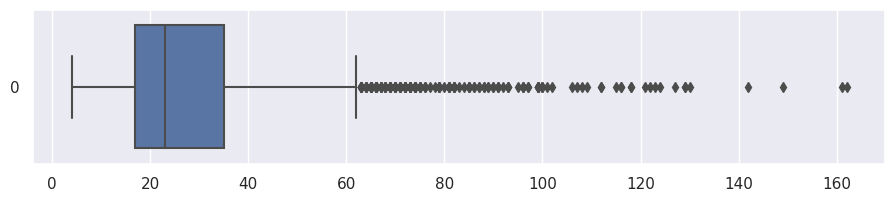

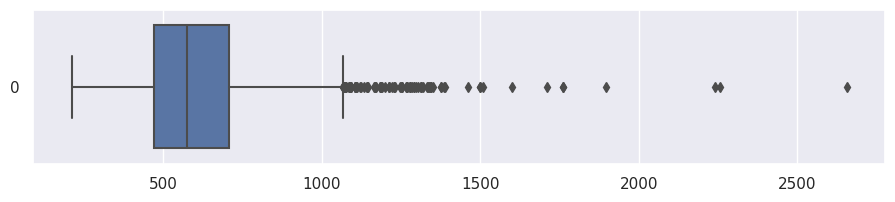

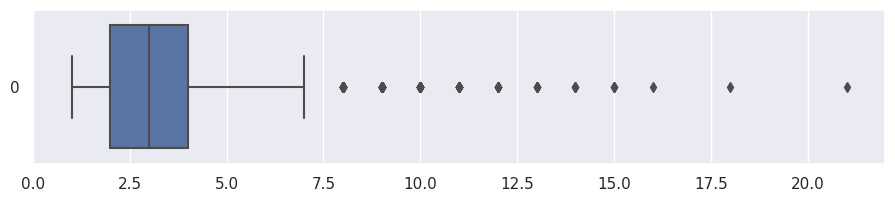

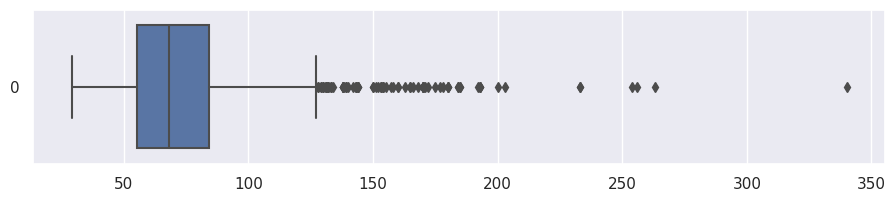

In [81]:
plotBox(df_trainL4_stat, df_validationL4_stat)

### L5: стемминг

In [55]:
df_trainL5, df_trainL5_stat = loadJSONL(fileNameData("train_L5"), "Train set")
df_validationL5, df_validationL5_stat = loadJSONL(fileNameData("val_L5"), "Validation set")
df_testL5, df_testL5_stat = loadJSONL(fileNameData("test_L5"), "Test set:")

Train set


question  \
0  вднх эт выставочны центр          
1  вднх эт выставочны центр          
2  был ли джига в black star         
3  xiaomi конкурент apple            
4  был ли автомат калашников в вов   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            passage  \
0  выставочны центр станц московск монорельс располож межд станц улиц академик королев и улиц серге эизенштеин наход на территор останкинск раион север восточн административн округ город москв переход на станц вднх калужск рижско лин назва в чест всероссииск выставочн центр назван вднх с 1992 по 2014 год 20 ноябр 2004 год лин монорельс нача работа в экскурсион режим и перевезл перв пассажир                                                                                                                                                                                                                                                                                                                                                             
1  выставк достижен народн хозяиств в 1959 1991 год выставк достижен народн хозяиств ссср в 1992 2014 год всероссииск выставочны центр выставочны комплекс в останкинск раион север восточн административн округ город москв второ по величин выставочны комплекс в город вход в 50 крупнеиш выставочн центр мир ежегодн вднх посеща 30 млн гост 1 август 2019 год выставк отпразднова 80 летн юбил территориальн вднх объедин с парк останкин и главн ботаническ сад их общ площад составля почт 700 га 240 2 га площад вднх 75 6 га площад парк останкин 361 га площад гбс 9 5 га музеин выставочны центр рабоч и колхозниц и площад перед арко главн вход на территор выставк располож множеств шедевр архитектур 49 объект вднх призна памятник культурн наслед   
2  вмест с эт трек он выступ на церемон вручен наград mtv rma эт был первы выход джига на больш сцен в 2007 год джига стал официальн артист леибл black star inc выпуст первы песн и клип одноклассниц совместн работ с тимат в март 2011 год появ совместн с юл савичево композиц отпуст песн подня в радиочарт tophit до 8 мест и заня перв мест чарт weekly audience choice top hit количеств просмотр клип на youtube превыс 17 миллион                                                                                                                                                                                                                                                                                                                           
3  xiaomi китаиск компан основа в 2010 год и занима выпуск электроник и бытово техник а такж разработко программн обеспечен основно продукц компан явля смартфон первы из котор был выпущ в 2011 год в настоя врем xiaomi производ широк ассортимент смартфон в разн ценов сегмент и явля одн из крупнеиш производител смартфон в мир так в трет квартал 2014 год эт компан заня наивысш для себ трет мест в мир по поставк смартфон набра 5 2 в штучн выражен и уступ лиш samsung и apple за ве 2017 год компан заня по продаж перв мест в кита и втор мест в инд в дан списк привод все смартфон когд либ выпущен компан xiaomi                                                                                                                                     
4  отмет некотор недостатк и в цел удачн конструкц специалист га не рекомендова пр

Stats:


label  MIN   MAX  MEAN  \
0  question(symbols)  10   151   34     
1  question(words)    2    28    6      
2  passage(symbols)   237  2508  584    
3  passage(words)     40   479   98     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    LenArray  
0  [24, 24, 25, 22, 31, 29, 29, 35, 27, 27, 37, 25, 25, 36, 36, 25, 24, 32, 19, 21, 21, 27, 22, 15, 26, 29, 32, 32, 29, 29, 33, 27, 25, 25, 20, 20, 27, 23, 23, 23, 23, 23, 23, 38, 21, 21, 21, 19, 19, 18, 21, 22, 19, 21, 21, 25, 18, 22, 22, 22, 22, 21, 21, 32, 18, 18, 32, 17, 21, 21, 21, 26, 20, 47, 47, 29, 19, 19, 19, 19, 24, 16, 16, 16, 58, 19, 19, 24, 26, 21, 23, 32, 32, 32, 25, 25, 25, 23, 20, 19, ...]                                                                                                      
1  [4, 4, 6, 3, 6, 6, 6, 7, 6, 6, 7, 5, 5, 6, 6, 5, 6, 7, 5, 5, 5, 5, 5, 4, 7, 6, 6, 6, 6, 6, 8, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 6, 6, 6, 5, 5, 6, 5, 5, 5, 5, 6, 5, 10, 10, 8, 5, 5, 5, 5, 4, 5, 5, 5, 9, 5, 5, 5, 5, 5, 6, 7, 7, 7, 5, 5, 5, 5, 5, 5, ...]                                                                                                                                                                                                        
2  [390, 736, 424, 606, 572, 889, 857, 677, 445, 334, 671, 704, 470, 391, 597, 413, 457, 779, 310, 442, 493, 781, 380, 558, 379, 572, 331, 377, 618, 570, 546, 429, 612, 613, 421, 435, 769, 401, 484, 479, 469, 643, 635, 514, 632, 385, 679, 570, 442, 429, 728, 413, 459, 422, 353, 410, 666, 385, 506, 434, 429, 326, 616, 840, 252, 522, 448, 414, 776, 541, 743, 563, 398, 599, 774, 397, 679, 572, 443, 444, 742, 556, 344, 273, 590, 599, 849, 387, 544, 581, 592, 749, 381, 514, 420, 887, 516, 571, 410, 637, ...]  
3  [61, 121, 78, 112, 91, 141, 122, 122, 84, 58, 112, 99, 66, 59, 97, 79, 79, 120, 65, 83, 94, 140, 70, 94, 55, 95, 59, 67, 107, 114, 92, 59, 106, 112, 76, 86, 122, 63, 76, 82, 83, 106, 104, 87, 112, 64, 111, 102, 84, 75, 120, 66, 81, 71, 63, 76, 117, 57, 99, 78, 77, 64, 109, 143, 47, 89, 86, 78, 133, 101, 133, 92, 76, 94, 138, 74, 116, 101, 80, 88, 112, 98, 66, 58, 101, 110, 144, 73, 80, 111, 103, 113, 59, 81, 69, 153, 89, 89, 64, 104, ...]

True answer: 1061
False answer: 688

Validation set


question  \
0  ест ли вод на марс                      
1  состо ли англ в евросоюз                
2  деиствительн ли в ссср не был адвокат   
3  был ли чум в оран                       
4  был ли кетчуп в читос                   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       passage  \
0  гидросфер марс эт совокупн водн запас планет марс представлен водн льдом в полярн шапк марс льдом над поверхн сезон руч из жидко вод и возможн резервуар жидко вод и водн раствор сол в верхн сло литосфер марс гидросфер марс вследств господств низк температур на марс и нахожден запас вод в тверд состоян такж называ криолитосферо основн стат истор поиск вод на марс марс весьм схож с земл по мног показател что заставля учен xix нача xx век допуска что на нем ест жизн и ест жидк вод по мер рост объем дан о планет собра различн метод например с помощ спектроскопическ измерен стал понятн что вод в атмосфер марс ничтожн мал количеств однак он все же присутств прежд всег вниман исследовател привлекл полярн шапк марс так как предполага что он могут состоя из водн льда по аналог с антарктидо ил гренланд на земл однак высказыва и гипотез что эт тверды диоксид углерод                                                                           
1  в полноч с 31 январ на 1 феврал 2020 год по центральноевропеиск времен посл 47 лет членств великобритан официальн покинул евросоюз в европеиск союз вход 27 государств количеств стран участв в союз выросл с начальн шест бельг западно герман итал люксембург нидерланд и франц до сегодняшн 27 пут последовательн расширен присоедин к договор стран ограничива сво суверенитет в обм на представительств в институт союз деиств в общ интерес для вступлен в европеиск союз стран кандидат должн соответствова копенгагенск критер принят в июн 1993 год на заседан европеиск совет в копенгаген и утвержден в декабр 1995 год на заседан европеиск совет в мадрид критер треб чтоб в государств соблюда демократическ принцип принцип свобод и уважен прав человек а такж принцип правов государств такж в стран должн присутствова конкурентоспособн рыночн экономик и должн признава общ прав и стандарт ес включ привержен цел политическ экономическ и валютн союз   
2  сем львович ар советск и россииск юрист один из крупнеиш советск адвокат заслуженны юрист рсфср род в евреиско сем детств провел на украин в г харьков посл окончан средн школ в течен год уч на мостов факультет новосибирск институт воен инженер транспорт в начал велико отечественно воин был призва в красн арм в харьков оконч курс 19 го учебн танков полк в нижн тагил стал механик водител танк зат разведчик дивизион гвардеиск миномет участвова в боев деиств на северн кавказ кубан украин в болгар венгр австр старш сержант                                                                                                                                                                                                                                                                                                                                                                                                                   

Stats:


label  MIN   MAX  MEAN  \
0  question(symbols)  12   76    27     
1  question(words)    2    15    5      
2  passage(symbols)   203  1182  545    
3  passage(words)     35   182   91     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     LenArray  
0  [18, 24, 37, 17, 21, 25, 16, 24, 17, 27, 59, 30, 35, 33, 14, 53, 45, 45, 29, 29, 20, 19, 35, 13, 28, 30, 36, 20, 20, 29, 27, 25, 44, 31, 25, 22, 20, 34, 17, 32, 24, 34, 22, 16, 16, 18, 14, 27, 35, 20, 44, 22, 26, 17, 34, 23, 46, 32, 21, 31, 27, 40, 76, 14, 23, 21, 24, 16, 36, 25, 32, 38, 19, 21, 16, 30, 36, 14, 16, 34, 24, 36, 19, 22, 36, 36, 18, 27, 18, 33, 20, 48, 31, 21, 24, 26, 25, 36, 30, 34, ...]                                                                                                       
1  [5, 5, 7, 5, 5, 5, 5, 5, 4, 6, 8, 6, 7, 8, 4, 9, 8, 9, 7, 6, 5, 5, 8, 3, 5, 6, 8, 4, 5, 7, 5, 5, 9, 5, 6, 4, 3, 7, 4, 5, 5, 8, 3, 4, 4, 5, 5, 5, 8, 4, 10, 5, 6, 5, 8, 5, 9, 6, 5, 8, 4, 9, 15, 3, 5, 4, 5, 5, 8, 5, 7, 7, 4, 5, 4, 6, 8, 4, 4, 7, 5, 8, 5, 4, 8, 6, 5, 6, 5, 7, 5, 11, 7, 4, 6, 4, 6, 6, 4, 9, ...]                                                                                                                                                                                                        
2  [867, 939, 523, 564, 784, 496, 735, 476, 1065, 402, 457, 415, 444, 614, 486, 815, 471, 499, 595, 515, 592, 401, 455, 404, 485, 340, 469, 436, 692, 415, 600, 474, 253, 641, 420, 598, 819, 530, 489, 375, 496, 898, 583, 531, 572, 688, 358, 595, 477, 556, 639, 668, 628, 583, 294, 383, 614, 555, 606, 519, 629, 986, 431, 478, 763, 593, 405, 632, 304, 471, 481, 695, 615, 576, 334, 582, 327, 402, 542, 467, 809, 335, 376, 365, 484, 543, 413, 856, 378, 691, 450, 749, 657, 689, 501, 458, 815, 412, 381, 653, ...]  
3  [152, 145, 88, 96, 144, 89, 126, 81, 182, 75, 77, 68, 77, 97, 74, 120, 75, 88, 103, 84, 100, 68, 80, 73, 74, 58, 79, 81, 114, 74, 97, 76, 47, 99, 82, 96, 128, 96, 92, 56, 87, 138, 96, 92, 99, 134, 63, 94, 80, 100, 92, 110, 103, 96, 47, 66, 89, 85, 98, 89, 113, 149, 73, 82, 138, 94, 71, 102, 53, 75, 82, 119, 94, 93, 63, 113, 63, 87, 105, 88, 145, 63, 68, 54, 85, 103, 78, 143, 67, 115, 81, 125, 112, 113, 88, 88, 129, 66, 69, 112, ...]

True answer: 412
False answer: 409

Test set:


question  \
0  полезн ли ртут с градусник      
1  явля ли сапрофаг хищник         
2  вод ли в инд крокодил           
3  ест ли в батат крахма           
4  был ли человек в железно маск   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    passage  \
0  отравлен ртут расстроиств здоров связа с избыточн поступлен пар ил соединен ртут в организм токсическ своиств ртут известн с глубоко древност соединен ртут киновар каломел и сулем применя для разн цел в том числ и в качеств яд с древн врем известн такж и металлическ ртут хот е токсичн поначал сильн недооценива ртут и е соединен стал особен широк применя в средн век в частност при производств золот и серебрян зерка а такж при изготовлен фетр для шляп что вызва поток нов уж профессиональн отравлен                                                                                                                       
1  фаун лесн почв совокупн вид животн для котор лесн почв явля средо обитан част лесно фаун животн обита в почв в зависим от размер особ относ к след групп макрофаун в основн мелк млекопита в том числ землероик крот мезофаун е представля дождев черв многоножк мокриц насеком их личинк микрофаун нематод энхитреид клещ в основн панцирн клещ ногохвостк и друг нанофаун эт одноклеточн простеиш в люб лес сред беспозвоночн почв преоблада сапрофаг котор пита лесн опад грибниц гниющ древесино                                                                                                                                       
2  болотны крокод ил магер пресмыка из семеиств настоя крокодил обита на территор индоста и прилега стран так как пакиста эт один из трех обита в инд крокодил наряд с гавиал и гребнист крокодил ближаиш современны родственник болотн крокод сиамск крокод вмест с гребнист крокодил он образ обособлен азиатск клад у болотн крокод груб голов без гребн ил вырост чешуичат кост тяжел и широк челюст длин котор превыша ширин у основан в 1 3 2 5 раз четыр больш пластин на ше образ квадрат с меньш по размер пластин на каждо сторон                                                                                                   
3  клубневидн вздут корн вес до 15 кг содержат 20 40 крахма растен широк культивир в тропическ регион например в африк в пищ идет похож на картофелин корнеплод которы может достига 8 см в диаметр и 1 м в длин масс от 3 до 10 кг в корнеплод мног крахма в сыр вид корнеплод очен ядовит и употребля тольк варен ил печен                                                                                                                                                                                                                                                                                                                  
4  остр сент маргер крупнеиш из леринск остров располож на расстоян мен километр от город французско ривьер кан длин остров с восток на запад окол 3 км ширин 900 м наибол известны объект остров форт тюрьм в которо в xvii век содержа человек в железно маск перв упоминан об остров тогд ещ необита относ ко времен древн рим когд остр нос назван лер вероятн современ назван остров дал крестоносц котор постро на остров часовн свято маргарит антиохииско в xiv столет вероятн благодар сочинен раимонд фер остр стал ассоциирова с вымышленно свято маргер сестро гонорат арелатск основател монастыр на близлежа остров сент онор   

   idx  
0  0    
1  1    
2  2    
3  3    
4  4

Stats:


label  MIN   MAX  MEAN  \
0  question(symbols)  12   79    27     
1  question(words)    3    14    5      
2  passage(symbols)   191  1012  526    
3  passage(words)     34   158   88     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    LenArray  
0  [26, 23, 21, 21, 29, 25, 34, 27, 29, 20, 28, 44, 19, 32, 66, 50, 38, 25, 20, 49, 41, 17, 24, 33, 26, 19, 47, 29, 20, 34, 49, 21, 20, 39, 23, 30, 30, 26, 22, 27, 27, 17, 39, 18, 24, 21, 18, 19, 29, 21, 39, 29, 23, 25, 28, 32, 26, 22, 28, 16, 26, 17, 24, 39, 19, 38, 46, 28, 29, 25, 22, 35, 55, 26, 17, 39, 22, 19, 50, 23, 22, 28, 18, 45, 54, 30, 24, 21, 29, 47, 56, 25, 47, 39, 24, 25, 35, 17, 21, 19, ...]                                                                                                      
1  [5, 4, 5, 5, 6, 6, 6, 6, 6, 5, 6, 9, 4, 5, 12, 8, 7, 7, 5, 8, 7, 5, 6, 6, 6, 5, 7, 6, 5, 9, 8, 5, 5, 6, 5, 5, 7, 5, 5, 6, 6, 4, 7, 5, 5, 4, 5, 5, 7, 5, 9, 6, 5, 6, 5, 5, 5, 5, 6, 5, 4, 4, 5, 8, 5, 7, 9, 6, 7, 4, 5, 6, 7, 6, 5, 9, 5, 5, 10, 5, 4, 6, 4, 7, 10, 8, 5, 5, 5, 8, 11, 6, 8, 8, 6, 6, 10, 5, 5, 5, ...]                                                                                                                                                                                                     
2  [500, 484, 520, 313, 616, 664, 439, 364, 374, 252, 522, 357, 380, 433, 553, 384, 528, 511, 567, 602, 699, 520, 415, 597, 503, 526, 637, 608, 532, 317, 249, 600, 568, 429, 510, 305, 299, 665, 614, 535, 589, 393, 636, 839, 484, 371, 371, 658, 482, 637, 462, 776, 800, 472, 554, 712, 698, 593, 317, 605, 459, 839, 665, 654, 260, 583, 483, 657, 637, 606, 339, 549, 436, 508, 269, 326, 497, 371, 519, 353, 394, 465, 743, 624, 333, 413, 419, 777, 610, 453, 427, 358, 377, 673, 744, 579, 302, 309, 370, 390, ...]  
3  [85, 79, 91, 61, 101, 115, 80, 60, 65, 39, 96, 65, 61, 72, 99, 59, 89, 89, 80, 105, 92, 85, 85, 108, 93, 92, 99, 105, 92, 57, 39, 95, 84, 69, 74, 54, 55, 104, 97, 83, 103, 65, 110, 133, 87, 64, 52, 109, 84, 110, 74, 144, 134, 86, 81, 114, 117, 100, 54, 95, 72, 137, 103, 104, 49, 104, 84, 105, 98, 95, 56, 90, 69, 89, 56, 59, 88, 67, 66, 59, 55, 75, 133, 105, 62, 71, 69, 132, 110, 74, 76, 60, 67, 108, 119, 93, 69, 59, 68, 66, ...]

SYMBOL QUESTION MIN: 10 MAX: 151 MEAN: 32.052140077821015
SYMBOL CONTEXT MIN: 203 MAX: 2508 MEAN: 571.8941634241245
WORD QUESTION MIN: 2 MAX: 28 MEAN: 6.3116731517509725
WORD CONTEXT MIN: 35 MAX: 479 MEAN: 96.26070038910505


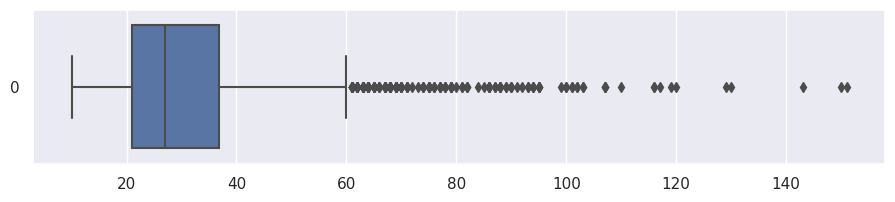

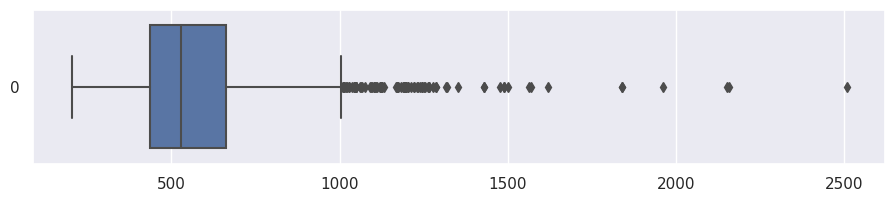

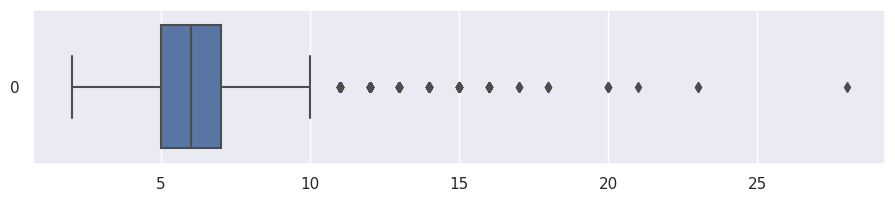

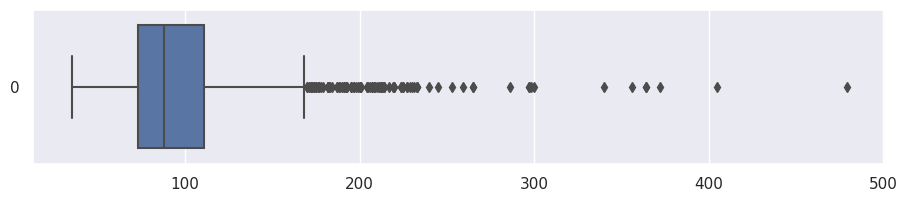

In [84]:
plotBox(df_trainL5_stat, df_validationL5_stat)

### Общая таблица изменения длины

In [10]:
df_trainL0_stat['label'] += " L0"
df_trainL1_stat['label'] += " L1"
df_trainL2_stat['label'] += " L2"
df_trainL3_stat['label'] += " L3"
df_trainL4_stat['label'] += " L4"
df_trainL5_stat['label'] += " L5"

df_testL0_stat['label'] += " L0"
df_testL1_stat['label'] += " L1"
df_testL2_stat['label'] += " L2"
df_testL3_stat['label'] += " L3"
df_testL4_stat['label'] += " L4"
df_testL5_stat['label'] += " L5"

df_validationL0_stat['label'] += " L0"
df_validationL1_stat['label'] += " L1"
df_validationL2_stat['label'] += " L2"
df_validationL3_stat['label'] += " L3"
df_validationL4_stat['label'] += " L4"
df_validationL5_stat['label'] += " L5"

In [11]:
pd.concat(
    [df_trainL0_stat, df_trainL1_stat, df_trainL2_stat, df_trainL3_stat, df_trainL4_stat, df_trainL5_stat], 
    ignore_index=True
).sort_values(
    'label', 
    ascending=True
).set_index('label')

MIN   MAX  MEAN
label                                
passage(symbols) L0   294  3200  723 
passage(symbols) L1   293  3200  722 
passage(symbols) L2   293  3200  722 
passage(symbols) L3   271  3095  701 
passage(symbols) L4   245  2656  625 
passage(symbols) L5   211  2104  512 
passage(words) L0     48   587   115 
passage(words) L1     48   587   115 
passage(words) L2     48   587   115 
passage(words) L3     40   479   98  
passage(words) L4     33   340   74  
passage(words) L5     33   340   74  
question(symbols) L0  14   182   41  
question(symbols) L1  14   182   41  
question(symbols) L2  14   182   41  
question(symbols) L3  13   179   40  
question(symbols) L4  4    162   32  
question(symbols) L5  3    133   26  
question(words) L0    3    30    7   
question(words) L1    3    30    7   
question(words) L2    3    30    7   
question(words) L3    2    28    6   
question(words) L4    1    21    4   
question(words) L5    1    21    4

In [21]:
df_stat = pd.DataFrame([  ["L0: исходные данные", df_trainL0['passage'][0], df_trainL0['question'][0]],
                ["L1: юникод символы удалены", df_trainL1['passage'][0], df_trainL1['question'][0]],
                ["L2: переведено в нижний регистр", df_trainL2['passage'][0], df_trainL2['question'][0]],
                ["L3: удалены знаки препинания", df_trainL3['passage'][0], df_trainL3['question'][0]],
                ["L4: удалены стоп слова", df_trainL4['passage'][0], df_trainL4['question'][0]],
                ["L5: леммитизация", df_trainL5['passage'][0], df_trainL5['question'][0]]
            ],
            columns=['L:info', 'passage', 'question']
        ).set_index('L:info')
left_aligned_df = df_stat.style.set_properties(**{'text-align': 'left'})
left_aligned_df = left_aligned_df.set_table_styles(
[dict(selector = 'th', props=[('text-align', 'left')])])
display(left_aligned_df)

## Universal-Sentence-Encoder

In [3]:
def fileNameCorrelationData(s):
    return f"{os.path.join(data_path, 'semantic_corr', s)}.jsonl"

In [ ]:
%pip install tensorflow_text

In [4]:
from absl import logging
import tensorflow_text
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

2022-11-06 20:25:27.398452: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-06 20:25:27.730059: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-06 20:25:27.853533: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-06 20:25:28.812973: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

module https://tfhub.dev/google/universal-sentence-encoder-multilingual/3 loaded


In [5]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, message_embeddings_, 90)

In [6]:
def getDfCorrelation(dataset_name):
    df = loadJSONL(fileNameData(dataset_name))[0]
    corr_list = []
    #embed_list = []
    for iStep in range(len(df)):
        print(iStep)
        message_embeddings_ = embed([df.question[iStep], df.passage[iStep]])

        corr_list.append(np.inner(message_embeddings_[0], message_embeddings_[1]))
        #embed_list.append(message_embeddings_)

    #stat = pd.DataFrame(corr_list, [embed_list]], columns=['correlation', 'embed_list'])
    stat = pd.DataFrame(corr_list, columns=['correlation'])
    stat.to_json(fileNameCorrelationData(dataset_name), lines=True, orient='records')

    return stat 

### L0 Correlation

In [ ]:
corr_trainL0 = getDfCorrelation("train_L0")
corr_validationL0 = getDfCorrelation("val_L0")

### L1 Correlation

In [ ]:
corr_trainL1 = getDfCorrelation("train_L1")
corr_validationL1 = getDfCorrelation("val_L1")

### L2 Correlation

In [ ]:
corr_trainL2 = getDfCorrelation("train_L2")
corr_validationL2 = getDfCorrelation("val_L2")

### L3 Correlation

In [ ]:
corr_trainL3 = getDfCorrelation("train_L3")
corr_validationL3 = getDfCorrelation("val_L3")

### L4 Correlation

In [ ]:
corr_trainL4 = getDfCorrelation("train_L4")
corr_validationL4 = getDfCorrelation("val_L4")

### L5 Correlation

In [ ]:
corr_trainL5 = getDfCorrelation("train_L5")
corr_validationL5 = getDfCorrelation("val_L5")

### Plot

(-0.1, 0.85)

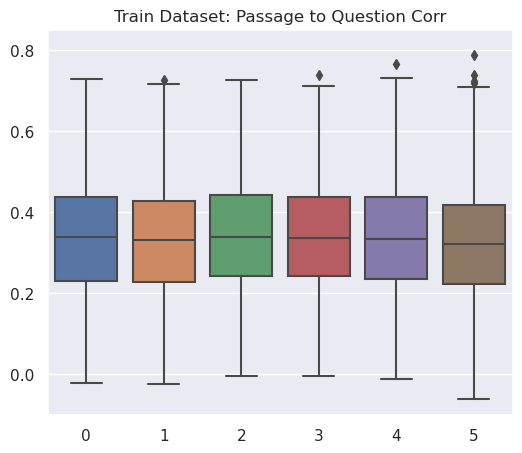

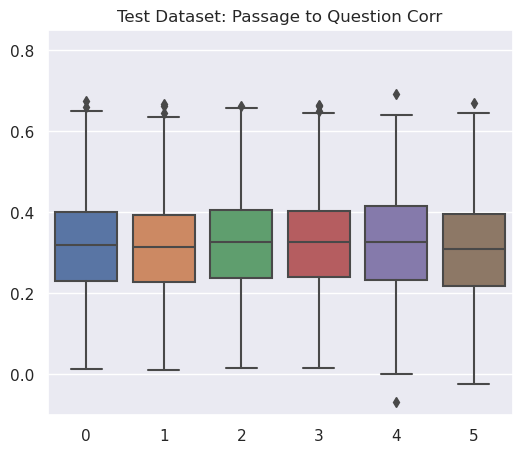

In [39]:
plt.figure(figsize = (6, 5))
ax = sns.boxplot([corr_trainL0, corr_trainL1, corr_trainL2, corr_trainL3, corr_trainL4, corr_trainL5])
ax.set_ylim(-0.1, 0.85)
ax.set_title("Train Dataset: Passage to Question Corr")
plt.figure(figsize = (6, 5))
ax = sns.boxplot([corr_validationL0, corr_validationL1, corr_validationL2, corr_validationL3, corr_validationL4, corr_validationL5])
ax.set_title("Test Dataset: Passage to Question Corr")
ax.set_ylim(-0.1, 0.85)

#### Выбросы

In [54]:
corr_trainL5.correlation[np.where(corr_trainL5 < 0)[0]]

189    -0.027256
507    -0.042194
602    -0.002906
929    -0.061602
1158   -0.013959
Name: correlation, dtype: float32

In [59]:
df_trainL5.passage[929], df_trainL5.question[929], df_trainL5.label[929]

('в современно росс встреча случа когд женщин воспитыва ребенк без отц дают ем вмест отчеств матрон эт практик не призна законодательн однак загс идут навстреч так пожелан голомидов марин васильевн русск антропонимическ систем на рубеж век вопрос ономастик главны редактор а к матве ответственны секретар л а феоктистов екатеринбург издательств уральск университет 2005',
 'разреш ли в росс матчеств',
 True)

In [61]:
corr_validationL4.correlation[np.where(corr_validationL4 < 0)[0]]

336   -0.067793
Name: correlation, dtype: float32

In [60]:
df_validationL4.passage[336], df_validationL4.question[336], df_validationL4.label[336]

('билли сближается своеи приемнои семьеи появляется школе шазам поддержать фредди тому приводит вместе собои самого супермена сцене время титров сивана своеи тюремнои камере одержимости рисует стене загадочные символы прерывает мистер маинд ранее находившиися заключении скалы вечности рассказывает столпах зла которые соидутся вместе будут править семью сферами сцене титров фредди проверяет билли говорить рыбои ссылаясь аквамена билли считает такую способность глупои ашер энджел билли бэтсон подросток которыи превращаться взрослого супергероя произнеся магическое слово шазам оригинале являющееся акронимом шести легендарных богов героев древнего мира способностеи мудрости соломона силы геракла стоикости атланта мощи зевса смелости ахиллеса скорости меркурия дэвид колсмит исполнил роль маленького билли',
 'хищных птицах сцена титров',
 True)

### t-SNE

In [7]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [10]:
df = loadJSONL(fileNameData('train_L0'))[0]

In [11]:
labels, tokens = [], []
for iStep in range(len(df)):
    tokens.append(embed(df.question[iStep])[0])
    labels.append(f'Q{iStep}')
    tokens.append(embed(df.passage[iStep])[0])
    labels.append(f'P{iStep}')
labels = np.array(labels)
tokens = np.array(tokens)

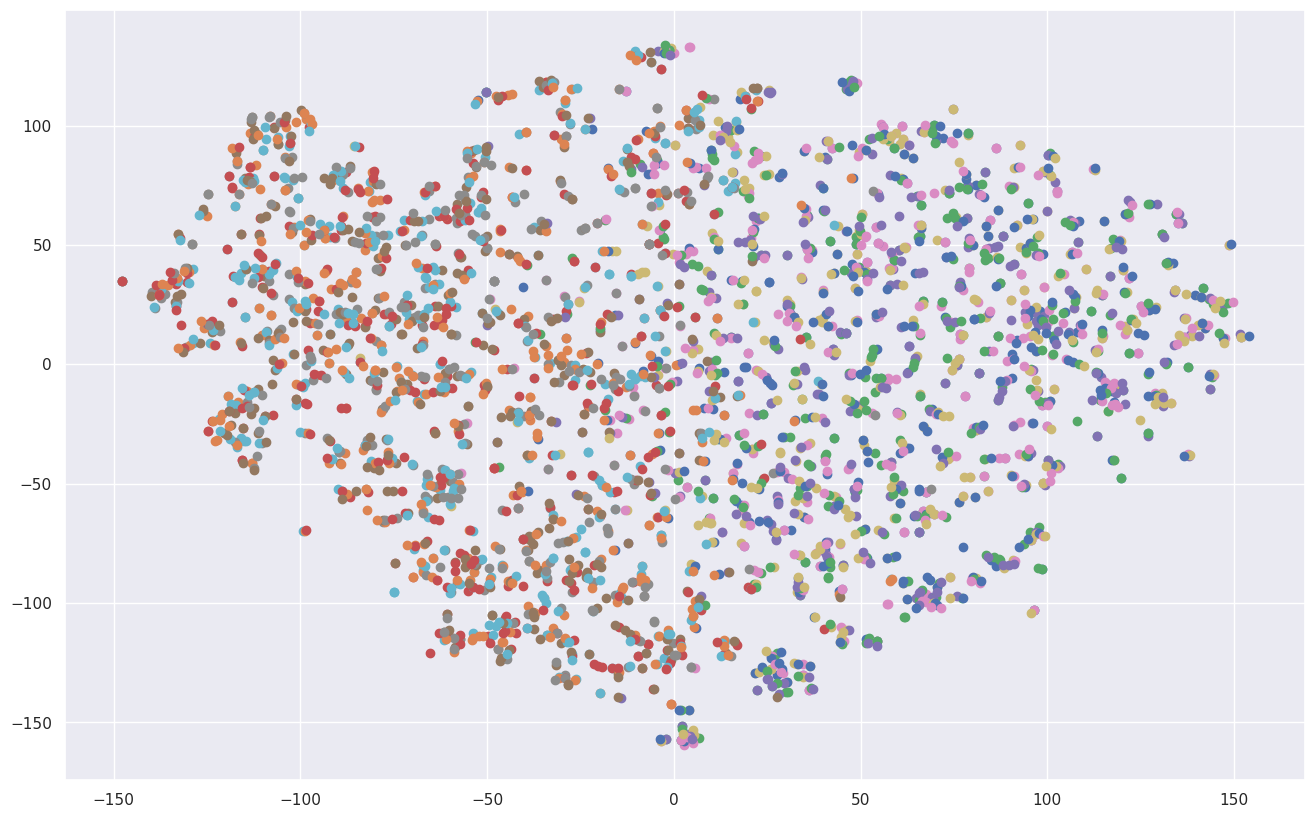

In [17]:
tsne_model = TSNE(perplexity=10, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

plt.figure(figsize=(16, 10)) 
for i, v in enumerate(new_values):
    plt.scatter(v[0], v[1])
plt.show()

/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


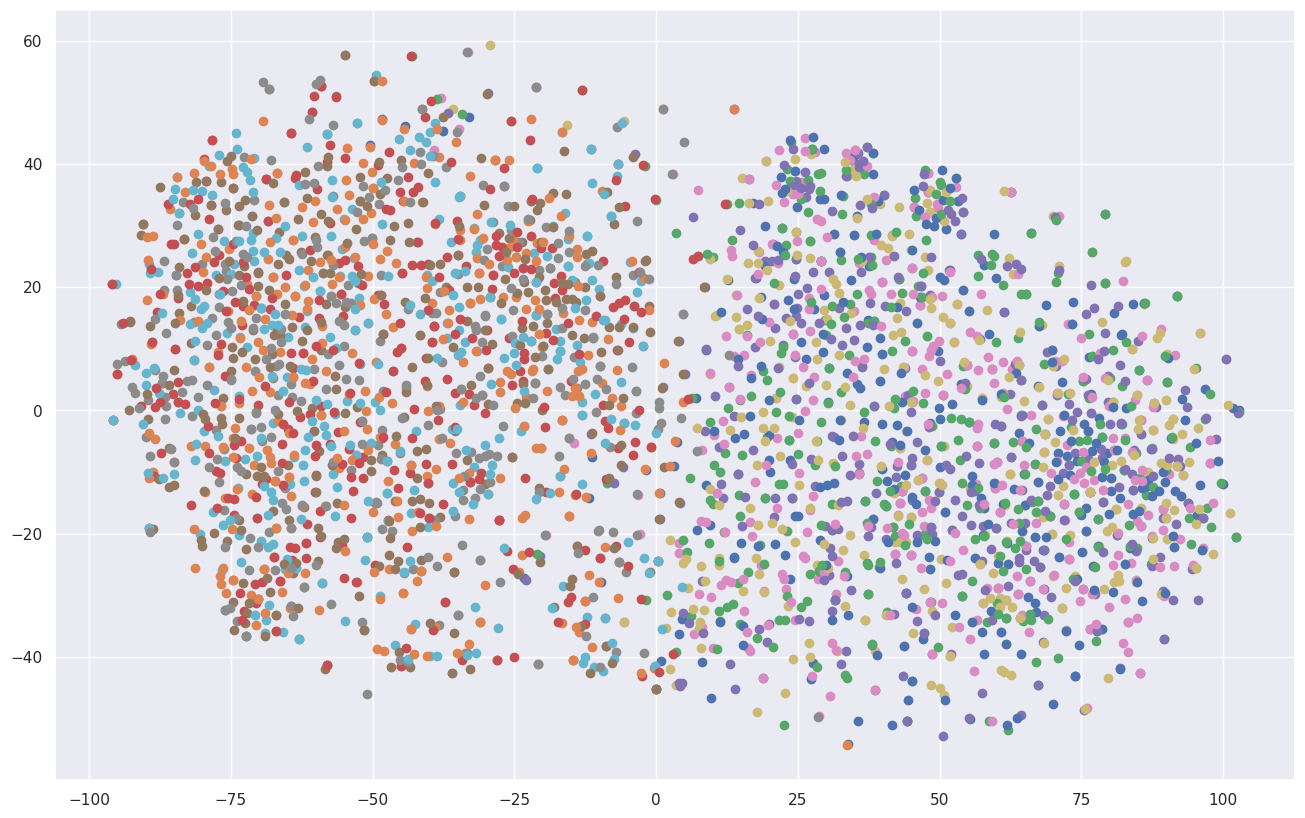

In [19]:
tsne_model = TSNE(perplexity=100, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

plt.figure(figsize=(16, 10)) 
for i, v in enumerate(new_values):
    plt.scatter(v[0], v[1])
plt.show()

/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


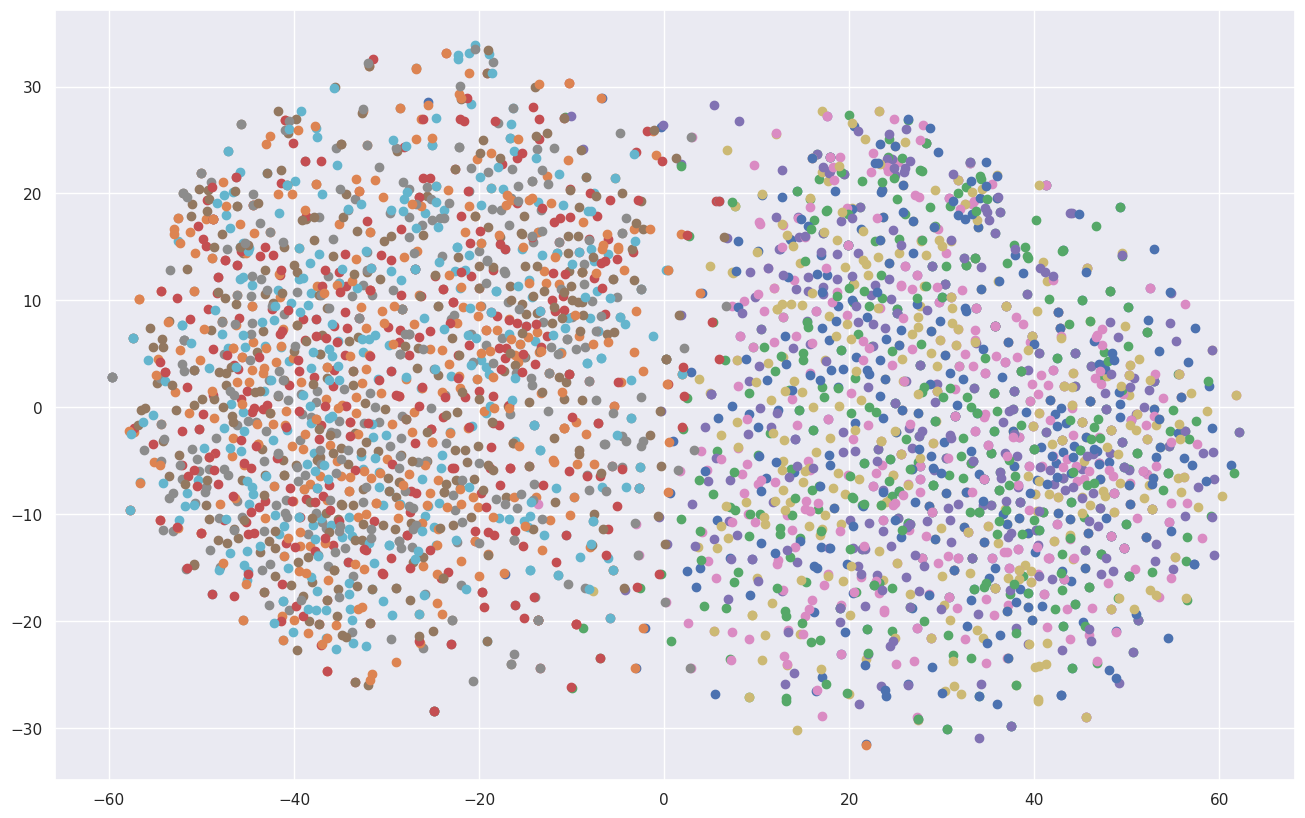

In [20]:
tsne_model = TSNE(perplexity=250, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

plt.figure(figsize=(16, 10)) 
for i, v in enumerate(new_values):
    plt.scatter(v[0], v[1])
plt.show()

/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


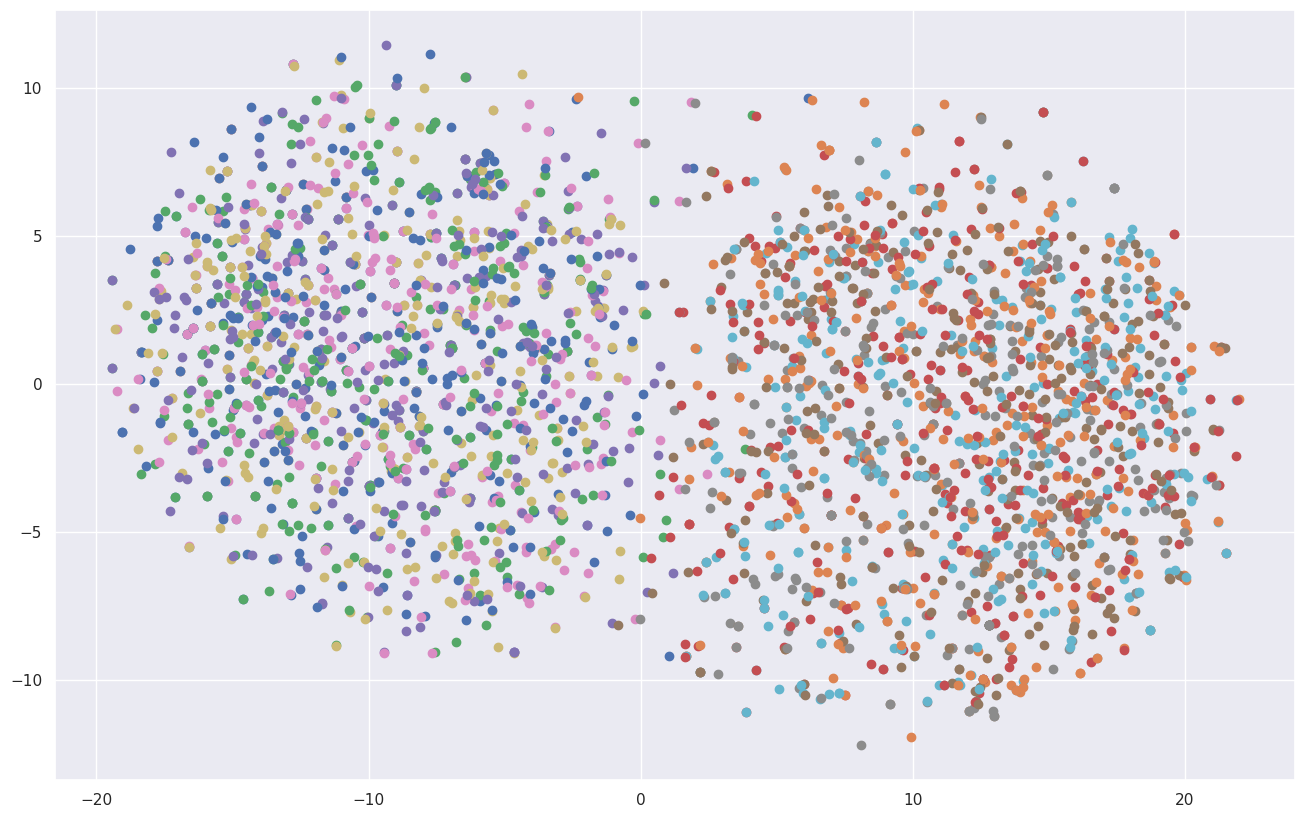

In [21]:
tsne_model = TSNE(perplexity=500, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

plt.figure(figsize=(16, 10)) 
for i, v in enumerate(new_values):
    plt.scatter(v[0], v[1])
plt.show()

/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


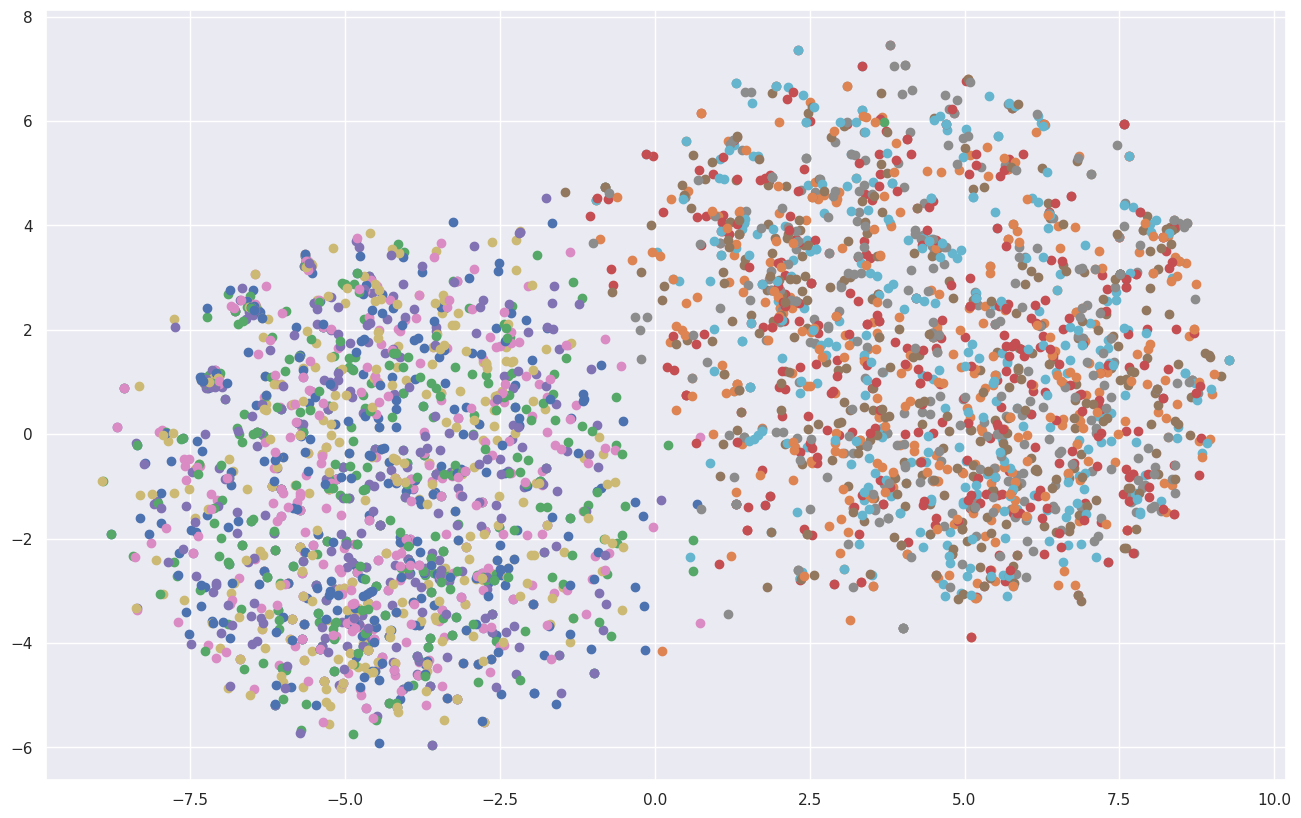

In [22]:
tsne_model = TSNE(perplexity=750, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

plt.figure(figsize=(16, 10)) 
for i, v in enumerate(new_values):
    plt.scatter(v[0], v[1])
plt.show()

# TF-IDF

In [34]:
import codecs
import json
from sklearn.linear_model import LogisticRegression
import pickle
import joblib

In [ ]:
!wget https://russiansuperglue.com/tasks/tf_idf
!unzip tf_idf_baseline.zip
!rm tf_idf_baseline.zip

In [35]:
def build_features_DaNetQA(path, vect):
    with codecs.open(path, encoding='utf-8-sig') as reader:
        lines = reader.read().split("\n")
        lines = list(map(json.loads, filter(None, lines)))
    res = list(map(
        lambda x: (str(x["question"]).strip(), x.get("label")), 
        lines))
    texts = list(map(lambda x: x[0], res))
    labels = list(map(lambda x: x[1], res))
    return (vect.transform(texts), labels)

In [36]:
def eval_DaNetQA(train_path, val_path, vect):
    train = build_features_DaNetQA(train_path, vect)
    val = build_features_DaNetQA(val_path, vect)

    clf = LogisticRegression()
    for i in range(3):
        clf = clf.fit(*train)
    return clf, {
        "train": clf.score(*train),
        "val": clf.score(*val),
    }

In [37]:
vect = joblib.load('tf_idf/tfidf.pkl')
print(f"L0: {eval_DaNetQA('DaNetQA/train_L0.jsonl', 'DaNetQA/val_L0.jsonl', vect)[1]}")
print(f"L1: {eval_DaNetQA('DaNetQA/train_L1.jsonl', 'DaNetQA/val_L1.jsonl', vect)[1]}")
print(f"L2: {eval_DaNetQA('DaNetQA/train_L2.jsonl', 'DaNetQA/val_L2.jsonl', vect)[1]}")
print(f"L3: {eval_DaNetQA('DaNetQA/train_L3.jsonl', 'DaNetQA/val_L3.jsonl', vect)[1]}")
print(f"L4: {eval_DaNetQA('DaNetQA/train_L4.jsonl', 'DaNetQA/val_L4.jsonl', vect)[1]}")
print(f"L5: {eval_DaNetQA('DaNetQA/train_L5.jsonl', 'DaNetQA/val_L5.jsonl', vect)[1]}")

/home/leysh/miniconda3/envs/catalyst1/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.21.3 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/leysh/miniconda3/envs/catalyst1/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.21.3 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


L0: {'train': 0.8010291595197255, 'val': 0.5907429963459196}
L1: {'train': 0.7987421383647799, 'val': 0.5943970767356882}
L2: {'train': 0.7987421383647799, 'val': 0.5943970767356882}
L3: {'train': 0.7987421383647799, 'val': 0.5943970767356882}
L4: {'train': 0.8050314465408805, 'val': 0.5481120584652862}
L5: {'train': 0.725557461406518, 'val': 0.5420219244823387}


In [35]:
def build_features_DaNetQA_alt(path):
    with codecs.open(path, encoding='utf-8-sig') as reader:
        lines = reader.read().split("\n")
        lines = list(map(json.loads, filter(None, lines)))
    res = list(map(
        lambda x: (str(x["question"]).strip(), x.get("label")), 
        lines))
    texts = list(map(lambda x: x[0], res))
    labels = list(map(lambda x: x[1], res))
    return (embed(texts), labels)

In [34]:
def eval_DaNetQA_alt(train_path, val_path):
    train = build_features_DaNetQA_alt(train_path)
    val = build_features_DaNetQA_alt(val_path)

    clf = LogisticRegression()
    for i in range(3):
        clf = clf.fit(*train)
    return clf, {
        "train": clf.score(*train),
        "val": clf.score(*val),
    }

In [36]:
print(f"L0: {eval_DaNetQA_alt('DaNetQA/train_L0.jsonl', 'DaNetQA/val_L0.jsonl')[1]}")
print(f"L1: {eval_DaNetQA_alt('DaNetQA/train_L1.jsonl', 'DaNetQA/val_L1.jsonl')[1]}")
print(f"L2: {eval_DaNetQA_alt('DaNetQA/train_L2.jsonl', 'DaNetQA/val_L2.jsonl')[1]}")
print(f"L3: {eval_DaNetQA_alt('DaNetQA/train_L3.jsonl', 'DaNetQA/val_L3.jsonl')[1]}")
print(f"L4: {eval_DaNetQA_alt('DaNetQA/train_L4.jsonl', 'DaNetQA/val_L4.jsonl')[1]}")
print(f"L5: {eval_DaNetQA_alt('DaNetQA/train_L5.jsonl', 'DaNetQA/val_L5.jsonl')[1]}")

L0: {'train': 0.7564322469982847, 'val': 0.5834348355663824}
L1: {'train': 0.7564322469982847, 'val': 0.5785627283800243}
L2: {'train': 0.7518582046883934, 'val': 0.5712545676004872}
L3: {'train': 0.7524299599771298, 'val': 0.584652862362972}
L4: {'train': 0.7558604917095483, 'val': 0.5651644336175395}
L5: {'train': 0.7615780445969125, 'val': 0.5736906211936662}


In [6]:
def eval_DaNetQA(train_path, val_path, vect):
    train = build_features_DaNetQA(train_path, vect)
    val = build_features_DaNetQA(val_path, vect)

    clf = LogisticRegression()
    for i in range(3):
        clf = clf.fit(*train)
    return clf, {
        "train": clf.score(*train),
        "val": clf.score(*val),
    }

# BERT Fine-Tune

In [2]:
import logging
from pathlib import Path
from typing import List, Mapping, Tuple
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import os
import yaml
from catalyst.utils import set_global_seed, prepare_cudnn
from transformers import AutoTokenizer, AutoConfig, AutoModel
from catalyst.callbacks.metrics.accuracy import AccuracyCallback
from catalyst.dl import (
    CheckpointCallback,
    OptimizerCallback,
    SchedulerCallback,
    SupervisedRunner,
)

project_root: Path = Path("").parent.parent

/home/leysh/miniconda3/envs/catalyst1/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
SEED = 17
NUM_CLASSES = 2
PATH_TO_LOG_FOLDER = Path('logdir')

TEXT_FIELD_NAME = 'passage'
QUEST_FIELD_NAME = 'question'
LABEL_FIELD_NAME = 'label'

## Data Load

In [4]:
class TextClassificationDataset(Dataset):
    """
    Wrapper around Torch Dataset to perform text classification
    """

    def __init__(
        self,
        texts: List[str],
        questions: List[str],
        labels: List[str] = None,
        label_dict: Mapping[str, int] = None,
        max_seq_length: int = None,
        model_name: str = None,
    ):
        """
        Args:
            texts (List[str]): a list with texts to classify or to train the
                classifier on
            labels List[str]: a list with classification labels (optional)
            label_dict (dict): a dictionary mapping class names to class ids,
                to be passed to the validation data (optional)
            max_seq_length (int): maximal sequence length in tokens,
                texts will be stripped to this length
            model_name (str): transformer model name, needed to perform
                appropriate tokenization

        """

        self.texts = texts
        self.questions = questions
        self.labels = labels
        self.label_dict = label_dict
        self.max_seq_length = max_seq_length

        if self.label_dict is None and labels is not None:
            # {'class1': 0, 'class2': 1, 'class3': 2, ...}
            # using this instead of `sklearn.preprocessing.LabelEncoder`
            # no easily handle unknown target values
            self.label_dict = dict(zip(sorted(set(labels)), range(len(set(labels)))))

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        # suppresses tokenizer warnings
        logging.getLogger("transformers.tokenization_utils").setLevel(logging.FATAL)

        # special tokens for transformers
        # in the simplest case a [CLS] token is added in the beginning
        # and [SEP] token is added in the end of a piece of text
        # [CLS] <indexes text tokens> [SEP] .. <[PAD]>
        self.sep_label = self.tokenizer.special_tokens_map['sep_token']
        self.sep_vid = self.tokenizer.vocab[self.sep_label]
        self.cls_label = self.tokenizer.special_tokens_map['cls_token']
        self.cls_vid = self.tokenizer.vocab[self.cls_label]
        self.pad_label = self.tokenizer.special_tokens_map['pad_token']
        self.pad_vid = self.tokenizer.vocab[self.pad_label]

    def __len__(self) -> int:
        """
        Returns:
            int: length of the dataset
        """
        return len(self.texts)

    def __getitem__(self, index) -> Mapping[str, torch.Tensor]:
        """Gets element of the dataset

        Args:
            index (int): index of the element in the dataset
        Returns:
            Single element by index
        """
        # encoding the text
        x = [self.texts[index], self.questions[index]]

        # a dictionary with `input_ids` and `attention_mask` as keys
        output_dict = self.tokenizer.encode_plus(
            text=x,
            add_special_tokens=True,
            #  Pad to a maximum length specified with the argument max_length
            #  or to the maximum acceptable input length for the model if that argument is not provided.
            padding="max_length", 
            # Truncate to a maximum length specified with the argument max_length 
            # or to the maximum acceptable input length for the model if that argument is not provided. 
            # This will truncate token by token, 
            # removing a token from the longest sequence in the pair if a pair of sequences (or a batch of pairs) is provided.
            truncation=True,
            # Controls the maximum length to use by one of the truncation/padding parameters.
            max_length=self.max_seq_length, 
            # return pytorch tensor
            return_tensors="pt", 
            return_token_type_ids=True,
            return_attention_mask=True,
        )

        # for Catalyst, there needs to be a key called features
        output_dict["features"] = output_dict["input_ids"].squeeze(0)
        del output_dict["input_ids"]

        # token_type_ids лежит во вложенном тензоре (x, 1', y), 
        # это мешает внутренним в Catalyst трансформациям поэтому вытягиваем его в (x, y)
        output_dict["token_type_ids"] = output_dict["token_type_ids"].squeeze(0)

        # encoding target
        if self.labels is not None:
            y = self.labels[index]
            y_encoded = torch.Tensor([self.label_dict.get(y, -1)]).long().squeeze(0)
            output_dict["targets"] = y_encoded
            
        return output_dict

In [5]:
def read_data(params: dict) -> Tuple[dict, dict]:
    """
    A custom function that reads data from CSV files, creates PyTorch datasets and
    data loaders. The output is provided to be easily used with Catalyst

    :param params: a dictionary read from the config.yml file
    :return: a tuple with 2 dictionaries
    """

    batch_size              = params["training"]["batch_size"]
    seed                    = SEED
    max_seq_length          = params["model"]["max_seq_length"]
    model_name_path_or_url  = params["model"]["model_name"]
    dataset_folder          = params["data"]["path_to_data"]
    context_column          = TEXT_FIELD_NAME
    question_column         = QUEST_FIELD_NAME
    label_column            = LABEL_FIELD_NAME
    train_filename          = params["data"]["train_filename"]
    validation_filename     = params["data"]["validation_filename"]
    test_filename           = params["data"]["test_filename"]

    # reading CSV files to Pandas dataframes
    train_df = pd.read_json(Path(dataset_folder) / train_filename, lines=True)
    valid_df = pd.read_json(Path(dataset_folder) / validation_filename, lines=True)
    test_df  = pd.read_json(Path(dataset_folder) / test_filename, lines=True)

    # делаем маппинг из True/False в INT
    label_dict = dict()
    for i, v in enumerate(np.unique(valid_df[label_column].values)):
        label_dict[v] = i

    # creating PyTorch Datasets
    train_dataset = TextClassificationDataset(
        texts           = train_df[context_column].values.tolist(),
        questions       = train_df[question_column].values.tolist(),
        labels          = train_df[label_column].values,
        label_dict      = label_dict,
        max_seq_length  = max_seq_length,
        model_name      = model_name_path_or_url
    )

    valid_dataset = TextClassificationDataset(
        texts           = valid_df[context_column].values.tolist(),
        questions       = valid_df[question_column].values.tolist(),
        labels          = valid_df[label_column].values,
        label_dict      = label_dict,
        max_seq_length  = max_seq_length,
        model_name      = model_name_path_or_url
    )

    test_dataset = TextClassificationDataset(
        texts           = test_df[context_column].values.tolist(),
        questions       = test_df[question_column].values.tolist(),
        max_seq_length  = max_seq_length,
        model_name      = model_name_path_or_url,
    )

    set_global_seed(seed)

    # creating PyTorch data loaders and placing them in dictionaries (for Catalyst)
    train_val_loaders = {
        "train": DataLoader(
            dataset=train_dataset,
            batch_size=batch_size,
            shuffle=True,
        ),
        "valid": DataLoader(
            dataset=valid_dataset,
            batch_size=batch_size,
            shuffle=False,
        ),
    }

    test_loaders = {
        "test": DataLoader(
            dataset=test_dataset,
            batch_size=batch_size,
            shuffle=False,
        )
    }

    del train_df, valid_df, test_df, train_dataset, valid_dataset, test_dataset
    del test_filename, validation_filename, train_filename, seed, model_name_path_or_url, max_seq_length, label_column, question_column, context_column, dataset_folder, batch_size
    return train_val_loaders, test_loaders

## Model

In [6]:
class BertForSequenceClassification(nn.Module):
    """
    Simplified version of the same class by HuggingFace.
    See transformers/modeling_distilbert.py in the transformers repository.
    """

    def __init__(
        self, 
        pretrained_model_name: str, 
        num_classes: int = None, 
        dropout: float = 0.3,
    ):
        """
        Args:
            pretrained_model_name (str): HuggingFace model name.
                See transformers/modeling_auto.py
            num_classes (int): the number of class labels
                in the classification task
        """
        super().__init__()
        self.num_classes = num_classes
        config = AutoConfig.from_pretrained(pretrained_model_name, num_labels=self.num_classes)

        self.model = AutoModel.from_pretrained(pretrained_model_name, config=config)
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=1)
        self.classifier = nn.Linear(config.hidden_size, self.num_classes)

    def forward(self, features, attention_mask=None, token_type_ids=None, head_mask=None, targets=None):
        """Compute class probabilities for the input sequence.

        Args:
            features (torch.Tensor): ids of each token,
                size ([bs, seq_length]
            attention_mask (torch.Tensor): binary tensor, used to select
                tokens which are used to compute attention scores
                in the self-attention heads, size [bs, seq_length]
            head_mask (torch.Tensor): 1.0 in head_mask indicates that
                we keep the head, size: [num_heads]
                or [num_hidden_layers x num_heads]
        Returns:
            PyTorch Tensor with predicted class scores
        """
        assert attention_mask is not None, "attention mask is none"

        # taking BERTModel output
        # see https://huggingface.co/transformers/model_doc/bert.html#transformers.BertModel
        bert_output = self.model(
            input_ids=features, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids, 
            head_mask=head_mask)
        # we only need the hidden state here and don't need
        # transformer output, so index 0
        seq_output = bert_output[0]                     # (bs, seq_len, dim)
        # mean pooling, i.e. getting average representation of all tokens
        pooled_output = seq_output.mean(axis=1)         # (bs, dim)
        pooled_output = self.dropout(pooled_output)     # (bs, dim)
        scores = self.classifier(pooled_output)         # (bs, num_classes)
        
        #scores = self.softmax(scores)
        return scores

## Train

Из-за того, что Cuda не умеет освобождать VRAM каждый раз приходится перезапускать ядро поэтому делать прогон серии конфигураций в Jupyter не имеет смысла.

Для прогона существует скрипт batch_run.py и bash цикл batch_run. 
Т.к. прогоны на одном сиде воспроизводимы, в batch_run ищется конфиг, для которого нет логов и делается для него тренировка.
При завершении прогона возвращается код 20;
При отсутсвии доступных конфигураций возвращается код 1 и происходит выход из цикла batch_run.

Такой метод позволяет после каждой тренировки принудительно вычищать зарезервированную Cuda VRAM через перезагрузку ядра

In [7]:
def getResultPath(config_key):
    return PATH_TO_LOG_FOLDER / config_key / "csv_logger" / "valid.csv"

In [8]:
def getConfigPaths(aL, aModels, aSeqSize, aParamsOptimize = ['PT']):
    configs_dict = dict()
    for iL in aL:
        for iM in aModels:
            for iS in aSeqSize:
                for iPO in aParamsOptimize:
                    name = f'L{iL}_M{iM}_S{iS}_{iPO}'
                    path = str(project_root / "configs" / f"config_{name}.yml")
                    if os.path.exists(path):
                        configs_dict[name] = path
    return configs_dict
configs_dict = getConfigPaths(
    range(0, 6), # уровни очистки данных с 0 (исходные) до 5 (все возможные уменьшения)
    range(1, 3), # проверяем на двух моделях
    [2**i for i in range(5, 10)], # размер кодировки: 32, 65, 128, 256, 512
    ['PT', 'PF']) # True и False значения

### Загружаем параметры из конфиг файла

In [13]:
# открываем файл конфига и зачитываем параметры
config_key = ''
for config in configs_dict:
    if not os.path.exists(getResultPath(config)):
        config_key = config
        break

#if config_key == '':
#    exit(1)

with open(configs_dict[config_key]) as f:
    params = yaml.load(f, Loader=yaml.FullLoader)
config_key

'L0_M1_S32_PF'

In [14]:
# загружаем датасет
train_val_loaders, test_loaders = read_data(params)

In [15]:
# загружаем модель из параметров с задангным кол-вом классов
model = BertForSequenceClassification(
    pretrained_model_name=params["model"]["model_name"],
    num_classes=NUM_CLASSES
)

In [16]:
if params["training"]["optimize_parameters"] == True:
    param_optimizer = list(model.model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.0}
    ]
else:
    optimizer_grouped_parameters = model.parameters()

# specify criterion for the multi-class classification task, optimizer and scheduler
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(optimizer_grouped_parameters, lr=float(params["training"]["learn_rate"]))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [17]:
# сбрасываем сид рандомайзеров
set_global_seed(SEED)
prepare_cudnn(deterministic=True)

In [18]:
# определяем тренера, который будет оперировать с forward методом, 
# input_key - ключи, которые будут преедаваться из тензора в forward
runner = SupervisedRunner(input_key=("features", "attention_mask", "token_type_ids"))

In [ ]:
logdir_path = PATH_TO_LOG_FOLDER / config_key
metric_key = 'accuracy01' #'loss'
# запускаем обучение
runner.train(
    # модель
    model=model,
    # функция потерь
    criterion=criterion,
    # оптимизатор
    optimizer=optimizer,
    # расписание
    scheduler=scheduler,
    # словарь из тренировочного и тестового датасета
    loaders=train_val_loaders,
    # функции обратной связи
    callbacks=[
        AccuracyCallback(num_classes=NUM_CLASSES, input_key="logits", target_key="targets"),
        OptimizerCallback(accumulation_steps=int(params["training"]["accum_steps"]), metric_key=metric_key),
        SchedulerCallback(loader_key="valid", metric_key=metric_key),
        CheckpointCallback(logdir=logdir_path, loader_key="valid", metric_key=metric_key, minimize=True),
    ],
    # путь до папки, в которую будут сохраняться результаты, 
    # промежуточные модели: лучшая и последняя
    logdir=logdir_path,
    # количество эпох
    num_epochs=int(params["training"]["num_epochs"]),
    # вывод логирующих сообщений
    verbose=True,
)

# Анализ результатов

In [5]:
def getMinMax(d = [dict]):
    maxKey, minKey = None, None
    maxVal, minVal = None, None
    for key in d:
        curMax, curMin = np.max(d[key]), np.min(d[key])
        if maxKey == None or curMax > maxVal:
            maxKey, maxVal = key, curMax
        if minKey == None or curMin < minVal:
            minKey, minVal = key, curMin
    return maxKey, minKey, maxVal, minVal

In [6]:
def getMinMaxFromDFs(d = [dict], column = [str]):
    for c in d:
        d[c] = d[c][column].to_numpy().astype(np.float32)
        
    if len(d) == 0:
        return '', ''
    
    maxKey, minKey, _, _ = getMinMax(d)
    return maxKey, minKey

In [7]:
def plotScores(d = [dict], column = [str], title = "", ymax = 0.8, ymin = 0.5):
    for c in d:
        if type(d[c]) == pd.DataFrame:
            d[c] = d[c][column].to_numpy().astype(np.float32)

    # определяем размер полотна
    plt.figure(figsize=(12, 6)) 
    plt.title(column if len(title) == 0 else title)

    maxKey, minKey, maxVal, minVal = getMinMax(d)

    # рисуем графики с маркерами
    for key in d:
        plt.plot(
            d[key], 
            linewidth=2 if key == maxKey else 1, # выделяем жирной линией наивысший график
            marker='o')

    # легенда в нижнем правом угле
    plt.legend(list(d.keys()), loc='lower right')

    # включаем сетку
    plt.grid(True)

    # задаем базовый шаг для Y
    step = 0.01 
    # округляем вниз и уменьшаем на шаг наименьшее значение
    minVal = (np.floor(minVal / step) * step - step) if ymin == None else ymin
    # округляем вверх и увеличиваем на шаг верхнее значение
    maxVal = (np.ceil(maxVal / step) * step + step)  if ymax == None else ymax 
    # вычисляем уменьшение шага чтоб не было накладывания лейблов,
    # "+2" это верхний и нижний шаг, 
    # "/20" - эмпирически выведено, что в полотно (12, 6) влезает 20 лейблов
    stepMul = np.ceil((int((maxVal - minVal) / step) + 2) / 20)
    # фиксируем диапозон Y 
    plt.yticks(np.arange(minVal, maxVal, step * stepMul))
    plt.ylim(minVal, maxVal)

    # фиксируем диапозон X 
    xticksLen = len(d[maxKey])
    plt.xticks(np.arange(0, xticksLen))
    plt.xlim(-1, xticksLen)

In [8]:
def getResultsDF(aL, aModels, aSeqSize, aParamOptimize):
    df_dict = dict() 
    for c in getConfigPaths(aL, aModels, aSeqSize, aParamOptimize):
        try:
            df_dict[c] = pd.read_csv(PATH_TO_LOG_FOLDER / c / "csv_logger" / "valid.csv")
        except:
            pass
    return df_dict

## Экспиримент 1. 
Перебираем разную длину кодировки от 32 до 512 для претренированной 'DeepPavlov/rubert-base-cased-sentence' с блокировкой ключевых параметров

#### Модель 'DeepPavlov/rubert-base-cased-sentence', Максимальная длина кодировки = 512

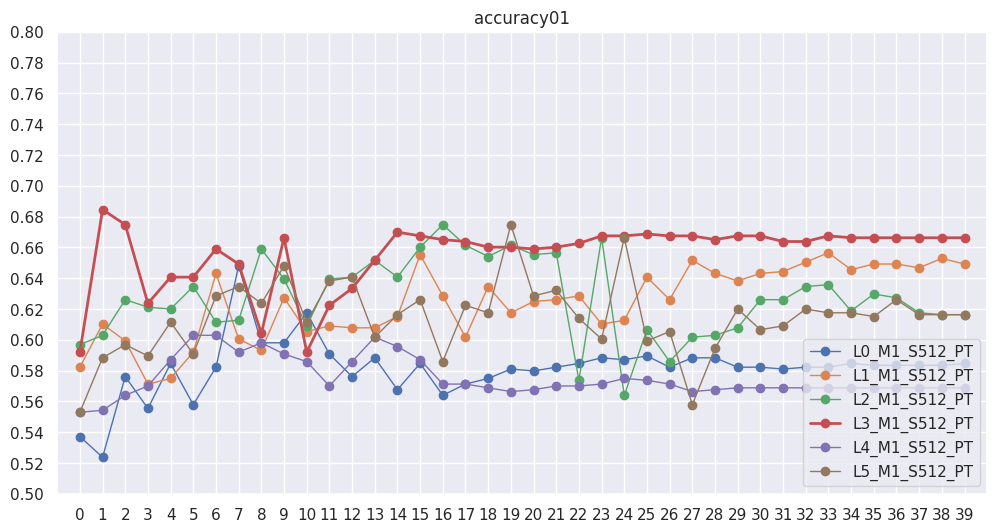

In [13]:
plotScores(getResultsDF(range(0, 6), [1], [512], ['PT']), 'accuracy01')

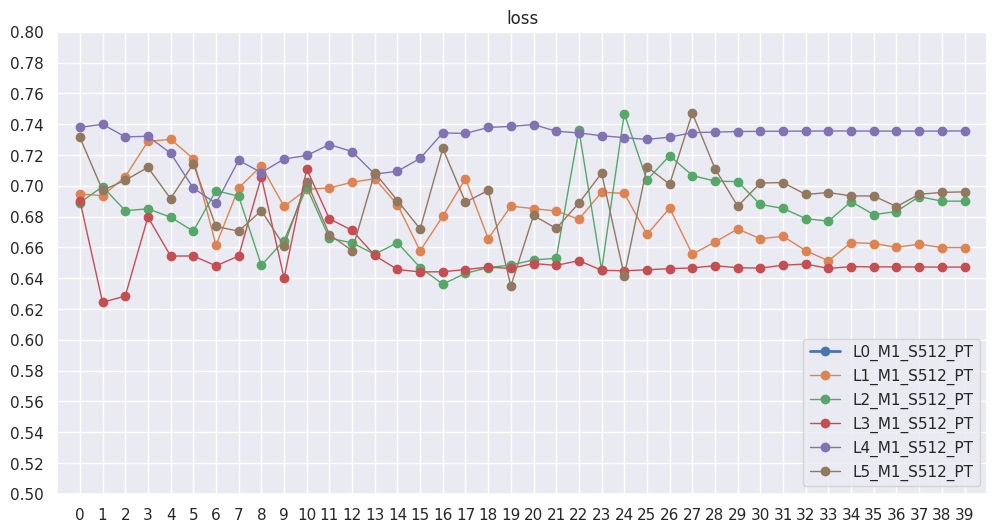

In [14]:
plotScores(getResultsDF(range(0, 6), [1], [512], ['PT']), 'loss')

#### Модель 'DeepPavlov/rubert-base-cased-sentence', Максимальная длина кодировки = 256

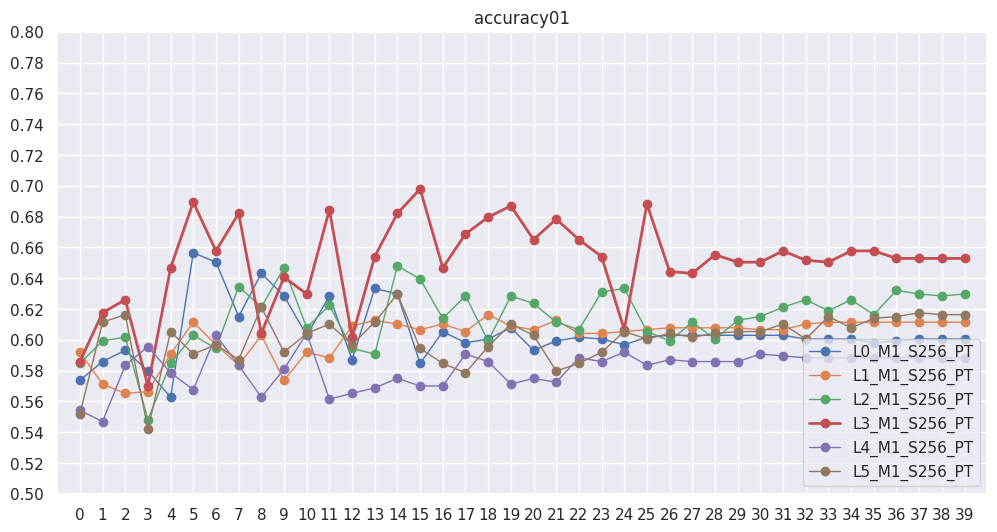

In [15]:
plotScores(getResultsDF(range(0, 6), [1], [256], ['PT']), 'accuracy01')

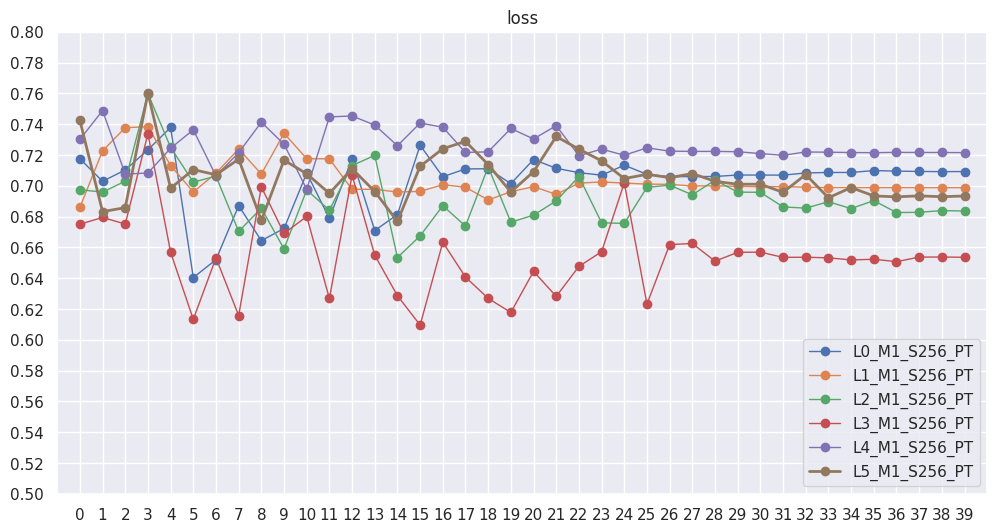

In [16]:
plotScores(getResultsDF(range(0, 6), [1], [256], ['PT']), 'loss')

#### Модель 'DeepPavlov/rubert-base-cased-sentence', Максимальная длина кодировки = 128

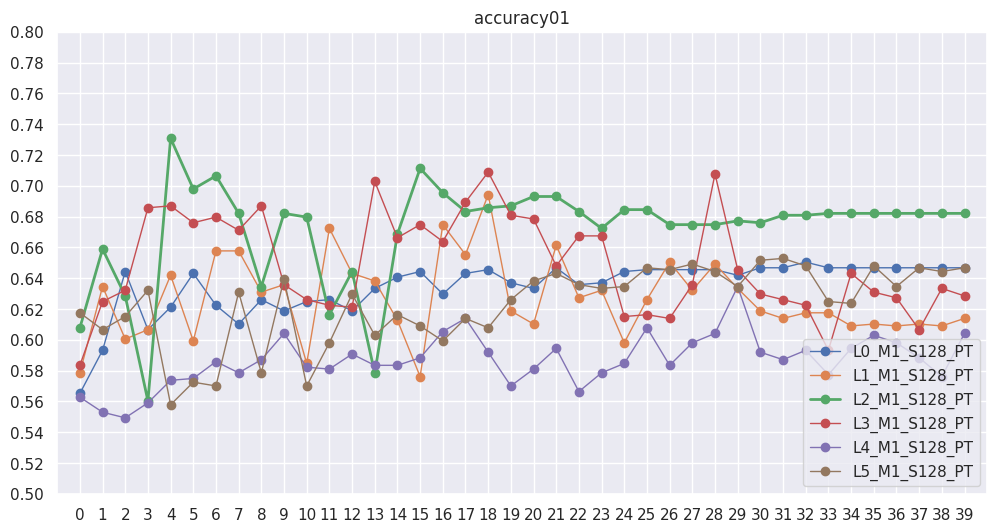

In [17]:
plotScores(getResultsDF(range(0, 6), [1], [128], ['PT']), 'accuracy01')

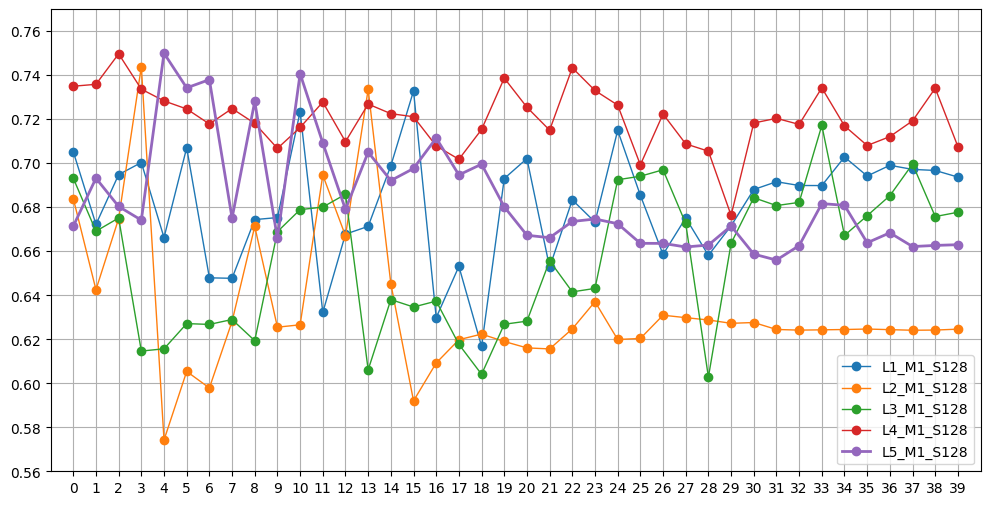

In [20]:
plotScores(getResultsDF(range(0, 6), [1], [128], ['PT']), 'loss')

#### Модель 'DeepPavlov/rubert-base-cased-sentence', Максимальная длина кодировки = 64

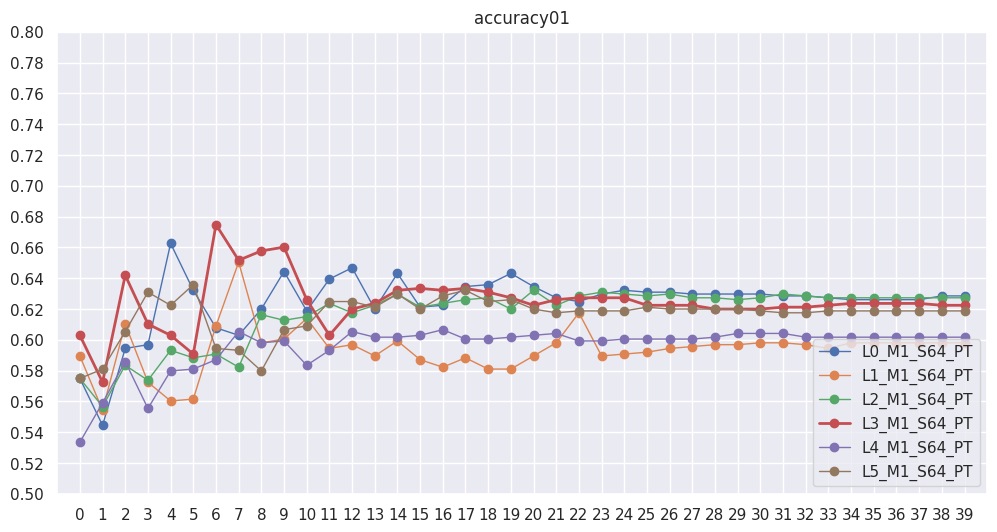

In [18]:
plotScores(getResultsDF(range(0, 6), [1], [64], ['PT']), 'accuracy01')

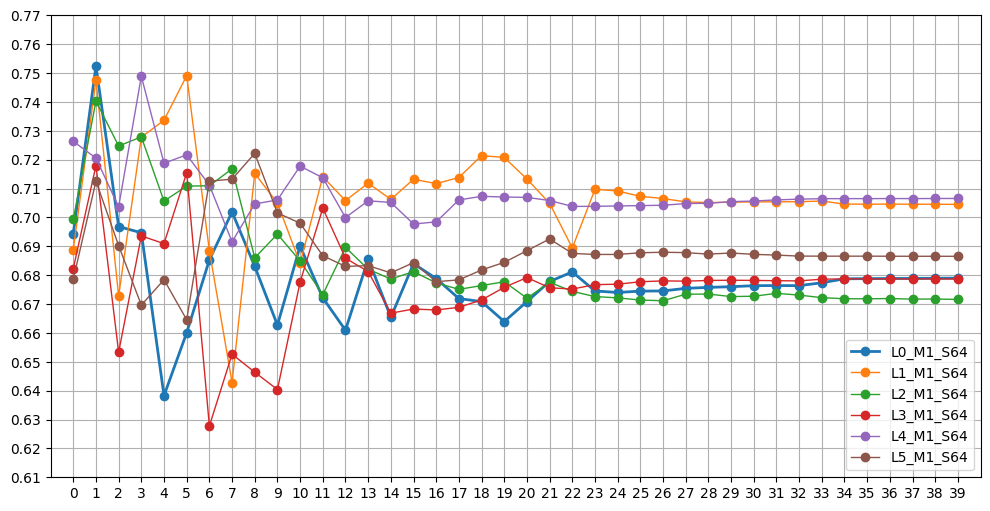

In [22]:
plotScores(getResultsDF(range(0, 6), [1], [64], ['PT']), 'loss')

#### Модель 'DeepPavlov/rubert-base-cased-sentence', Максимальная длина кодировки = 32

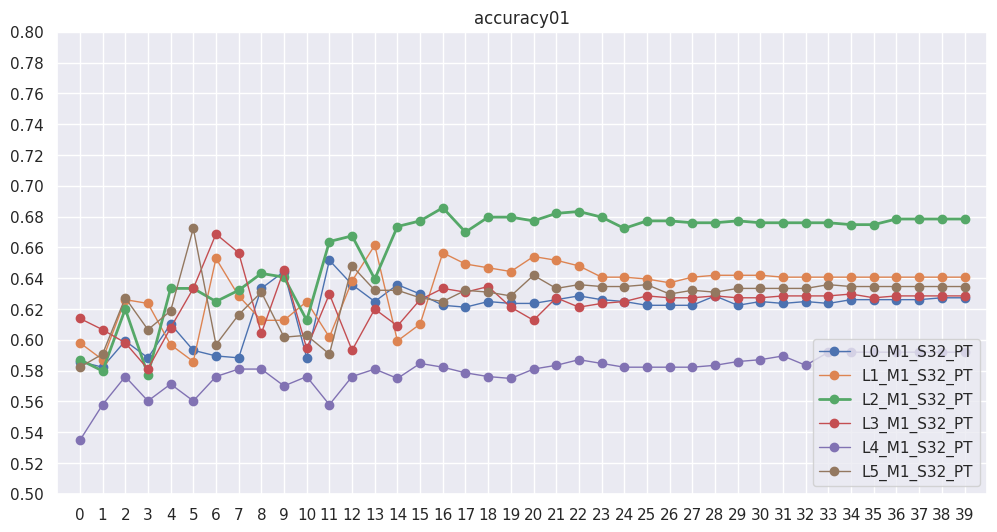

In [19]:
plotScores(getResultsDF(range(0, 6), [1], [32], ['PT']), 'accuracy01')

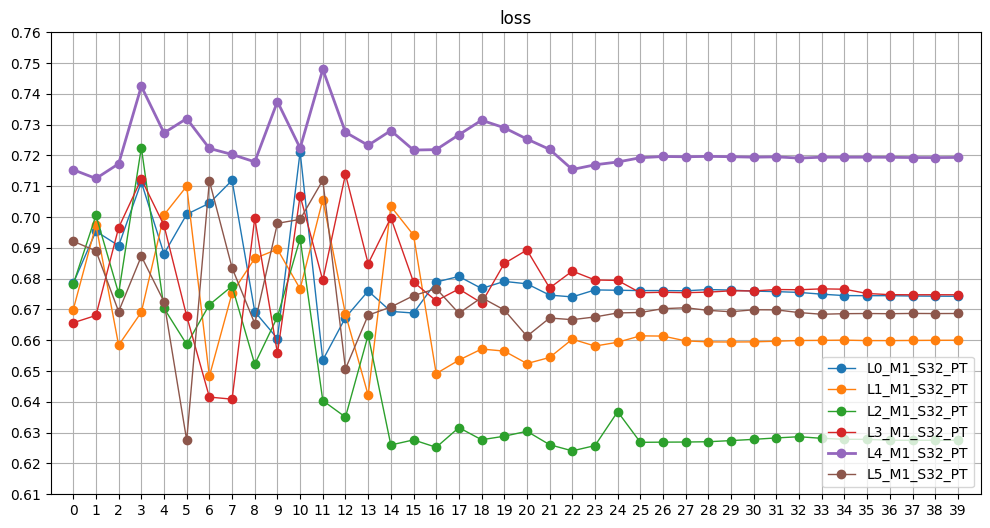

In [22]:
plotScores(getResultsDF(range(0, 6), [1], [32], ['PT']), 'loss')

### Группировка по очистке данных

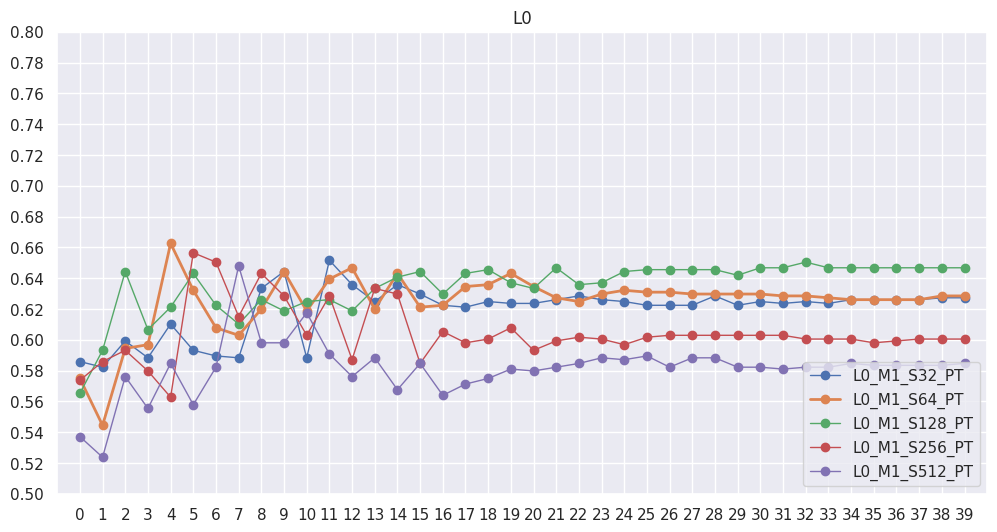

In [20]:
plotScores(getResultsDF([0], [1], [32, 64, 128, 256, 512], ['PT']), 'accuracy01', 'L0', 0.8, 0.5)

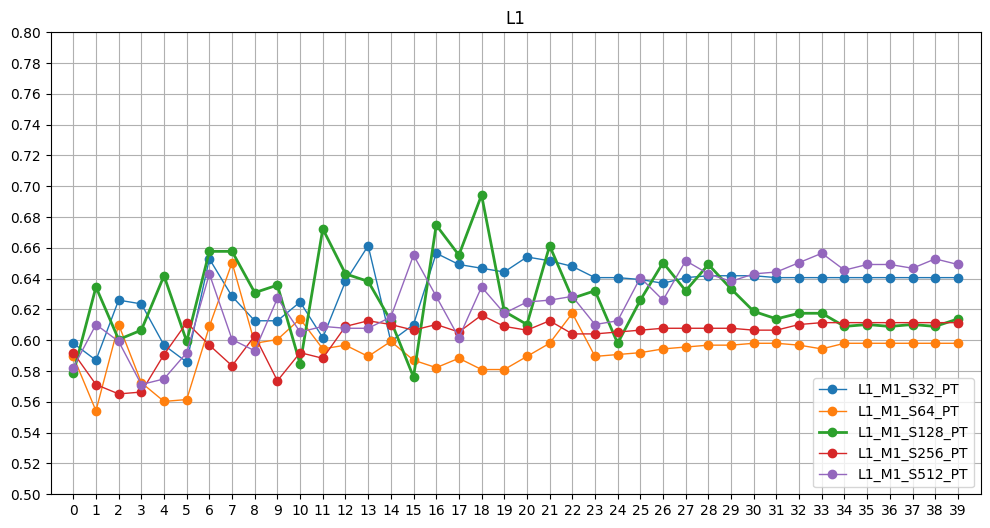

In [41]:
plotScores(getResultsDF([1], [1], [32, 64, 128, 256, 512], ['PT']), 'accuracy01', 'L1', 0.8, 0.5)

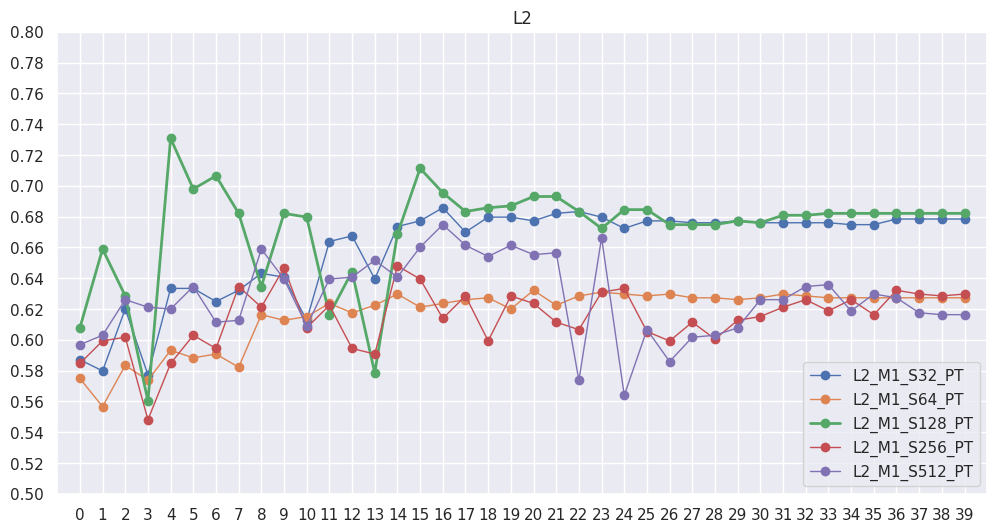

In [22]:
plotScores(getResultsDF([2], [1], [32, 64, 128, 256, 512], ['PT']), 'accuracy01', 'L2', 0.8, 0.5)

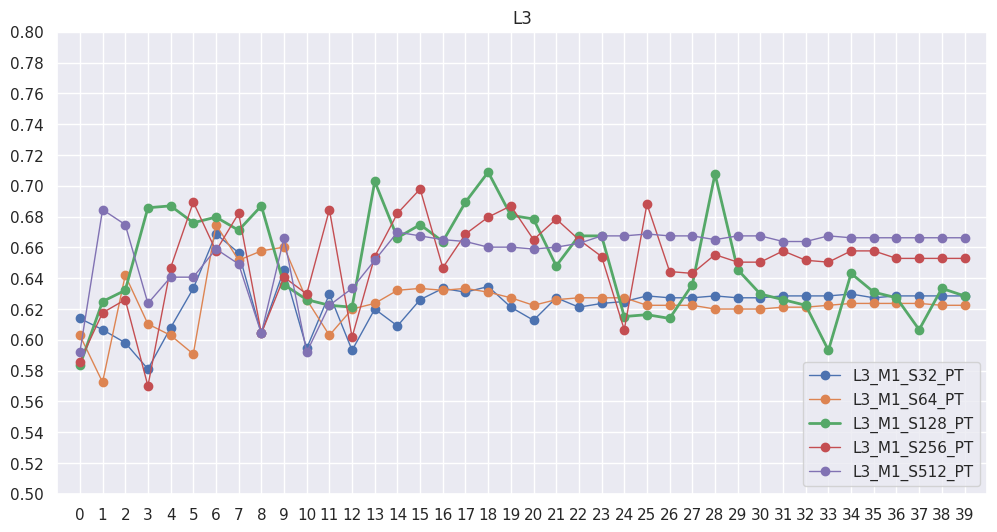

In [23]:
plotScores(getResultsDF([3], [1], [32, 64, 128, 256, 512], ['PT']), 'accuracy01', 'L3', 0.8, 0.5)

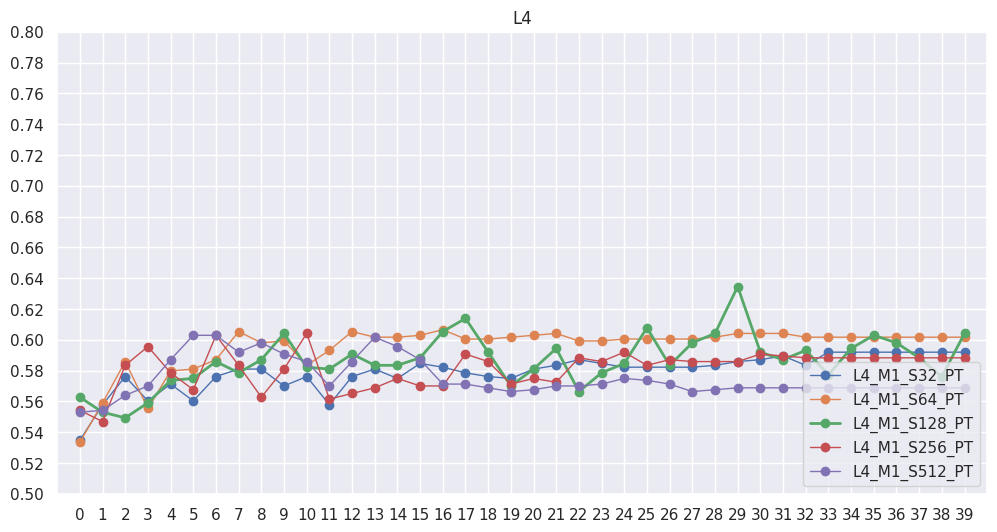

In [24]:
plotScores(getResultsDF([4], [1], [32, 64, 128, 256, 512], ['PT']), 'accuracy01', 'L4', 0.8, 0.5)

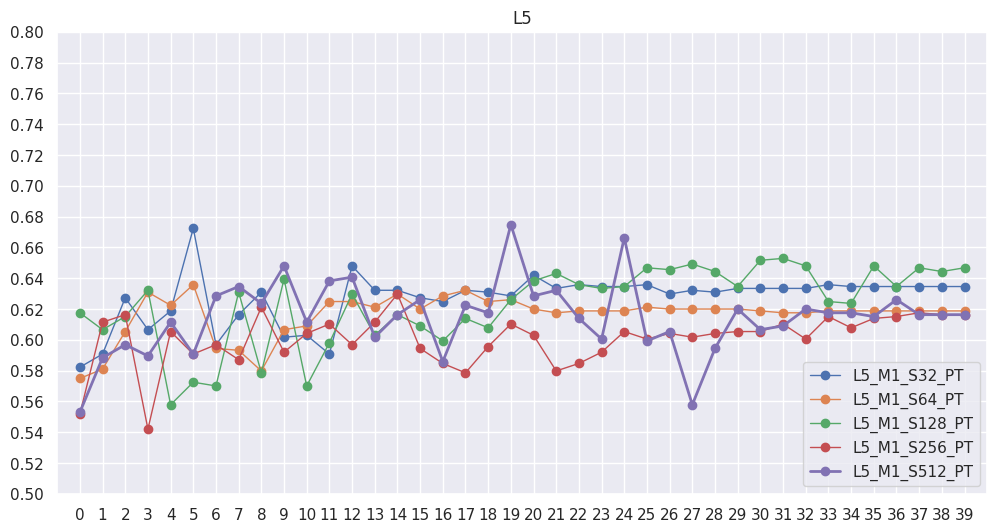

In [25]:
plotScores(getResultsDF([5], [1], [32, 64, 128, 256, 512], ['PT']), 'accuracy01', 'L5', 0.8, 0.5)

### Лучшие модели 'DeepPavlov/rubert-base-cased-sentence'

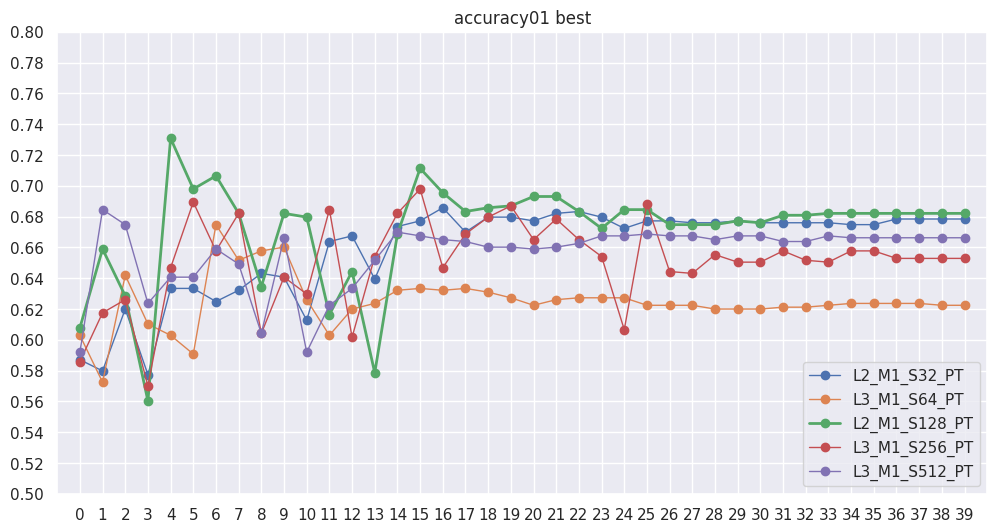

In [26]:
max_models = dict()
for iSq in [2**i for i in range(5,10)]:
    max_key, _ = getMinMaxFromDFs(df := getResultsDF(range(0, 6), [1], [iSq], ['PT']), 'accuracy01')
    max_models[max_key] = df[max_key]
plotScores(max_models, 'accuracy01 best') 

## Экспиримент 2. 
Перебираем разную длину кодировки от 32 до 512 для претренированной 'DeepPavlov/rubert-base-cased-sentence' без блокировка параметров

#### Модель 'DeepPavlov/rubert-base-cased-sentence', Максимальная длина кодировки = 512

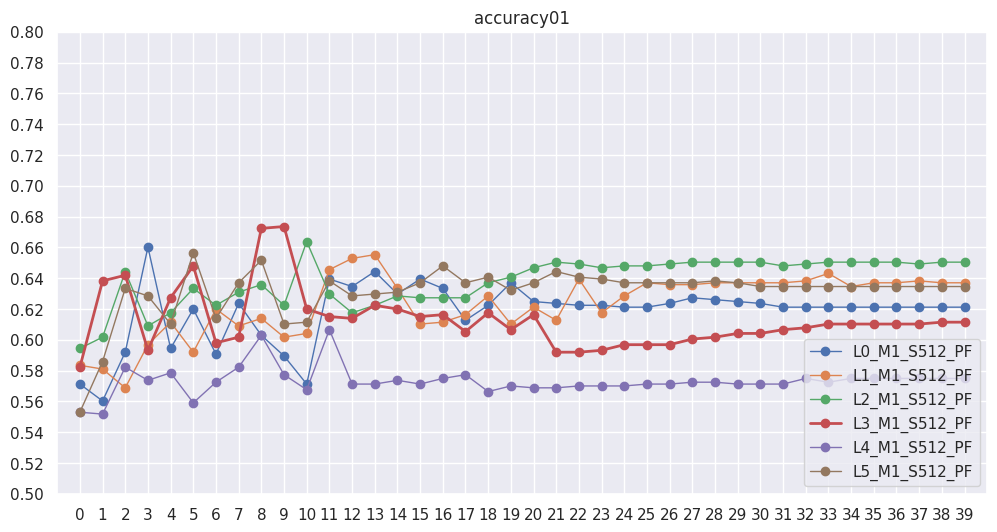

In [28]:
plotScores(getResultsDF(range(0, 6), [1], [512], ['PF']), 'accuracy01')

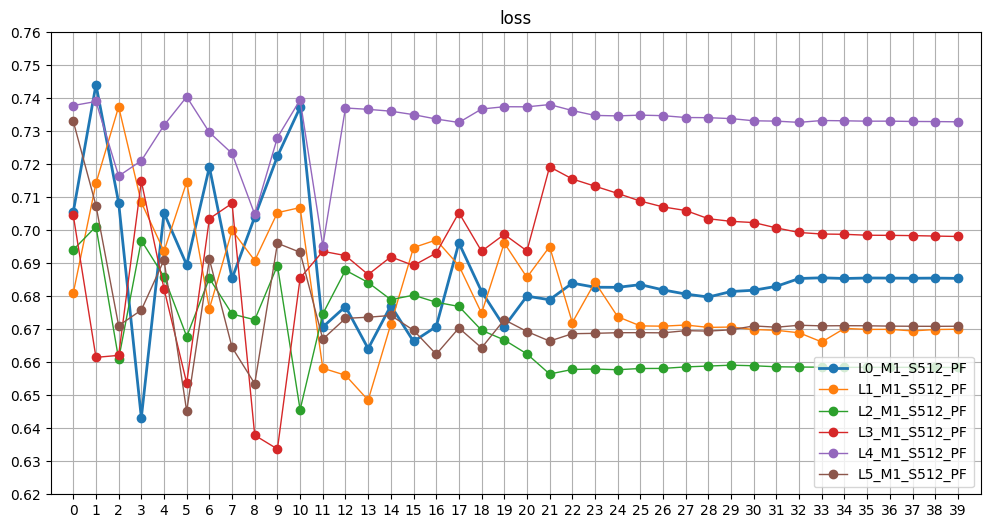

In [31]:
plotScores(getResultsDF(range(0, 6), [1], [512], ['PF']), 'loss')

#### Модель 'DeepPavlov/rubert-base-cased-sentence', Максимальная длина кодировки = 256

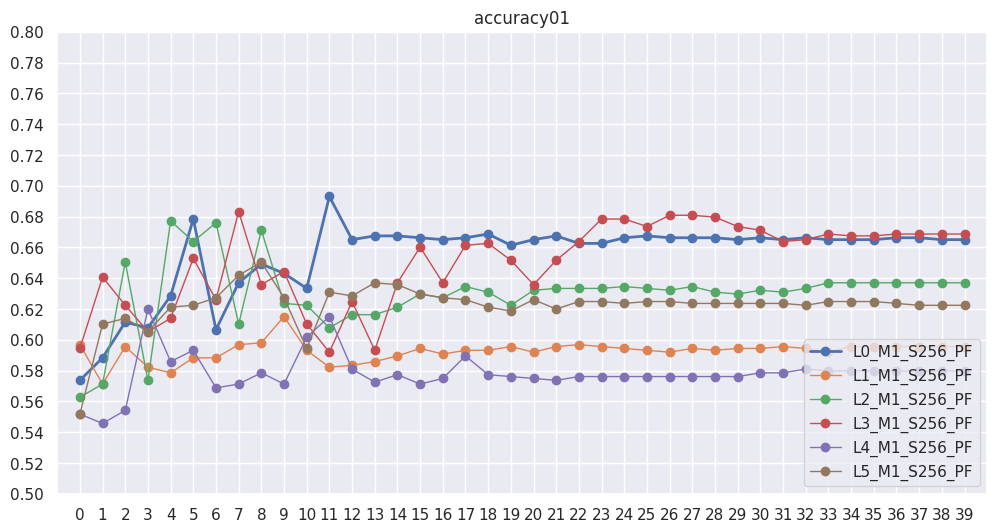

In [29]:
plotScores(getResultsDF(range(0, 6), [1], [256], ['PF']), 'accuracy01')

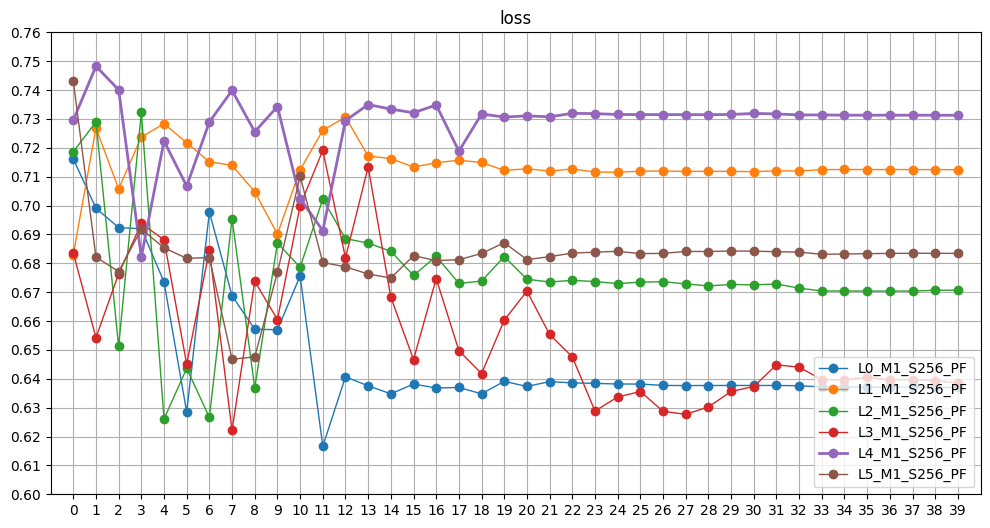

In [33]:
plotScores(getResultsDF(range(0, 6), [1], [256], ['PF']), 'loss')

#### Модель 'DeepPavlov/rubert-base-cased-sentence', Максимальная длина кодировки = 128

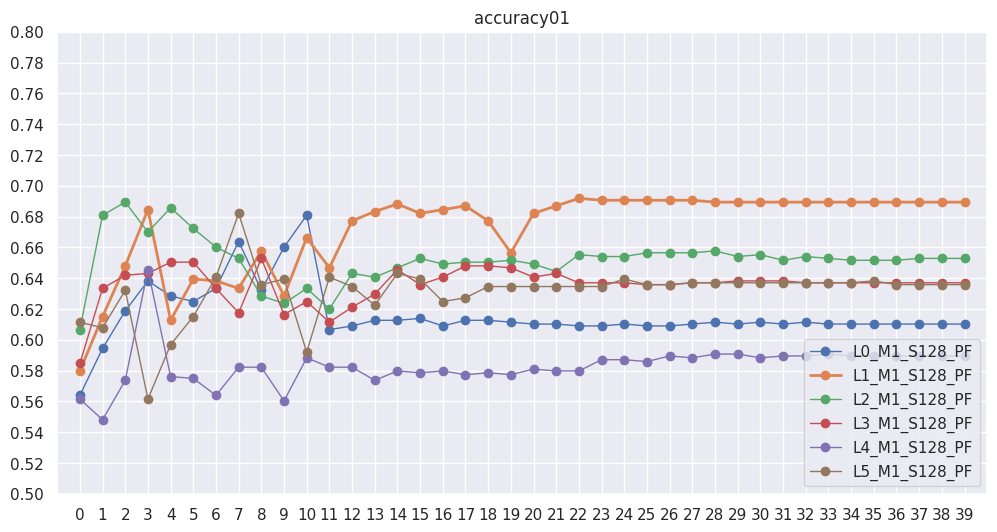

In [30]:
plotScores(getResultsDF(range(0, 6), [1], [128], ['PF']), 'accuracy01')

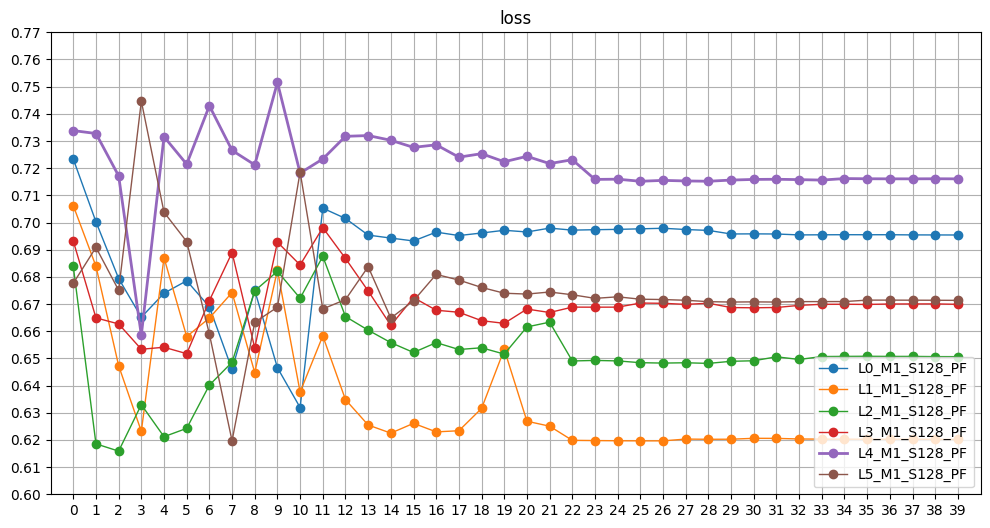

In [40]:
plotScores(getResultsDF(range(0, 6), [1], [128], ['PF']), 'loss')

#### Модель 'DeepPavlov/rubert-base-cased-sentence', Максимальная длина кодировки = 64

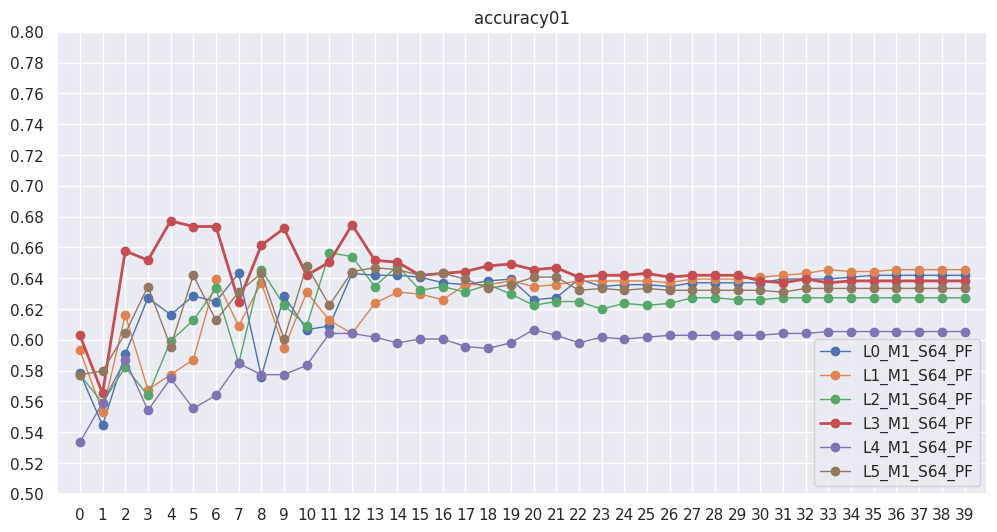

In [31]:
plotScores(getResultsDF(range(0, 6), [1], [64], ['PF']), 'accuracy01')

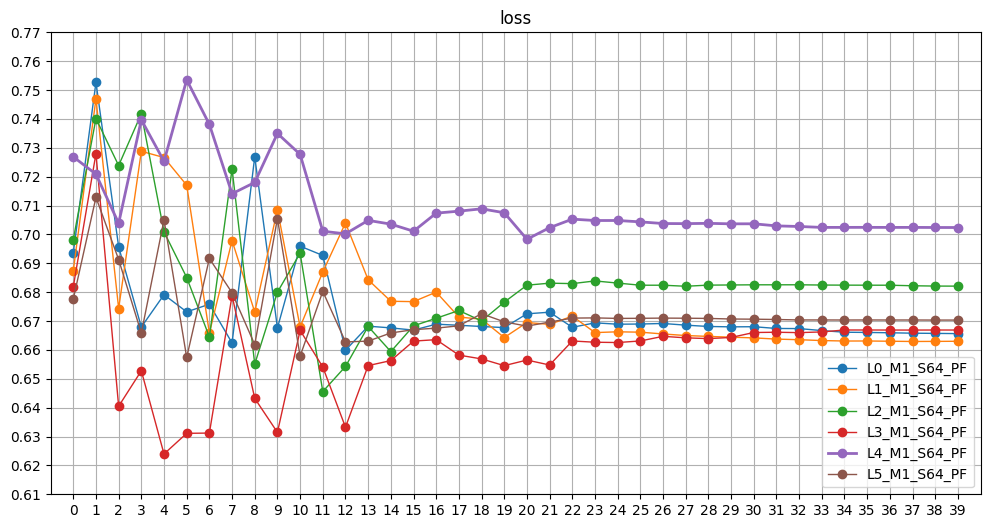

In [38]:
plotScores(getResultsDF(range(0, 6), [1], [64], ['PF']), 'loss')

#### Модель 'DeepPavlov/rubert-base-cased-sentence', Максимальная длина кодировки = 32

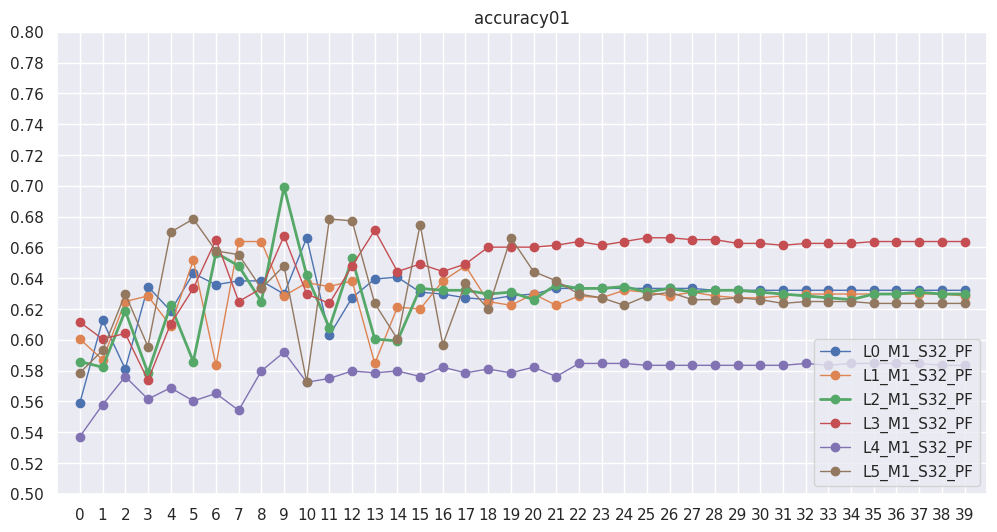

In [32]:
plotScores(getResultsDF(range(0, 6), [1], [32], ['PF']), 'accuracy01')


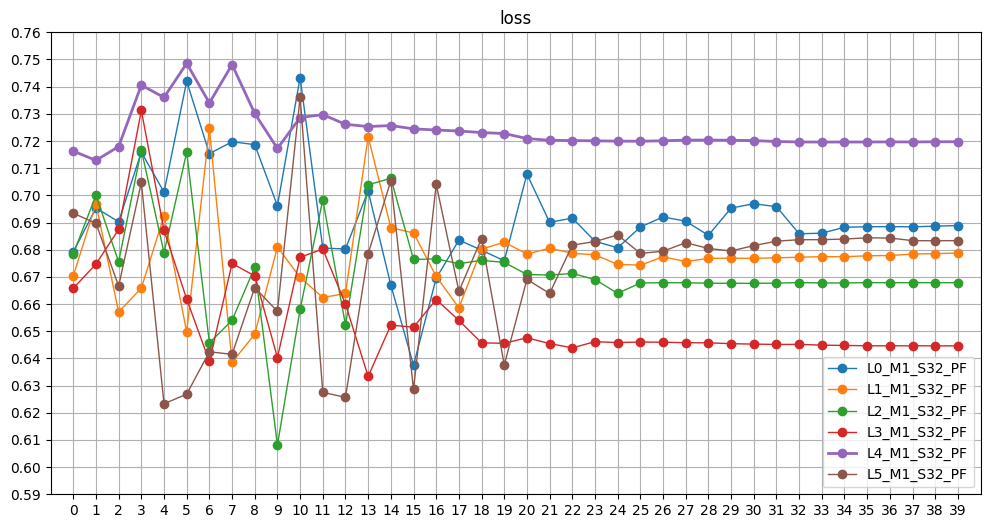

In [36]:
plotScores(getResultsDF(range(0, 6), [1], [32], ['PF']), 'loss')

#### Лучшие модели 'DeepPavlov/rubert-base-cased-sentence' без блокировки параметров модели

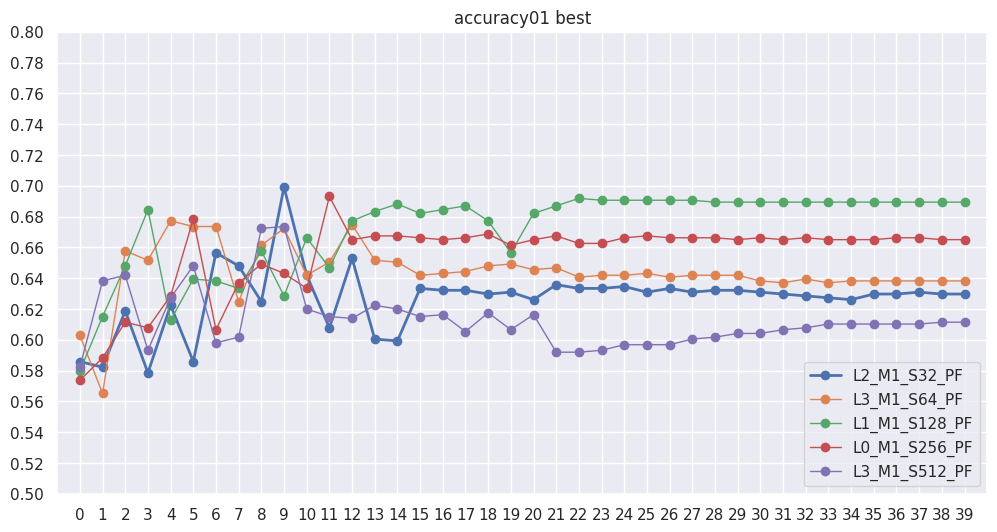

In [33]:
max_models = dict()
for iSq in [2**i for i in range(5,10)]:
    max_key, _ = getMinMaxFromDFs(df := getResultsDF(range(0, 6), [1], [iSq], ['PF']), 'accuracy01')
    max_models[max_key] = df[max_key]
plotScores(max_models, 'accuracy01 best') 

# Проверка результата 

In [ ]:
# and running inference
torch.cuda.empty_cache()

# getting validation metrics
metrics = runner.evaluate_loader(
    loader=train_val_loaders["valid"],
    callbacks=[AccuracyCallback(input_key="logits", target_key="targets")],
)
print(metrics)

# lastly, saving predicted scores for the test set
test_pred_scores = np.concatenate(
    [pred["logits"].detach().cpu().numpy() for pred in runner.predict_loader(loader=test_loaders["test"])]
)